<a href="https://colab.research.google.com/github/BrainConnection/Quantum_Algorithm/blob/main/4.%205Q%20TFIM%20VQNHE%20CNN%20QEM%20Depolarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [ ]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit[visualization]
!pip install qiskit-algorithms
!pip install qiskit-aer

!pip install scipy
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.0/318.0 kB 11.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 7.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   

In [ ]:
from functools import cache

from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Options

# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(channel="ibm_quantum",
                                  token="067e5c82606f0a1157dd554e2087d6b7a9b823dbaa4ad47b95c3337eab2e6cd9361719cc0470f4a98d1631b73b264a82577012a0b8ff32963d5964e6cc12c525",
                                  set_as_default=True,
                                  overwrite=True)

service = QiskitRuntimeService()
backend = service.backend("ibmq_qasm_simulator")

# Hamiltonian Diagonalization

$$ H = Σ Z_j Z_{j+1} - Σ X_j  $$

1D 5 Qubit System

In [ ]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
hamiltonian_matrix = hamiltonian.to_matrix()

eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

lowest_energy = np.min(eigenvalue)

np.real(lowest_energy)

-6.026674183332294

# 5. CNN Estimation - Depolarizing Channel

## Depolarization Channel, Error 0.001~0.1, Shots = 10000, FC Hidden Layer 1개

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

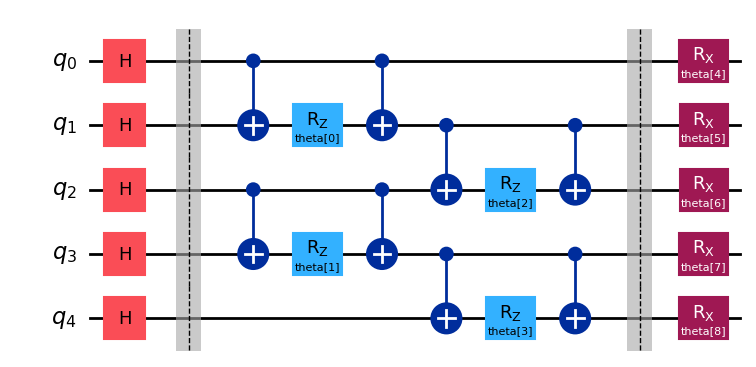

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

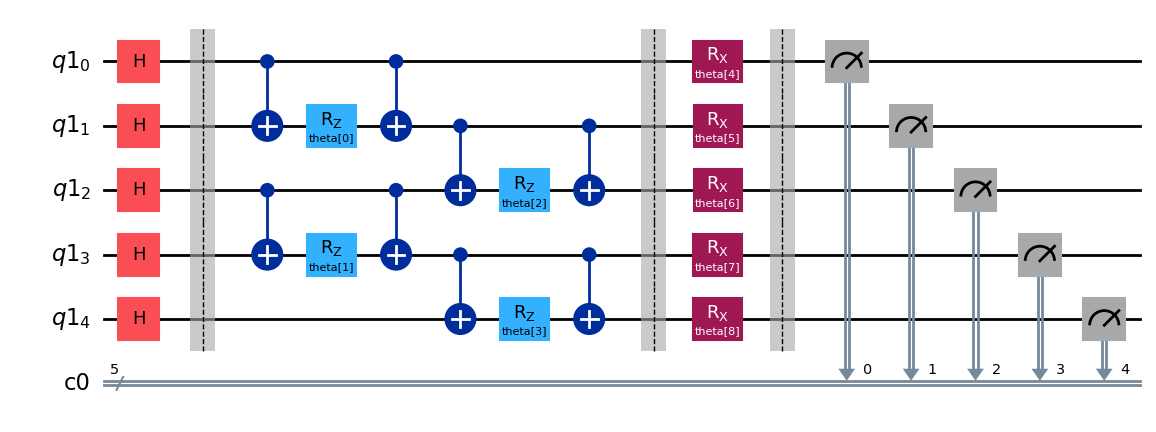

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

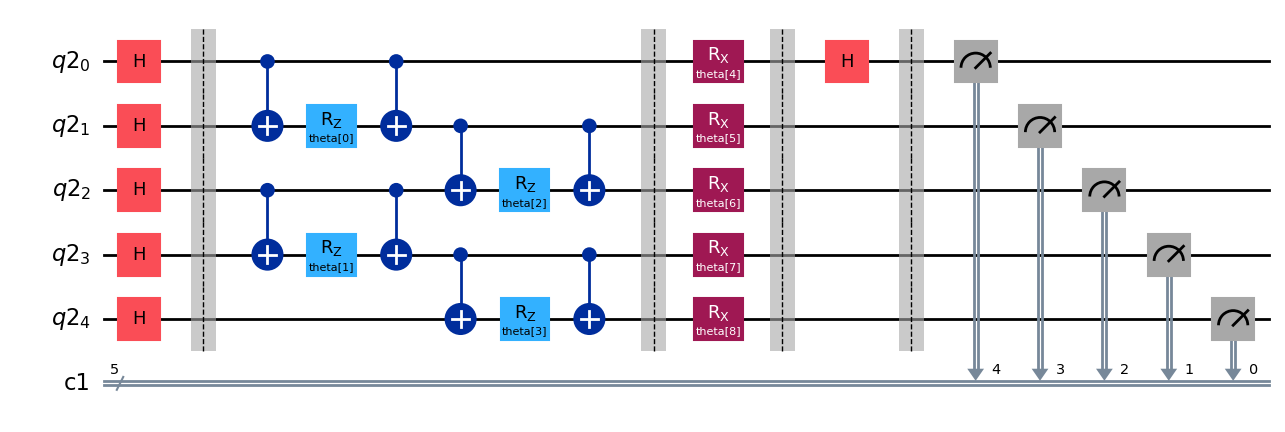

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

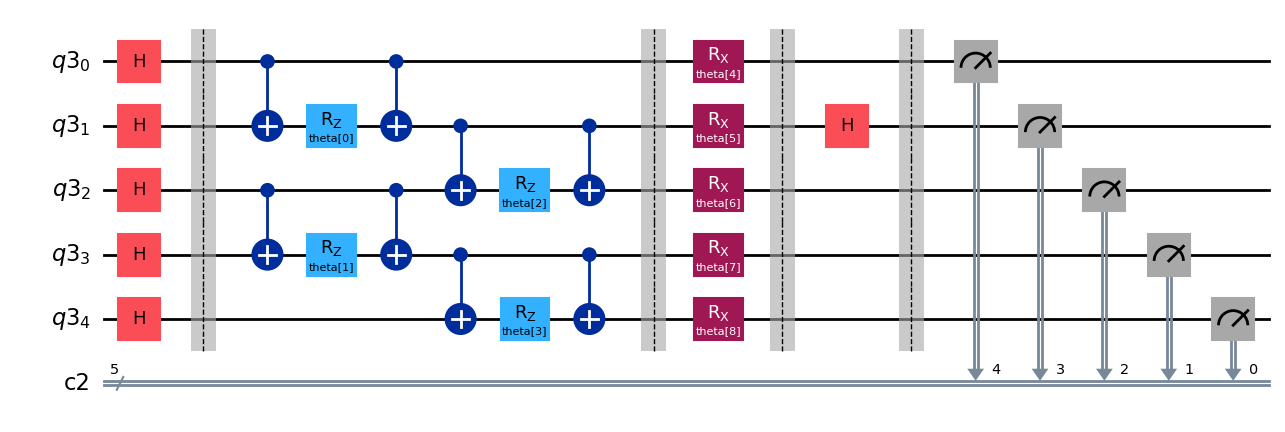

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

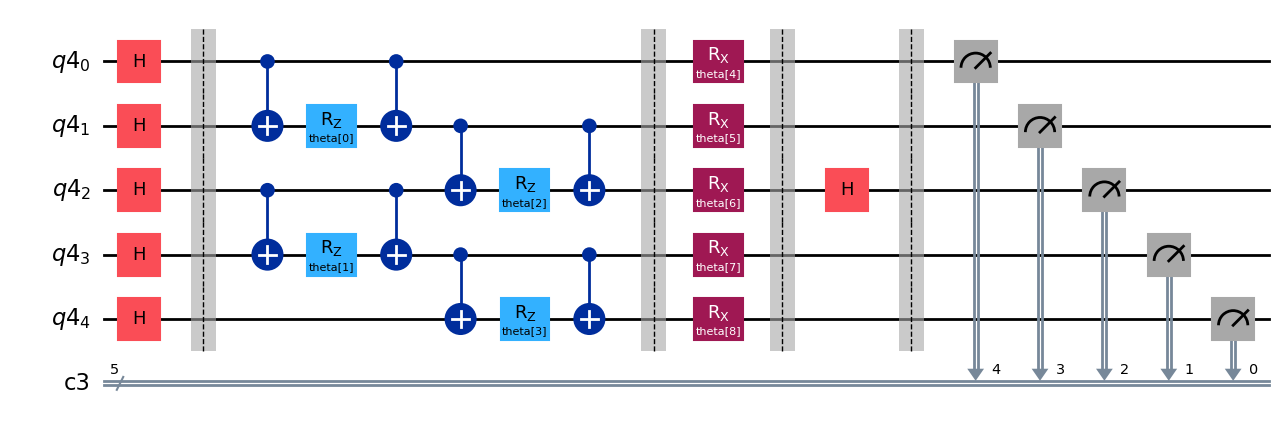

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

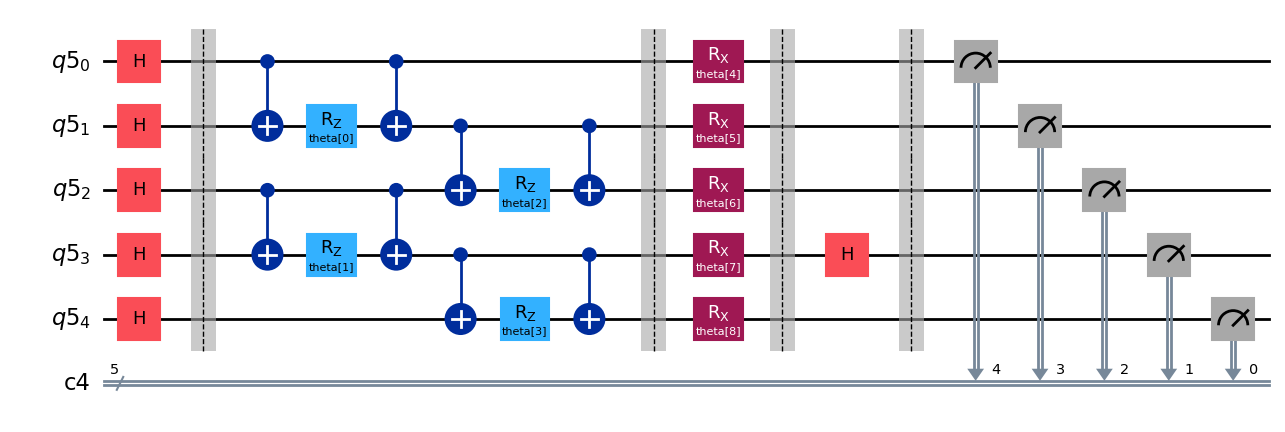

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

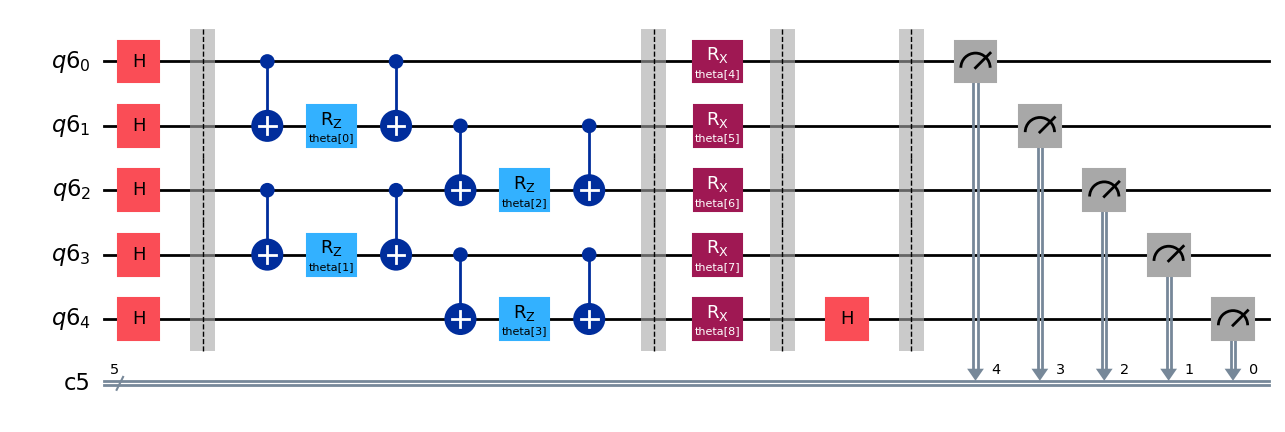

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


def cnn(a, b, c, x):
  lst = []
  lst.append(b*x[0]+c*x[1])
  lst.append(a*x[0]+b*x[1]+c*x[2])
  lst.append(a*x[1]+b*x[2]+c*x[3])
  lst.append(a*x[2]+b*x[3]+c*x[4])
  lst.append(a*x[3]+b*x[4])

  return np.array(lst)


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  FC1 = parameter[0:25]
  FC2 = parameter[25:30]
  c = parameter[30]

  FC1 = FC1.reshape(5,5)
  FC2 = FC2.reshape(1,5)

  a1 = np.matmul(FC1, x)
  z1 = relu(a1)

  a2 = np.matmul(FC2, z1)
  y = output_activate(c, a2)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=10000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1]

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=82), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=82), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

error rate : 0.0, lowest energy vqe : -5.831799999999999

error rate : 0.001, lowest energy vqe : -5.8191999999999995

error rate : 0.002, lowest energy vqe : -5.775000000000001

error rate : 0.003, lowest energy vqe : -5.782000000000001

error rate : 0.004, lowest energy vqe : -5.7467999999999995

error rate : 0.005, lowest energy vqe : -5.742000000000001

error rate : 0.006, lowest energy vqe : -5.6944

error rate : 0.007, lowest energy vqe : -5.709399999999999

error rate : 0.008, lowest energy vqe : -5.684400000000002

error rate : 0.009000000000000001, lowest energy vqe : -5.6546

error rate : 0.01, lowest energy vqe : -5.6246

error rate : 0.02, lowest energy vqe : -5.4496

error rate : 0.03, lowest energy vqe : -5.256800000000002

error rate : 0.04, lowest energy vqe : -5.056400000000001

error rate : 0.05, lowest energy vqe : -4.8721999999999985

error rate : 0.06, lowest energy vqe : -4.706800000000002

error rate : 0.07, lowest energy vqe : -4.576600000000001

error rate : 0.

In [ ]:
lowest_energy_vqe_list

[-5.831799999999999,
 -5.8191999999999995,
 -5.775000000000001,
 -5.782000000000001,
 -5.7467999999999995,
 -5.742000000000001,
 -5.6944,
 -5.709399999999999,
 -5.684400000000002,
 -5.6546,
 -5.6246,
 -5.4496,
 -5.256800000000002,
 -5.056400000000001,
 -4.8721999999999985,
 -4.706800000000002,
 -4.576600000000001,
 -4.430999999999998,
 -4.254599999999999,
 -4.114799999999999]

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=31), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=31), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()


  for k in range(num*100+10, num*100+20, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(31) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 300
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if local_minimum_dict[-1] < lowest_energy_vqnhe:
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

error rate : 0.0, lowest energy vqe : -5.831799999999999

Optimization terminated successfully.
         Current function value: -6.004784
         Iterations: 82
         Function evaluations: 2784
         Gradient evaluations: 87


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.003931
         Iterations: 154
         Function evaluations: 8556
         Gradient evaluations: 267


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.927758
         Iterations: 122
         Function evaluations: 6795
         Gradient evaluations: 212
Optimization terminated successfully.
         Current function value: -5.939194
         Iterations: 208
         Function evaluations: 7840
         Gradient evaluations: 245


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.016810
         Iterations: 221
         Function evaluations: 8800
         Gradient evaluations: 275


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.952731
         Iterations: 80
         Function evaluations: 7691
         Gradient evaluations: 240


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.944070
         Iterations: 300
         Function evaluations: 12864
         Gradient evaluations: 402
Optimization terminated successfully.
         Current function value: -5.950618
         Iterations: 152
         Function evaluations: 6336
         Gradient evaluations: 198


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.009845
         Iterations: 188
         Function evaluations: 10475
         Gradient evaluations: 327


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.992475
         Iterations: 300
         Function evaluations: 15040
         Gradient evaluations: 470
error rate : 0.0, lowest energy vqnhe : -6.016810277150228



error rate : 0.001, lowest energy vqe : -5.8191999999999995

         Current function value: -5.987465
         Iterations: 300
         Function evaluations: 14176
         Gradient evaluations: 443


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.976115
         Iterations: 117
         Function evaluations: 6502
         Gradient evaluations: 203


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.991393
         Iterations: 300
         Function evaluations: 15872
         Gradient evaluations: 496
Optimization terminated successfully.
         Current function value: -5.917169
         Iterations: 120
         Function evaluations: 4544
         Gradient evaluations: 142
         Current function value: -5.979523
         Iterations: 300
         Function evaluations: 13024
         Gradient evaluations: 407


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.985428
         Iterations: 117
         Function evaluations: 5578
         Gradient evaluations: 174


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.993446
         Iterations: 232
         Function evaluations: 11020
         Gradient evaluations: 344


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.958837
         Iterations: 104
         Function evaluations: 5484
         Gradient evaluations: 171
Optimization terminated successfully.
         Current function value: -5.918238
         Iterations: 93
         Function evaluations: 3808
         Gradient evaluations: 119


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.987207
         Iterations: 137
         Function evaluations: 6762
         Gradient evaluations: 211
error rate : 0.001, lowest energy vqnhe : -5.993445929692607



error rate : 0.002, lowest energy vqe : -5.775000000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.983269
         Iterations: 133
         Function evaluations: 7079
         Gradient evaluations: 221


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.012592
         Iterations: 300
         Function evaluations: 12480
         Gradient evaluations: 390


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.989294
         Iterations: 168
         Function evaluations: 9160
         Gradient evaluations: 286


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.838989
         Iterations: 70
         Function evaluations: 4904
         Gradient evaluations: 153


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.009351
         Iterations: 196
         Function evaluations: 13702
         Gradient evaluations: 428


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.955667
         Iterations: 145
         Function evaluations: 7264
         Gradient evaluations: 227


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.987242
         Iterations: 300
         Function evaluations: 12224
         Gradient evaluations: 382
Optimization terminated successfully.
         Current function value: -5.998896
         Iterations: 248
         Function evaluations: 9280
         Gradient evaluations: 290


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.010824
         Iterations: 180
         Function evaluations: 8331
         Gradient evaluations: 260


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.928891
         Iterations: 156
         Function evaluations: 9898
         Gradient evaluations: 309
error rate : 0.002, lowest energy vqnhe : -6.012591815389597



error rate : 0.003, lowest energy vqe : -5.782000000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.950474
         Iterations: 226
         Function evaluations: 11052
         Gradient evaluations: 345


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.913197
         Iterations: 44
         Function evaluations: 3015
         Gradient evaluations: 94


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.958281
         Iterations: 300
         Function evaluations: 12320
         Gradient evaluations: 385


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.794519
         Iterations: 6
         Function evaluations: 3084
         Gradient evaluations: 96
Optimization terminated successfully.
         Current function value: -5.958370
         Iterations: 165
         Function evaluations: 5504
         Gradient evaluations: 172


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.882057
         Iterations: 300
         Function evaluations: 13376
         Gradient evaluations: 418
         Current function value: -5.959096
         Iterations: 300
         Function evaluations: 11424
         Gradient evaluations: 357


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.952870
         Iterations: 151
         Function evaluations: 7530
         Gradient evaluations: 235


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.949357
         Iterations: 121
         Function evaluations: 6572
         Gradient evaluations: 205


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.955255
         Iterations: 173
         Function evaluations: 9708
         Gradient evaluations: 303
error rate : 0.003, lowest energy vqnhe : -5.959095768598058



error rate : 0.004, lowest energy vqe : -5.7467999999999995



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.909028
         Iterations: 300
         Function evaluations: 11424
         Gradient evaluations: 357


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.892768
         Iterations: 195
         Function evaluations: 7808
         Gradient evaluations: 244


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.900657
         Iterations: 300
         Function evaluations: 13792
         Gradient evaluations: 431


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.905168
         Iterations: 110
         Function evaluations: 6924
         Gradient evaluations: 216


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.904828
         Iterations: 300
         Function evaluations: 12544
         Gradient evaluations: 392
Optimization terminated successfully.
         Current function value: -5.810790
         Iterations: 85
         Function evaluations: 3168
         Gradient evaluations: 99
         Current function value: -5.871710
         Iterations: 300
         Function evaluations: 14464
         Gradient evaluations: 452


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.905535
         Iterations: 284
         Function evaluations: 13515
         Gradient evaluations: 422


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.885154
         Iterations: 174
         Function evaluations: 7648
         Gradient evaluations: 239


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.900848
         Iterations: 215
         Function evaluations: 10795
         Gradient evaluations: 337
error rate : 0.004, lowest energy vqnhe : -5.909027999679842



error rate : 0.005, lowest energy vqe : -5.742000000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.977925
         Iterations: 300
         Function evaluations: 11616
         Gradient evaluations: 363


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.950637
         Iterations: 105
         Function evaluations: 5129
         Gradient evaluations: 160


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.975976
         Iterations: 119
         Function evaluations: 6122
         Gradient evaluations: 191
Optimization terminated successfully.
         Current function value: -5.887694
         Iterations: 152
         Function evaluations: 7264
         Gradient evaluations: 227


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.982712
         Iterations: 300
         Function evaluations: 11584
         Gradient evaluations: 362
         Current function value: -5.981216
         Iterations: 300
         Function evaluations: 10752
         Gradient evaluations: 336


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.987107
         Iterations: 229
         Function evaluations: 10795
         Gradient evaluations: 337


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.939757
         Iterations: 300
         Function evaluations: 11936
         Gradient evaluations: 373


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.971180
         Iterations: 207
         Function evaluations: 8160
         Gradient evaluations: 255


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.983984
         Iterations: 249
         Function evaluations: 14020
         Gradient evaluations: 438
error rate : 0.005, lowest energy vqnhe : -5.987107360376306



error rate : 0.006, lowest energy vqe : -5.6944



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.694462
         Iterations: 2
         Function evaluations: 1732
         Gradient evaluations: 54


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.916291
         Iterations: 153
         Function evaluations: 9420
         Gradient evaluations: 294


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.883635
         Iterations: 107
         Function evaluations: 5931
         Gradient evaluations: 185


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.893039
         Iterations: 242
         Function evaluations: 15432
         Gradient evaluations: 482
Optimization terminated successfully.
         Current function value: -5.836749
         Iterations: 105
         Function evaluations: 4416
         Gradient evaluations: 138


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.889464
         Iterations: 300
         Function evaluations: 11808
         Gradient evaluations: 369


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.917036
         Iterations: 118
         Function evaluations: 4672
         Gradient evaluations: 146


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.895745
         Iterations: 300
         Function evaluations: 12832
         Gradient evaluations: 401


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.854487
         Iterations: 174
         Function evaluations: 10377
         Gradient evaluations: 324


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.900008
         Iterations: 300
         Function evaluations: 13824
         Gradient evaluations: 432
error rate : 0.006, lowest energy vqnhe : -5.917036036455259



error rate : 0.007, lowest energy vqe : -5.709399999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.918606
         Iterations: 194
         Function evaluations: 9484
         Gradient evaluations: 296


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.914814
         Iterations: 146
         Function evaluations: 7692
         Gradient evaluations: 240


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.906318
         Iterations: 147
         Function evaluations: 7040
         Gradient evaluations: 220
Optimization terminated successfully.
         Current function value: -5.758435
         Iterations: 82
         Function evaluations: 2816
         Gradient evaluations: 88


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.902753
         Iterations: 300
         Function evaluations: 12288
         Gradient evaluations: 384
         Current function value: -5.898296
         Iterations: 300
         Function evaluations: 12576
         Gradient evaluations: 393
         Current function value: -5.921805
         Iterations: 300
         Function evaluations: 12896
         Gradient evaluations: 403


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.834116
         Iterations: 118
         Function evaluations: 6540
         Gradient evaluations: 204


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.922397
         Iterations: 266
         Function evaluations: 12139
         Gradient evaluations: 379
Optimization terminated successfully.
         Current function value: -5.800655
         Iterations: 137
         Function evaluations: 6528
         Gradient evaluations: 204
error rate : 0.007, lowest energy vqnhe : -5.922397274809012



error rate : 0.008, lowest energy vqe : -5.684400000000002



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.803893
         Iterations: 127
         Function evaluations: 9094
         Gradient evaluations: 284


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.851807
         Iterations: 247
         Function evaluations: 14859
         Gradient evaluations: 464


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.857230
         Iterations: 245
         Function evaluations: 10667
         Gradient evaluations: 333


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.849149
         Iterations: 300
         Function evaluations: 12064
         Gradient evaluations: 377


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.842266
         Iterations: 162
         Function evaluations: 8492
         Gradient evaluations: 265


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.843977
         Iterations: 245
         Function evaluations: 14440
         Gradient evaluations: 451


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.833843
         Iterations: 254
         Function evaluations: 10848
         Gradient evaluations: 339


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.803848
         Iterations: 300
         Function evaluations: 13056
         Gradient evaluations: 408


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.836476
         Iterations: 182
         Function evaluations: 11884
         Gradient evaluations: 371


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.835793
         Iterations: 178
         Function evaluations: 8203
         Gradient evaluations: 256
error rate : 0.008, lowest energy vqnhe : -5.857229761262304



error rate : 0.009000000000000001, lowest energy vqe : -5.6546



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.841495
         Iterations: 155
         Function evaluations: 7884
         Gradient evaluations: 246


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.821779
         Iterations: 265
         Function evaluations: 16428
         Gradient evaluations: 513
Optimization terminated successfully.
         Current function value: -5.839629
         Iterations: 142
         Function evaluations: 4896
         Gradient evaluations: 153


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.840852
         Iterations: 252
         Function evaluations: 10976
         Gradient evaluations: 343
Optimization terminated successfully.
         Current function value: -5.834423
         Iterations: 141
         Function evaluations: 5920
         Gradient evaluations: 185
Optimization terminated successfully.
         Current function value: -5.760576
         Iterations: 134
         Function evaluations: 5408
         Gradient evaluations: 169


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.788668
         Iterations: 155
         Function evaluations: 8748
         Gradient evaluations: 273


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.791790
         Iterations: 172
         Function evaluations: 7718
         Gradient evaluations: 241


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.827276
         Iterations: 145
         Function evaluations: 8268
         Gradient evaluations: 258
Optimization terminated successfully.
         Current function value: -5.788337
         Iterations: 69
         Function evaluations: 2464
         Gradient evaluations: 77
error rate : 0.009000000000000001, lowest energy vqnhe : -5.841494889534196



error rate : 0.01, lowest energy vqe : -5.6246



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.796173
         Iterations: 76
         Function evaluations: 4935
         Gradient evaluations: 154


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.797782
         Iterations: 249
         Function evaluations: 13100
         Gradient evaluations: 409


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.791856
         Iterations: 300
         Function evaluations: 13728
         Gradient evaluations: 429


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.803214
         Iterations: 153
         Function evaluations: 9381
         Gradient evaluations: 293


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.810582
         Iterations: 300
         Function evaluations: 14976
         Gradient evaluations: 468


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.801589
         Iterations: 200
         Function evaluations: 9191
         Gradient evaluations: 287


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.796633
         Iterations: 265
         Function evaluations: 12812
         Gradient evaluations: 400


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.809051
         Iterations: 300
         Function evaluations: 14048
         Gradient evaluations: 439


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.791724
         Iterations: 162
         Function evaluations: 11276
         Gradient evaluations: 352


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.807917
         Iterations: 89
         Function evaluations: 4908
         Gradient evaluations: 153
error rate : 0.01, lowest energy vqnhe : -5.8105821583220525



error rate : 0.02, lowest energy vqe : -5.4496



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.687281
         Iterations: 130
         Function evaluations: 7941
         Gradient evaluations: 248


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.687746
         Iterations: 300
         Function evaluations: 13184
         Gradient evaluations: 412


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.679840
         Iterations: 176
         Function evaluations: 8871
         Gradient evaluations: 277


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.651836
         Iterations: 177
         Function evaluations: 8616
         Gradient evaluations: 269


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.674844
         Iterations: 74
         Function evaluations: 6086
         Gradient evaluations: 190


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.678134
         Iterations: 188
         Function evaluations: 10312
         Gradient evaluations: 322


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.590757
         Iterations: 64
         Function evaluations: 5893
         Gradient evaluations: 184
Optimization terminated successfully.
         Current function value: -5.505818
         Iterations: 72
         Function evaluations: 4288
         Gradient evaluations: 134


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.653318
         Iterations: 51
         Function evaluations: 3878
         Gradient evaluations: 121


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.692371
         Iterations: 200
         Function evaluations: 11628
         Gradient evaluations: 363
error rate : 0.02, lowest energy vqnhe : -5.692370916403381



error rate : 0.03, lowest energy vqe : -5.256800000000002

Optimization terminated successfully.
         Current function value: -5.569566
         Iterations: 151
         Function evaluations: 5472
         Gradient evaluations: 171


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.484393
         Iterations: 189
         Function evaluations: 10924
         Gradient evaluations: 341


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.567749
         Iterations: 300
         Function evaluations: 14336
         Gradient evaluations: 448


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.562695
         Iterations: 163
         Function evaluations: 11276
         Gradient evaluations: 352


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.566582
         Iterations: 102
         Function evaluations: 4640
         Gradient evaluations: 145


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.532760
         Iterations: 300
         Function evaluations: 12512
         Gradient evaluations: 391


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.486350
         Iterations: 160
         Function evaluations: 8201
         Gradient evaluations: 256
Optimization terminated successfully.
         Current function value: -5.481217
         Iterations: 112
         Function evaluations: 4832
         Gradient evaluations: 151


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.566094
         Iterations: 203
         Function evaluations: 9804
         Gradient evaluations: 306


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.375342
         Iterations: 194
         Function evaluations: 11087
         Gradient evaluations: 346
error rate : 0.03, lowest energy vqnhe : -5.569565571660491



error rate : 0.04, lowest energy vqe : -5.056400000000001

Optimization terminated successfully.
         Current function value: -5.406280
         Iterations: 209
         Function evaluations: 10785
         Gradient evaluations: 337


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.186635
         Iterations: 55
         Function evaluations: 5740
         Gradient evaluations: 179


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.397456
         Iterations: 281
         Function evaluations: 13705
         Gradient evaluations: 428
Optimization terminated successfully.
         Current function value: -5.127045
         Iterations: 186
         Function evaluations: 8544
         Gradient evaluations: 267
Optimization terminated successfully.
         Current function value: -5.237900
         Iterations: 207
         Function evaluations: 11616
         Gradient evaluations: 363


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.119312
         Iterations: 94
         Function evaluations: 5388
         Gradient evaluations: 168


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.403480
         Iterations: 252
         Function evaluations: 11392
         Gradient evaluations: 356


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.405543
         Iterations: 300
         Function evaluations: 12960
         Gradient evaluations: 405
Optimization terminated successfully.
         Current function value: -5.184419
         Iterations: 129
         Function evaluations: 6592
         Gradient evaluations: 206


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.401993
         Iterations: 218
         Function evaluations: 8844
         Gradient evaluations: 276
error rate : 0.04, lowest energy vqnhe : -5.406280078842187



error rate : 0.05, lowest energy vqe : -4.8721999999999985



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.359564
         Iterations: 282
         Function evaluations: 14784
         Gradient evaluations: 462


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.367122
         Iterations: 199
         Function evaluations: 11168
         Gradient evaluations: 349


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.396340
         Iterations: 300
         Function evaluations: 12224
         Gradient evaluations: 382


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.313988
         Iterations: 41
         Function evaluations: 3078
         Gradient evaluations: 96


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.384467
         Iterations: 300
         Function evaluations: 14080
         Gradient evaluations: 440
Optimization terminated successfully.
         Current function value: -4.946605
         Iterations: 56
         Function evaluations: 2016
         Gradient evaluations: 63


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.320557
         Iterations: 106
         Function evaluations: 6027
         Gradient evaluations: 188


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.309957
         Iterations: 300
         Function evaluations: 12640
         Gradient evaluations: 395
Optimization terminated successfully.
         Current function value: -5.346774
         Iterations: 39
         Function evaluations: 1472
         Gradient evaluations: 46
         Current function value: -5.376679
         Iterations: 300
         Function evaluations: 13216
         Gradient evaluations: 413
error rate : 0.05, lowest energy vqnhe : -5.396340270045532



error rate : 0.06, lowest energy vqe : -4.706800000000002



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.974623
         Iterations: 256
         Function evaluations: 14406
         Gradient evaluations: 450


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.218012
         Iterations: 300
         Function evaluations: 11648
         Gradient evaluations: 364
Optimization terminated successfully.
         Current function value: -5.245673
         Iterations: 110
         Function evaluations: 4064
         Gradient evaluations: 127
         Current function value: -5.199103
         Iterations: 300
         Function evaluations: 14112
         Gradient evaluations: 441
         Current function value: -5.225961
         Iterations: 300
         Function evaluations: 11264
         Gradient evaluations: 352
         Current function value: -5.169407
         Iterations: 300
         Function evaluations: 17888
         Gradient evaluations: 559
Optimization terminated successfully.
         Current function value: -4.773537
         Iterations: 102
         Function evaluations: 3648
         Gradient evaluations: 114
         Current function value: -5.237629
         Iterations: 300
         Function 

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.977625
         Iterations: 41
         Function evaluations: 3690
         Gradient evaluations: 115


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.190988
         Iterations: 123
         Function evaluations: 7180
         Gradient evaluations: 224
error rate : 0.06, lowest energy vqnhe : -5.245672828163454



error rate : 0.07, lowest energy vqe : -4.576600000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.127998
         Iterations: 175
         Function evaluations: 9642
         Gradient evaluations: 301


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.087322
         Iterations: 182
         Function evaluations: 9938
         Gradient evaluations: 310


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.945553
         Iterations: 206
         Function evaluations: 13868
         Gradient evaluations: 433


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.178612
         Iterations: 154
         Function evaluations: 8588
         Gradient evaluations: 268


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.192263
         Iterations: 300
         Function evaluations: 13952
         Gradient evaluations: 436


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.116511
         Iterations: 45
         Function evaluations: 4172
         Gradient evaluations: 130


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.106386
         Iterations: 176
         Function evaluations: 9644
         Gradient evaluations: 301


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.157193
         Iterations: 300
         Function evaluations: 12480
         Gradient evaluations: 390
Optimization terminated successfully.
         Current function value: -5.113668
         Iterations: 107
         Function evaluations: 3744
         Gradient evaluations: 117


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.027863
         Iterations: 209
         Function evaluations: 11271
         Gradient evaluations: 352
error rate : 0.07, lowest energy vqnhe : -5.192263034610052



error rate : 0.08, lowest energy vqe : -4.430999999999998

Optimization terminated successfully.
         Current function value: -4.579489
         Iterations: 56
         Function evaluations: 2016
         Gradient evaluations: 63


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.812540
         Iterations: 118
         Function evaluations: 8293
         Gradient evaluations: 259


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.024736
         Iterations: 95
         Function evaluations: 7975
         Gradient evaluations: 249


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.163134
         Iterations: 52
         Function evaluations: 4204
         Gradient evaluations: 131


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.136310
         Iterations: 300
         Function evaluations: 11648
         Gradient evaluations: 364
         Current function value: -5.138430
         Iterations: 300
         Function evaluations: 11104
         Gradient evaluations: 347


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.087306
         Iterations: 218
         Function evaluations: 11462
         Gradient evaluations: 358
Optimization terminated successfully.
         Current function value: -4.747034
         Iterations: 71
         Function evaluations: 4512
         Gradient evaluations: 141
Optimization terminated successfully.
         Current function value: -4.599573
         Iterations: 178
         Function evaluations: 9184
         Gradient evaluations: 287


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.153846
         Iterations: 262
         Function evaluations: 11914
         Gradient evaluations: 372
error rate : 0.08, lowest energy vqnhe : -5.16313359541295



error rate : 0.09, lowest energy vqe : -4.254599999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.955791
         Iterations: 300
         Function evaluations: 12736
         Gradient evaluations: 398
         Current function value: -4.994550
         Iterations: 300
         Function evaluations: 12608
         Gradient evaluations: 394
         Current function value: -5.011734
         Iterations: 300
         Function evaluations: 13760
         Gradient evaluations: 430
         Current function value: -4.948532
         Iterations: 300
         Function evaluations: 10944
         Gradient evaluations: 342


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.028445
         Iterations: 184
         Function evaluations: 8779
         Gradient evaluations: 274


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.971662
         Iterations: 255
         Function evaluations: 13100
         Gradient evaluations: 409


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.028304
         Iterations: 300
         Function evaluations: 10912
         Gradient evaluations: 341


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.032879
         Iterations: 110
         Function evaluations: 5572
         Gradient evaluations: 174


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.022429
         Iterations: 300
         Function evaluations: 13152
         Gradient evaluations: 411


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.985514
         Iterations: 246
         Function evaluations: 12872
         Gradient evaluations: 402
error rate : 0.09, lowest energy vqnhe : -5.032879195310073



error rate : 0.1, lowest energy vqe : -4.114799999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.532301
         Iterations: 300
         Function evaluations: 15648
         Gradient evaluations: 489


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.919126
         Iterations: 137
         Function evaluations: 7465
         Gradient evaluations: 233


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.907353
         Iterations: 225
         Function evaluations: 10442
         Gradient evaluations: 326


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.940800
         Iterations: 135
         Function evaluations: 6272
         Gradient evaluations: 196


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.978092
         Iterations: 300
         Function evaluations: 11456
         Gradient evaluations: 358


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.891284
         Iterations: 263
         Function evaluations: 14348
         Gradient evaluations: 448


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.504413
         Iterations: 56
         Function evaluations: 4646
         Gradient evaluations: 145


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.911056
         Iterations: 273
         Function evaluations: 15276
         Gradient evaluations: 477


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.903781
         Iterations: 71
         Function evaluations: 4869
         Gradient evaluations: 152
         Current function value: -4.974572
         Iterations: 260
         Function evaluations: 12681
         Gradient evaluations: 396
error rate : 0.1, lowest energy vqnhe : -4.978091901266644





/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [ ]:
lowest_energy_vqnhe_list

[-6.016810277150228,
 -5.993445929692607,
 -6.012591815389597,
 -5.959095768598058,
 -5.909027999679842,
 -5.987107360376306,
 -5.917036036455259,
 -5.922397274809012,
 -5.857229761262304,
 -5.841494889534196,
 -5.8105821583220525,
 -5.692370916403381,
 -5.569565571660491,
 -5.406280078842187,
 -5.396340270045532,
 -5.245672828163454,
 -5.192263034610052,
 -5.16313359541295,
 -5.032879195310073,
 -4.978091901266644]

## Depolarization Channel, Error 0.001~0.1, Shots = 10000, FC Hidden Layer 2개

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

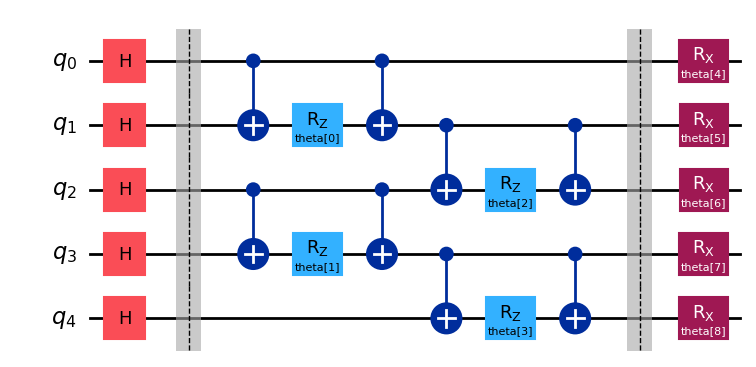

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

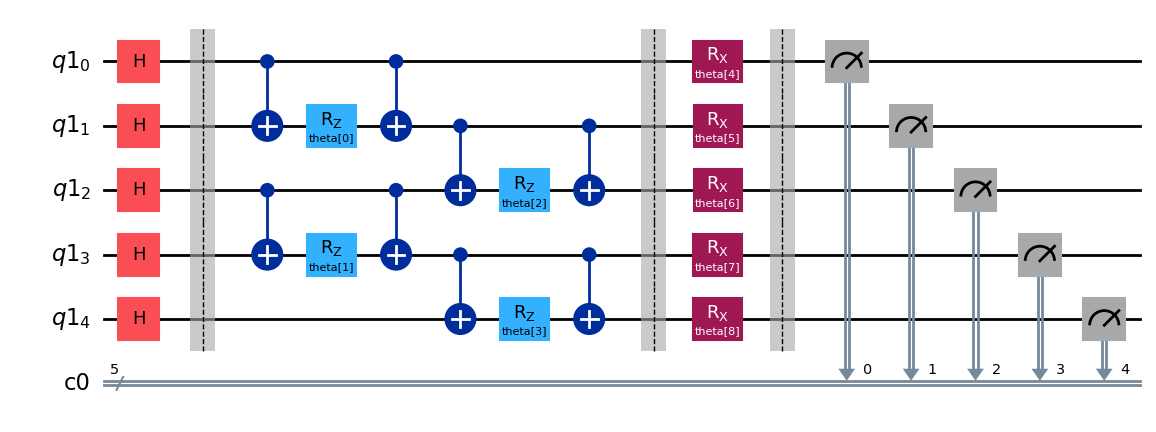

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

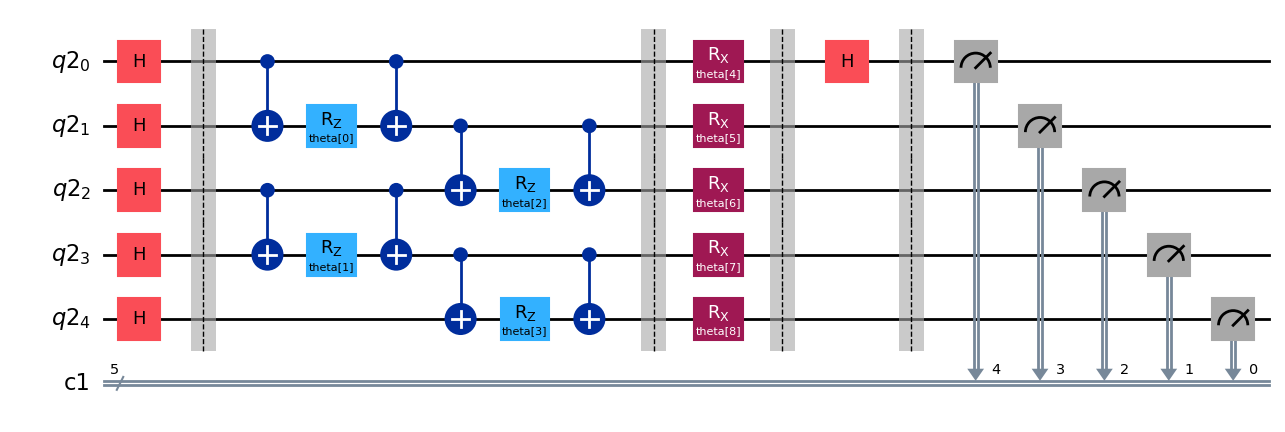

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

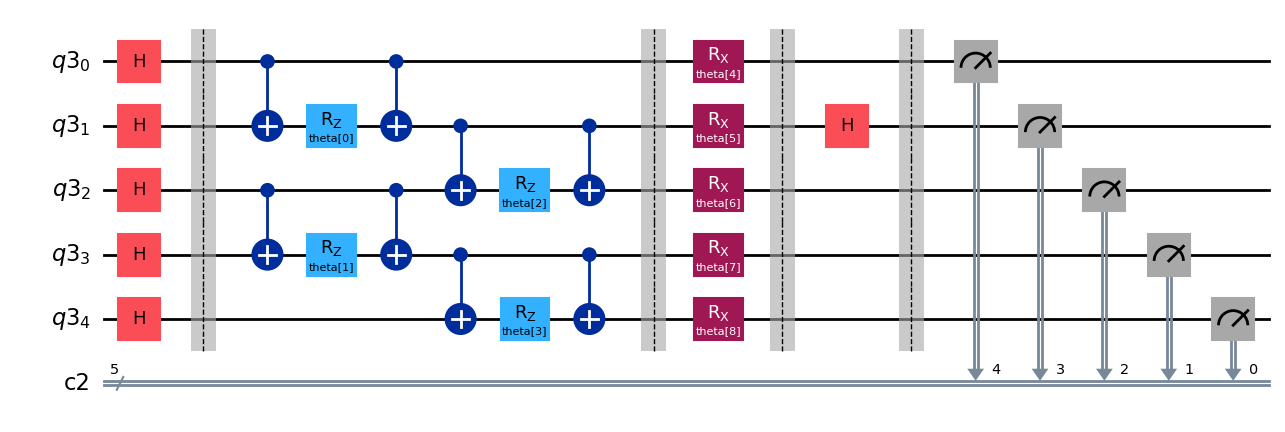

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

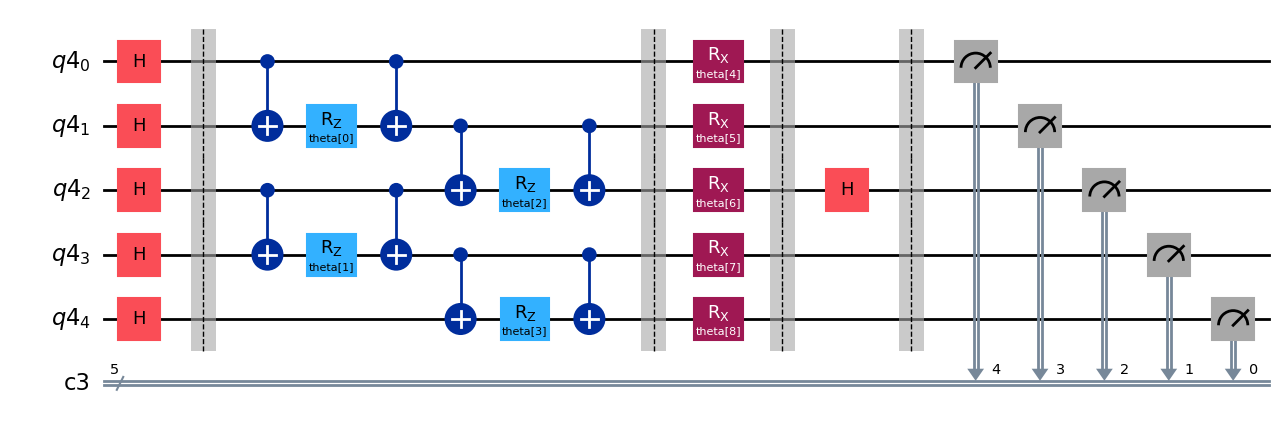

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

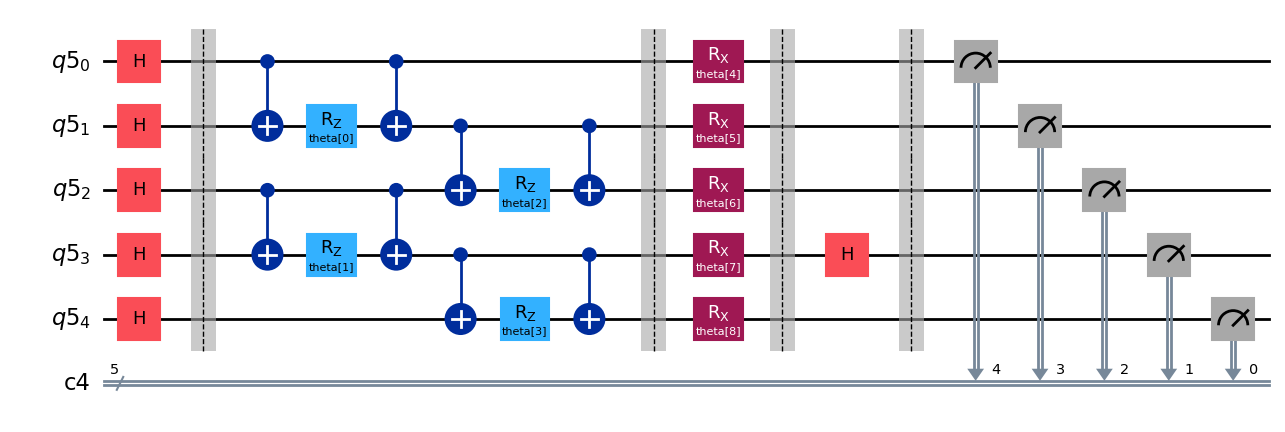

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

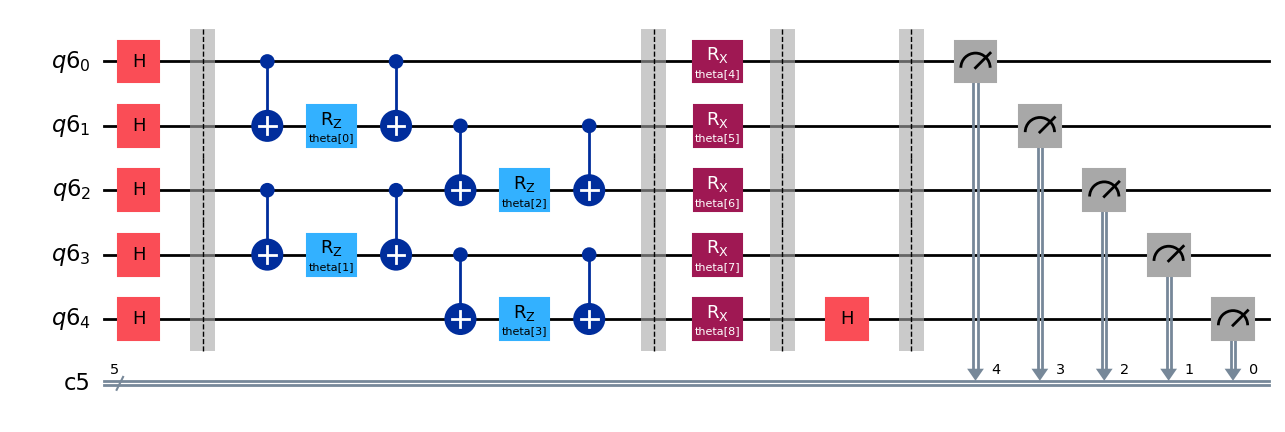

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  W1 = parameter[0:25]
  W2 = parameter[25:50]
  W3 = parameter[50:75]
  c = parameter[75]

  W1 = W1.reshape(5,5)
  W2 = W2.reshape(5,5)
  W3 = W3.reshape(5,5)

  a1 = np.matmul(W1, x)
  z1 = relu(a1)

  a2 = np.matmul(W2, z1)
  z2 = relu(a2)

  a3 = np.matmul(W3, z2)
  y = output_activate(c, a3)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=100000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=100000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1]

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=76), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=76), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

error rate : 0.0, lowest energy vqe : -5.831799999999999

error rate : 0.001, lowest energy vqe : -5.8191999999999995

error rate : 0.002, lowest energy vqe : -5.775000000000001

error rate : 0.003, lowest energy vqe : -5.782000000000001

error rate : 0.004, lowest energy vqe : -5.7467999999999995

error rate : 0.005, lowest energy vqe : -5.742000000000001

error rate : 0.006, lowest energy vqe : -5.6944

error rate : 0.007, lowest energy vqe : -5.709399999999999

error rate : 0.008, lowest energy vqe : -5.684400000000002

error rate : 0.009000000000000001, lowest energy vqe : -5.6546

error rate : 0.01, lowest energy vqe : -5.6246

error rate : 0.02, lowest energy vqe : -5.4496

error rate : 0.03, lowest energy vqe : -5.256800000000002

error rate : 0.04, lowest energy vqe : -5.056400000000001

error rate : 0.05, lowest energy vqe : -4.8721999999999985

error rate : 0.06, lowest energy vqe : -4.706800000000002

error rate : 0.07, lowest energy vqe : -4.576600000000001

error rate : 0.

In [ ]:
lowest_energy_vqe_list

[-5.831799999999999,
 -5.8191999999999995,
 -5.775000000000001,
 -5.782000000000001,
 -5.7467999999999995,
 -5.742000000000001,
 -5.6944,
 -5.709399999999999,
 -5.684400000000002,
 -5.6546,
 -5.6246,
 -5.4496,
 -5.256800000000002,
 -5.056400000000001,
 -4.8721999999999985,
 -4.706800000000002,
 -4.576600000000001,
 -4.430999999999998,
 -4.254599999999999,
 -4.114799999999999]

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=76), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=76), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+20, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(76) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 200
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if local_minimum_dict[-1] < lowest_energy_vqnhe:
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

error rate : 0.0, lowest energy vqe : -5.831799999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.016911
         Iterations: 200
         Function evaluations: 20251
         Gradient evaluations: 263
Optimization terminated successfully.
         Current function value: -5.858540
         Iterations: 92
         Function evaluations: 8701
         Gradient evaluations: 113
         Current function value: -5.947324
         Iterations: 200
         Function evaluations: 18865
         Gradient evaluations: 245


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.011483
         Iterations: 154
         Function evaluations: 19647
         Gradient evaluations: 255


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.001949
         Iterations: 91
         Function evaluations: 14026
         Gradient evaluations: 182


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.973570
         Iterations: 200
         Function evaluations: 23100
         Gradient evaluations: 300
         Current function value: -6.004056
         Iterations: 200
         Function evaluations: 17633
         Gradient evaluations: 229
         Current function value: -6.010048
         Iterations: 200
         Function evaluations: 21791
         Gradient evaluations: 283
         Current function value: -6.004172
         Iterations: 200
         Function evaluations: 19327
         Gradient evaluations: 251


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.000299
         Iterations: 167
         Function evaluations: 20950
         Gradient evaluations: 272


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.007599
         Iterations: 200
         Function evaluations: 18711
         Gradient evaluations: 243
         Current function value: -5.993138
         Iterations: 200
         Function evaluations: 19327
         Gradient evaluations: 251


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.933075
         Iterations: 37
         Function evaluations: 7481
         Gradient evaluations: 97


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.007897
         Iterations: 200
         Function evaluations: 21252
         Gradient evaluations: 276
         Current function value: -6.017371
         Iterations: 200
         Function evaluations: 17710
         Gradient evaluations: 230


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.947731
         Iterations: 106
         Function evaluations: 20648
         Gradient evaluations: 268


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.948797
         Iterations: 127
         Function evaluations: 19563
         Gradient evaluations: 254


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.012360
         Iterations: 200
         Function evaluations: 18326
         Gradient evaluations: 238
         Current function value: -6.008396
         Iterations: 200
         Function evaluations: 22099
         Gradient evaluations: 287
         Current function value: -6.001598
         Iterations: 200
         Function evaluations: 23485
         Gradient evaluations: 305
error rate : 0.0, lowest energy vqnhe : -6.0173706367674225



error rate : 0.001, lowest energy vqe : -5.8191999999999995

         Current function value: -5.989320
         Iterations: 200
         Function evaluations: 18711
         Gradient evaluations: 243
Optimization terminated successfully.
         Current function value: -5.871625
         Iterations: 95
         Function evaluations: 15631
         Gradient evaluations: 203
         Current function value: -5.987592
         Iterations: 200
         Function evaluations: 16555
         Gradient evaluations: 215

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.962821
         Iterations: 54
         Function evaluations: 9559
         Gradient evaluations: 124


<ipython-input-14-e5dda20ba8ec>:8: RuntimeWarning: overflow encountered in exp
  return np.exp(c*np.tanh(x))
<ipython-input-17-942dbc8389c9>:11: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-17-942dbc8389c9>:26: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-17-942dbc8389c9>:41: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-17-942dbc8389c9>:54: RuntimeWarning: invalid value encountered in scalar add
  expval = expval + prob_string[k]*nnval[k]
<ipython-input-17-942dbc8389c9>:69: RuntimeWarning: invalid value encountered in scalar multiply
  expval = expval + delt*nnval[k]*nnval[k+16]
<ipython-input-17-942dbc8389c9>:86: RuntimeWarning: invalid value encountered in scalar multiply
  expval = expval + delt*nnval[k]*nnval[k+8]
<ipython-input-17-942dbc8389c9>:111: RuntimeWar

         Current function value: nan
         Iterations: 137
         Function evaluations: 24409
         Gradient evaluations: 317


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.944494
         Iterations: 160
         Function evaluations: 19258
         Gradient evaluations: 250


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.970060
         Iterations: 85
         Function evaluations: 10945
         Gradient evaluations: 142


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.920685
         Iterations: 123
         Function evaluations: 16641
         Gradient evaluations: 216


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.969675
         Iterations: 200
         Function evaluations: 19404
         Gradient evaluations: 252


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.969648
         Iterations: 193
         Function evaluations: 22650
         Gradient evaluations: 294


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.973884
         Iterations: 200
         Function evaluations: 23793
         Gradient evaluations: 309


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.993314
         Iterations: 167
         Function evaluations: 19335
         Gradient evaluations: 251


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.985860
         Iterations: 200
         Function evaluations: 20636
         Gradient evaluations: 268


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.984256
         Iterations: 154
         Function evaluations: 23034
         Gradient evaluations: 299


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.931325
         Iterations: 79
         Function evaluations: 15946
         Gradient evaluations: 207


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.982560
         Iterations: 200
         Function evaluations: 17402
         Gradient evaluations: 226
         Current function value: -5.984075
         Iterations: 200
         Function evaluations: 20251
         Gradient evaluations: 263
         Current function value: -5.987427
         Iterations: 200
         Function evaluations: 17941
         Gradient evaluations: 233
Optimization terminated successfully.
         Current function value: -5.819594
         Iterations: 5
         Function evaluations: 539
         Gradient evaluations: 7
error rate : 0.001, lowest energy vqnhe : -5.993313911187684



error rate : 0.002, lowest energy vqe : -5.775000000000001

Optimization terminated successfully.
         Current function value: -5.965747
         Iterations: 183
         Function evaluations: 16016
         Gradient evaluations: 208


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.904327
         Iterations: 91
         Function evaluations: 18723
         Gradient evaluations: 243


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.008383
         Iterations: 194
         Function evaluations: 27110
         Gradient evaluations: 352


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.011223
         Iterations: 200
         Function evaluations: 17479
         Gradient evaluations: 227
         Current function value: -5.989217
         Iterations: 200
         Function evaluations: 18557
         Gradient evaluations: 241
         Current function value: -5.929576
         Iterations: 200
         Function evaluations: 20713
         Gradient evaluations: 269
         Current function value: -6.005179
         Iterations: 200
         Function evaluations: 19635
         Gradient evaluations: 255


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.001492
         Iterations: 164
         Function evaluations: 19793
         Gradient evaluations: 257


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.991037
         Iterations: 200
         Function evaluations: 21791
         Gradient evaluations: 283


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.989178
         Iterations: 24
         Function evaluations: 7633
         Gradient evaluations: 99


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.998286
         Iterations: 200
         Function evaluations: 18249
         Gradient evaluations: 237
         Current function value: -6.008645
         Iterations: 200
         Function evaluations: 16863
         Gradient evaluations: 219
         Current function value: -5.959829
         Iterations: 200
         Function evaluations: 20559
         Gradient evaluations: 267
         Current function value: -5.961617
         Iterations: 200
         Function evaluations: 20405
         Gradient evaluations: 265


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.873786
         Iterations: 160
         Function evaluations: 28036
         Gradient evaluations: 364


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.989362
         Iterations: 200
         Function evaluations: 20790
         Gradient evaluations: 270
         Current function value: -6.011529
         Iterations: 200
         Function evaluations: 22869
         Gradient evaluations: 297
         Current function value: -6.012983
         Iterations: 200
         Function evaluations: 17556
         Gradient evaluations: 228
         Current function value: -5.993830
         Iterations: 200
         Function evaluations: 17633
         Gradient evaluations: 229
         Current function value: -5.976523
         Iterations: 200
         Function evaluations: 21560
         Gradient evaluations: 280
error rate : 0.002, lowest energy vqnhe : -6.012982704979324



error rate : 0.003, lowest energy vqe : -5.782000000000001

         Current function value: -5.953604
         Iterations: 200
         Function evaluations: 19327
         Gradient evaluations: 251
         Current function value: -5.

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.917610
         Iterations: 180
         Function evaluations: 24112
         Gradient evaluations: 313


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.907059
         Iterations: 97
         Function evaluations: 19413
         Gradient evaluations: 252


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.955885
         Iterations: 200
         Function evaluations: 26334
         Gradient evaluations: 342
         Current function value: -5.950237
         Iterations: 200
         Function evaluations: 18326
         Gradient evaluations: 238


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.940148
         Iterations: 161
         Function evaluations: 20647
         Gradient evaluations: 268


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.881269
         Iterations: 113
         Function evaluations: 16259
         Gradient evaluations: 211


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.944238
         Iterations: 111
         Function evaluations: 11088
         Gradient evaluations: 144


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.931678
         Iterations: 95
         Function evaluations: 15790
         Gradient evaluations: 205


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.955838
         Iterations: 111
         Function evaluations: 14796
         Gradient evaluations: 192


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.833863
         Iterations: 115
         Function evaluations: 17791
         Gradient evaluations: 231


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.959515
         Iterations: 200
         Function evaluations: 18403
         Gradient evaluations: 239
         Current function value: -5.956533
         Iterations: 200
         Function evaluations: 19173
         Gradient evaluations: 249
         Current function value: -5.957408
         Iterations: 200
         Function evaluations: 17479
         Gradient evaluations: 227
         Current function value: -5.956723
         Iterations: 200
         Function evaluations: 18942
         Gradient evaluations: 246


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.909343
         Iterations: 57
         Function evaluations: 9551
         Gradient evaluations: 124
error rate : 0.003, lowest energy vqnhe : -5.959514687263201



error rate : 0.004, lowest energy vqe : -5.7467999999999995



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.911267
         Iterations: 200
         Function evaluations: 18018
         Gradient evaluations: 234


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.899742
         Iterations: 64
         Function evaluations: 10253
         Gradient evaluations: 133


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.863159
         Iterations: 23
         Function evaluations: 5241
         Gradient evaluations: 68


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.879460
         Iterations: 200
         Function evaluations: 19558
         Gradient evaluations: 254


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.753649
         Iterations: 3
         Function evaluations: 4863
         Gradient evaluations: 63


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.891669
         Iterations: 60
         Function evaluations: 9560
         Gradient evaluations: 124


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.910543
         Iterations: 200
         Function evaluations: 17633
         Gradient evaluations: 229


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.899554
         Iterations: 170
         Function evaluations: 17260
         Gradient evaluations: 224


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.910691
         Iterations: 200
         Function evaluations: 16786
         Gradient evaluations: 218
         Current function value: -5.896111
         Iterations: 200
         Function evaluations: 18095
         Gradient evaluations: 235
Optimization terminated successfully.
         Current function value: -5.835636
         Iterations: 77
         Function evaluations: 6622
         Gradient evaluations: 86
         Current function value: -5.906503
         Iterations: 200
         Function evaluations: 16324
         Gradient evaluations: 212
         Current function value: -5.900697
         Iterations: 200
         Function evaluations: 18018
         Gradient evaluations: 234
         Current function value: -5.811594
         Iterations: 200
         Function evaluations: 20328
         Gradient evaluations: 264
         Current function value: -5.901327
         Iterations: 200
         Function evaluations: 18095
         Gradient ev

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.839565
         Iterations: 25
         Function evaluations: 7012
         Gradient evaluations: 91


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.895065
         Iterations: 200
         Function evaluations: 18942
         Gradient evaluations: 246
error rate : 0.004, lowest energy vqnhe : -5.911266723444214



error rate : 0.005, lowest energy vqe : -5.742000000000001

Optimization terminated successfully.
         Current function value: -5.797377
         Iterations: 43
         Function evaluations: 3927
         Gradient evaluations: 51
         Current function value: -5.986228
         Iterations: 200
         Function evaluations: 18326
         Gradient evaluations: 238


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.964764
         Iterations: 154
         Function evaluations: 20487
         Gradient evaluations: 266


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.966221
         Iterations: 179
         Function evaluations: 18644
         Gradient evaluations: 242


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.954544
         Iterations: 200
         Function evaluations: 21945
         Gradient evaluations: 285
         Current function value: -5.990989
         Iterations: 200
         Function evaluations: 18480
         Gradient evaluations: 240
         Current function value: -5.933533
         Iterations: 200
         Function evaluations: 22330
         Gradient evaluations: 290
Optimization terminated successfully.
         Current function value: -5.892943
         Iterations: 110
         Function evaluations: 9240
         Gradient evaluations: 120
         Current function value: -5.981559
         Iterations: 200
         Function evaluations: 19250
         Gradient evaluations: 250
         Current function value: -5.973504
         Iterations: 200
         Function evaluations: 16863
         Gradient evaluations: 219


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.977822
         Iterations: 79
         Function evaluations: 10403
         Gradient evaluations: 135
Optimization terminated successfully.
         Current function value: -5.946090
         Iterations: 174
         Function evaluations: 15323
         Gradient evaluations: 199


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.971389
         Iterations: 145
         Function evaluations: 21337
         Gradient evaluations: 277


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.902528
         Iterations: 134
         Function evaluations: 18183
         Gradient evaluations: 236


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.985763
         Iterations: 200
         Function evaluations: 17941
         Gradient evaluations: 233
Optimization terminated successfully.
         Current function value: -5.981579
         Iterations: 142
         Function evaluations: 12474
         Gradient evaluations: 162
         Current function value: -5.980423
         Iterations: 200
         Function evaluations: 21791
         Gradient evaluations: 283


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.900128
         Iterations: 64
         Function evaluations: 13946
         Gradient evaluations: 181


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.962893
         Iterations: 200
         Function evaluations: 25718
         Gradient evaluations: 334


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.894841
         Iterations: 126
         Function evaluations: 15643
         Gradient evaluations: 203
error rate : 0.005, lowest energy vqnhe : -5.990989291432052



error rate : 0.006, lowest energy vqe : -5.6944



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.899667
         Iterations: 200
         Function evaluations: 25718
         Gradient evaluations: 334


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.892306
         Iterations: 115
         Function evaluations: 17870
         Gradient evaluations: 232


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.920822
         Iterations: 200
         Function evaluations: 17710
         Gradient evaluations: 230


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.892594
         Iterations: 140
         Function evaluations: 18569
         Gradient evaluations: 241


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.853038
         Iterations: 200
         Function evaluations: 18865
         Gradient evaluations: 245


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.887816
         Iterations: 89
         Function evaluations: 10861
         Gradient evaluations: 141


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.907645
         Iterations: 200
         Function evaluations: 18480
         Gradient evaluations: 240
         Current function value: -5.857255
         Iterations: 200
         Function evaluations: 19250
         Gradient evaluations: 250


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.891755
         Iterations: 52
         Function evaluations: 12248
         Gradient evaluations: 159


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.913992
         Iterations: 200
         Function evaluations: 18095
         Gradient evaluations: 235
         Current function value: -5.921411
         Iterations: 200
         Function evaluations: 17864
         Gradient evaluations: 232


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.913484
         Iterations: 186
         Function evaluations: 20027
         Gradient evaluations: 260


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.913901
         Iterations: 200
         Function evaluations: 23793
         Gradient evaluations: 309


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.913881
         Iterations: 162
         Function evaluations: 22265
         Gradient evaluations: 289


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.908563
         Iterations: 200
         Function evaluations: 17633
         Gradient evaluations: 229


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.910701
         Iterations: 121
         Function evaluations: 16952
         Gradient evaluations: 220


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.876956
         Iterations: 200
         Function evaluations: 19558
         Gradient evaluations: 254
Optimization terminated successfully.
         Current function value: -5.751705
         Iterations: 154
         Function evaluations: 14707
         Gradient evaluations: 191
         Current function value: -5.915128
         Iterations: 200
         Function evaluations: 17633
         Gradient evaluations: 229
         Current function value: -5.853954
         Iterations: 200
         Function evaluations: 20405
         Gradient evaluations: 265
error rate : 0.006, lowest energy vqnhe : -5.921411066427046



error rate : 0.007, lowest energy vqe : -5.709399999999999

         Current function value: -5.909401
         Iterations: 200
         Function evaluations: 17556
         Gradient evaluations: 228
         Current function value: -5.922813
         Iterations: 200
         Function evaluations: 16863
         Gradient evaluations: 21

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.783315
         Iterations: 124
         Function evaluations: 15098
         Gradient evaluations: 196


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.920521
         Iterations: 200
         Function evaluations: 18711
         Gradient evaluations: 243
         Current function value: -5.916730
         Iterations: 200
         Function evaluations: 24409
         Gradient evaluations: 317


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.879408
         Iterations: 38
         Function evaluations: 7634
         Gradient evaluations: 99


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.905984
         Iterations: 200
         Function evaluations: 20482
         Gradient evaluations: 266
         Current function value: -5.921058
         Iterations: 200
         Function evaluations: 19019
         Gradient evaluations: 247
Optimization terminated successfully.
         Current function value: -5.876342
         Iterations: 145
         Function evaluations: 13706
         Gradient evaluations: 178
         Current function value: -5.919936
         Iterations: 200
         Function evaluations: 18018
         Gradient evaluations: 234
         Current function value: -5.914097
         Iterations: 200
         Function evaluations: 19173
         Gradient evaluations: 249
         Current function value: -5.913888
         Iterations: 200
         Function evaluations: 26334
         Gradient evaluations: 342
         Current function value: -5.911667
         Iterations: 200
         Function evaluations: 18557
         Gradient

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.868567
         Iterations: 52
         Function evaluations: 13179
         Gradient evaluations: 171


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.916990
         Iterations: 167
         Function evaluations: 18492
         Gradient evaluations: 240


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.914753
         Iterations: 115
         Function evaluations: 14642
         Gradient evaluations: 190


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.919557
         Iterations: 200
         Function evaluations: 24871
         Gradient evaluations: 323
error rate : 0.007, lowest energy vqnhe : -5.922812789337397



error rate : 0.008, lowest energy vqe : -5.684400000000002



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.730184
         Iterations: 25
         Function evaluations: 8476
         Gradient evaluations: 110


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.853780
         Iterations: 179
         Function evaluations: 19185
         Gradient evaluations: 249


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.857247
         Iterations: 200
         Function evaluations: 17479
         Gradient evaluations: 227
Optimization terminated successfully.
         Current function value: -5.714056
         Iterations: 118
         Function evaluations: 12936
         Gradient evaluations: 168
         Current function value: -5.847643
         Iterations: 200
         Function evaluations: 21791
         Gradient evaluations: 283
         Current function value: -5.837996
         Iterations: 200
         Function evaluations: 20944
         Gradient evaluations: 272
         Current function value: -5.859590
         Iterations: 200
         Function evaluations: 17171
         Gradient evaluations: 223
         Current function value: -5.850868
         Iterations: 200
         Function evaluations: 19019
         Gradient evaluations: 247
Optimization terminated successfully.
         Current function value: -5.791374
         Iterations: 52
         Function

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.844257
         Iterations: 75
         Function evaluations: 12640
         Gradient evaluations: 164


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.834665
         Iterations: 200
         Function evaluations: 20251
         Gradient evaluations: 263
         Current function value: -5.854714
         Iterations: 200
         Function evaluations: 19019
         Gradient evaluations: 247
         Current function value: -5.844400
         Iterations: 200
         Function evaluations: 24948
         Gradient evaluations: 324


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.798755
         Iterations: 58
         Function evaluations: 11869
         Gradient evaluations: 154


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.854632
         Iterations: 169
         Function evaluations: 21721
         Gradient evaluations: 282


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.789106
         Iterations: 77
         Function evaluations: 12255
         Gradient evaluations: 159


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.858411
         Iterations: 200
         Function evaluations: 18634
         Gradient evaluations: 242
         Current function value: -5.854164
         Iterations: 200
         Function evaluations: 19635
         Gradient evaluations: 255
         Current function value: -5.795578
         Iterations: 200
         Function evaluations: 24871
         Gradient evaluations: 323
error rate : 0.008, lowest energy vqnhe : -5.859590075454634



error rate : 0.009000000000000001, lowest energy vqe : -5.6546



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.757683
         Iterations: 46
         Function evaluations: 7321
         Gradient evaluations: 95


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.832837
         Iterations: 182
         Function evaluations: 24960
         Gradient evaluations: 324


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.817848
         Iterations: 84
         Function evaluations: 12405
         Gradient evaluations: 161


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.786030
         Iterations: 168
         Function evaluations: 22335
         Gradient evaluations: 290


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.843245
         Iterations: 200
         Function evaluations: 17248
         Gradient evaluations: 224
Optimization terminated successfully.
         Current function value: -5.771397
         Iterations: 98
         Function evaluations: 9394
         Gradient evaluations: 122
         Current function value: -5.839601
         Iterations: 200
         Function evaluations: 20020
         Gradient evaluations: 260
         Current function value: -5.840898
         Iterations: 200
         Function evaluations: 16940
         Gradient evaluations: 220


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.837037
         Iterations: 176
         Function evaluations: 19180
         Gradient evaluations: 249


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.760778
         Iterations: 119
         Function evaluations: 20878
         Gradient evaluations: 271


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.741945
         Iterations: 80
         Function evaluations: 13102
         Gradient evaluations: 170
Optimization terminated successfully.
         Current function value: -5.747974
         Iterations: 78
         Function evaluations: 6776
         Gradient evaluations: 88


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.809407
         Iterations: 111
         Function evaluations: 18492
         Gradient evaluations: 240
Optimization terminated successfully.
         Current function value: -5.762089
         Iterations: 45
         Function evaluations: 4004
         Gradient evaluations: 52


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.840906
         Iterations: 200
         Function evaluations: 17325
         Gradient evaluations: 225
         Current function value: -5.834033
         Iterations: 200
         Function evaluations: 19096
         Gradient evaluations: 248
         Current function value: -5.792708
         Iterations: 200
         Function evaluations: 18942
         Gradient evaluations: 246


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.832316
         Iterations: 170
         Function evaluations: 19254
         Gradient evaluations: 250


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.673188
         Iterations: 5
         Function evaluations: 6403
         Gradient evaluations: 83


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.812133
         Iterations: 120
         Function evaluations: 14174
         Gradient evaluations: 184
error rate : 0.009000000000000001, lowest energy vqnhe : -5.8432447761105



error rate : 0.01, lowest energy vqe : -5.6246



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.807386
         Iterations: 200
         Function evaluations: 17094
         Gradient evaluations: 222
         Current function value: -5.804925
         Iterations: 200
         Function evaluations: 19789
         Gradient evaluations: 257
         Current function value: -5.780112
         Iterations: 200
         Function evaluations: 25256
         Gradient evaluations: 328


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.721762
         Iterations: 123
         Function evaluations: 16336
         Gradient evaluations: 212


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.806536
         Iterations: 139
         Function evaluations: 15335
         Gradient evaluations: 199


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.812010
         Iterations: 200
         Function evaluations: 17402
         Gradient evaluations: 226
         Current function value: -5.811416
         Iterations: 200
         Function evaluations: 20559
         Gradient evaluations: 267
Optimization terminated successfully.
         Current function value: -5.733621
         Iterations: 50
         Function evaluations: 4466
         Gradient evaluations: 58


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.792923
         Iterations: 128
         Function evaluations: 16870
         Gradient evaluations: 219


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.811716
         Iterations: 200
         Function evaluations: 17941
         Gradient evaluations: 233


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.723886
         Iterations: 125
         Function evaluations: 17560
         Gradient evaluations: 228


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.806829
         Iterations: 154
         Function evaluations: 22419
         Gradient evaluations: 291


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.799268
         Iterations: 123
         Function evaluations: 15405
         Gradient evaluations: 200


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.781096
         Iterations: 200
         Function evaluations: 21637
         Gradient evaluations: 281


KeyboardInterrupt: 

In [ ]:
lowest_energy_vqnhe_list

NameError: name 'lowest_energy_vqnhe_list' is not defined

## Depolarization Channel, Error 0.001~0.1, Shots = 10000, CNN ver 1

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

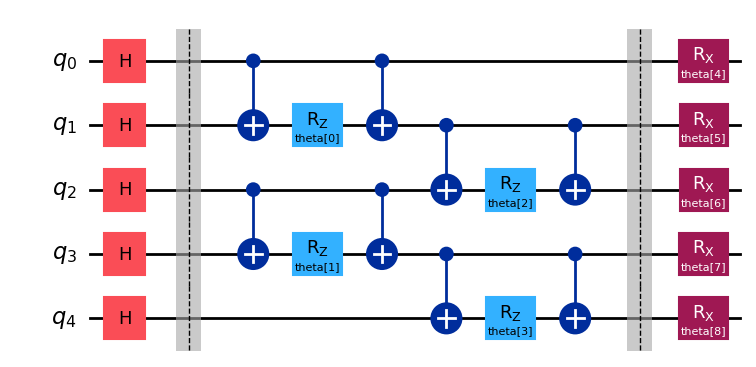

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

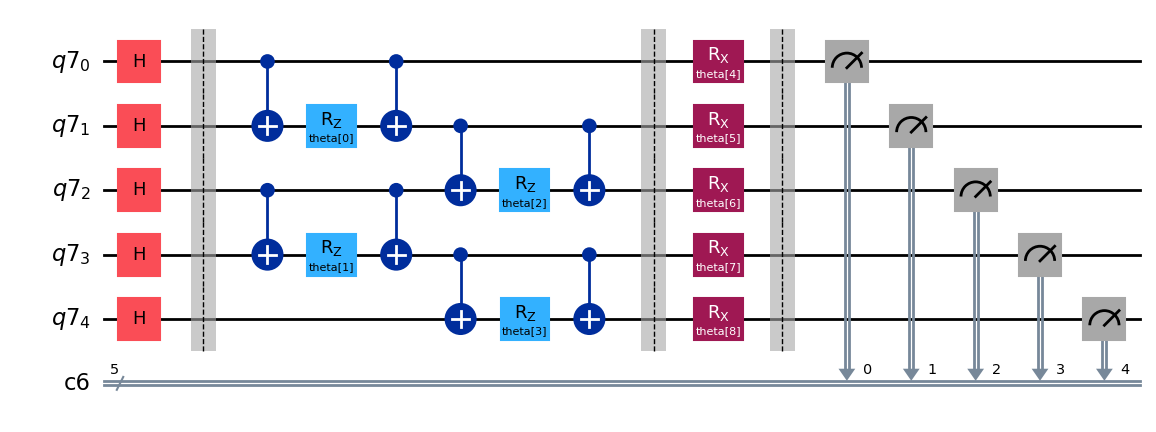

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

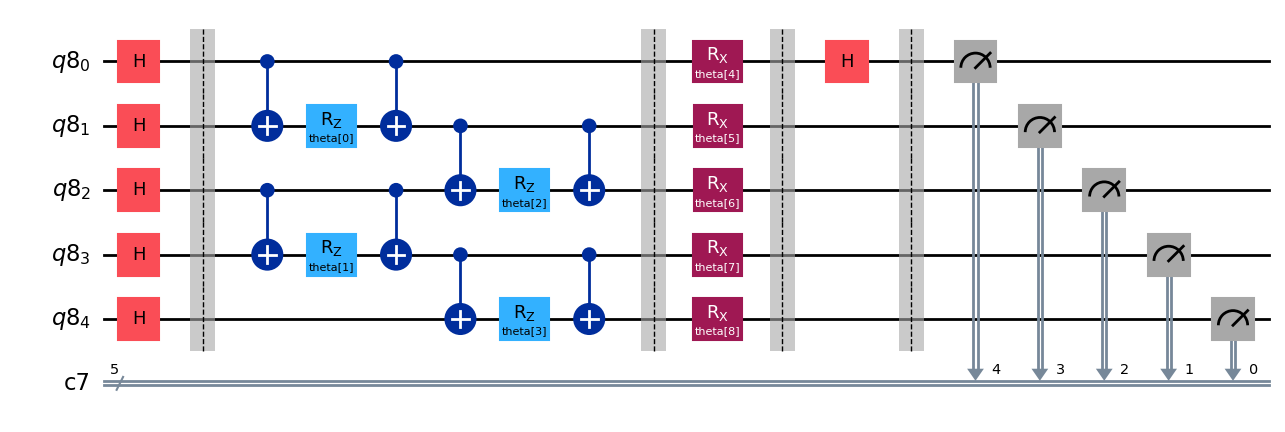

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

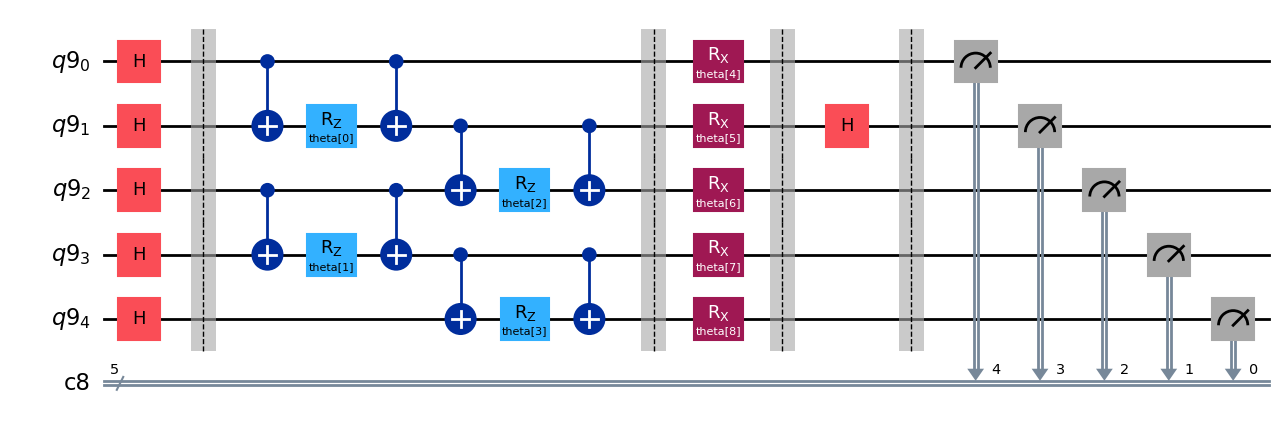

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

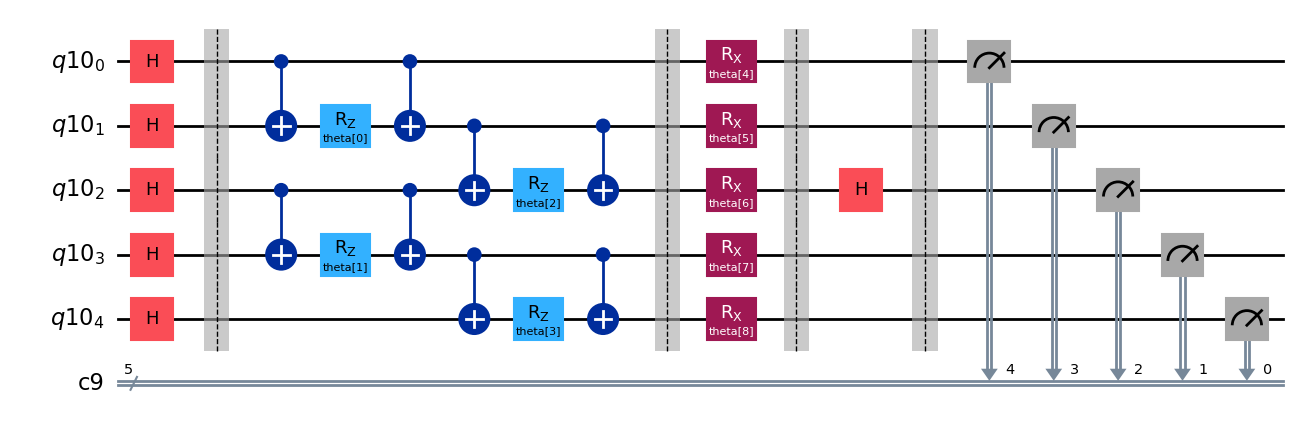

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

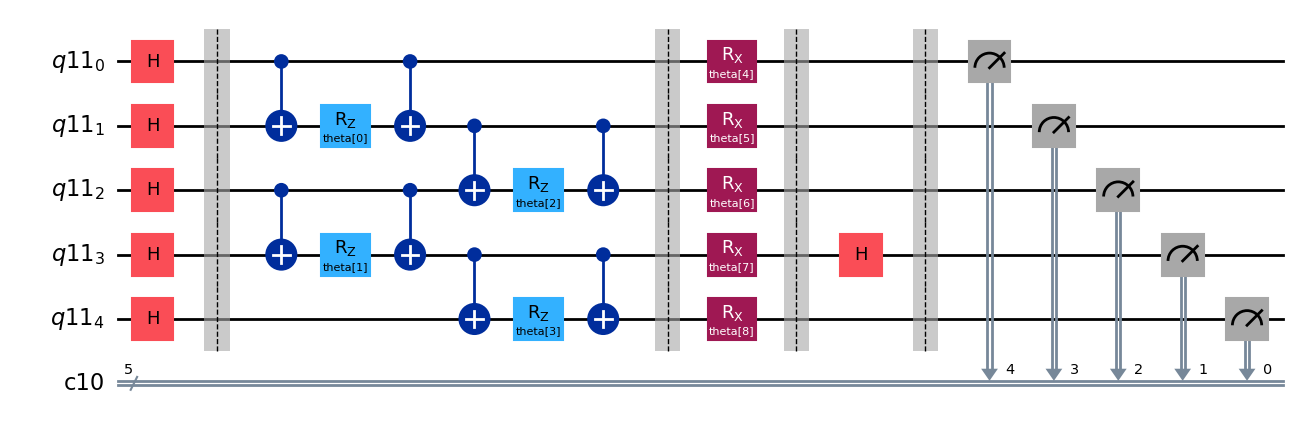

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

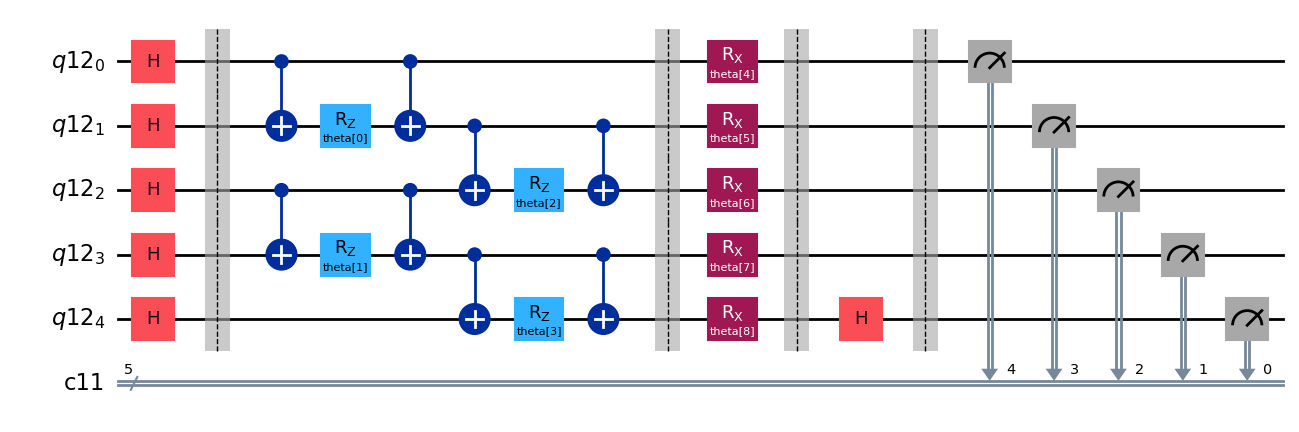

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


def cnn2(vec, x):
  a = vec[0]
  b = vec[1]

  lst = []
  lst.append(b*x[0])
  lst.append(a*x[0]+b*x[1])
  lst.append(a*x[1]+b*x[2])
  lst.append(a*x[2]+b*x[3])
  lst.append(a*x[3]+b*x[4])
  lst.append(a*x[4])

  lst = np.array(lst)

  return np.max(lst)


def cnn3(vec, x):
  a = vec[0]
  b = vec[1]
  c = vec[2]

  lst = []
  lst.append(c*x[0])
  lst.append(b*x[0]+c*x[1])
  lst.append(a*x[0]+b*x[1]+c*x[2])
  lst.append(a*x[1]+b*x[2]+c*x[3])
  lst.append(a*x[2]+b*x[3]+c*x[4])
  lst.append(a*x[3]+b*x[4])
  lst.append(a*x[4])

  lst = np.array(lst)

  return np.max(lst)


def cnn4(vec, x):
  a = vec[0]
  b = vec[1]
  c = vec[2]
  d = vec[3]

  lst = []
  lst.append(d*x[0])
  lst.append(c*x[0]+d*x[1])
  lst.append(b*x[0]+c*x[1]+d*x[2])
  lst.append(a*x[0]+b*x[1]+c*x[2]+d*x[3])
  lst.append(a*x[1]+b*x[2]+c*x[3]+d*x[4])
  lst.append(a*x[2]+b*x[3]+c*x[4])
  lst.append(a*x[3]+b*x[4])
  lst.append(a*x[4])

  lst = np.array(lst)

  return np.max(lst)


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  a1 = np.array([cnn2(parameter[0:2], x), cnn2(parameter[2:4], x), cnn3(parameter[4:7], x), cnn3(parameter[7:10], x), cnn4(parameter[10:14], x), cnn4(parameter[14:18], x)])
  z1 = relu(a1)

  FC1 = parameter[18:48]
  FC2 = parameter[48:53]
  c = parameter[53]

  FC1 = FC1.reshape(5,6)
  FC2 = FC2.reshape(1,5)


  a2 = np.matmul(FC1, z1)
  z2 = relu(a2)

  a3 = np.matmul(FC2, z2)
  y = output_activate(c, a3)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=10000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1]

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=54), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=54), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

error rate : 0.0, lowest energy vqe : -5.831799999999999

error rate : 0.001, lowest energy vqe : -5.8191999999999995

error rate : 0.002, lowest energy vqe : -5.775000000000001

error rate : 0.003, lowest energy vqe : -5.782000000000001

error rate : 0.004, lowest energy vqe : -5.7467999999999995

error rate : 0.005, lowest energy vqe : -5.742000000000001

error rate : 0.006, lowest energy vqe : -5.6944

error rate : 0.007, lowest energy vqe : -5.709399999999999

error rate : 0.008, lowest energy vqe : -5.684400000000002

error rate : 0.009000000000000001, lowest energy vqe : -5.6546

error rate : 0.01, lowest energy vqe : -5.6246

error rate : 0.02, lowest energy vqe : -5.4496

error rate : 0.03, lowest energy vqe : -5.256800000000002

error rate : 0.04, lowest energy vqe : -5.056400000000001

error rate : 0.05, lowest energy vqe : -4.8721999999999985

error rate : 0.06, lowest energy vqe : -4.706800000000002

error rate : 0.07, lowest energy vqe : -4.576600000000001

error rate : 0.

In [ ]:
lowest_energy_vqe_list

[-5.831799999999999,
 -5.8191999999999995,
 -5.775000000000001,
 -5.782000000000001,
 -5.7467999999999995,
 -5.742000000000001,
 -5.6944,
 -5.709399999999999,
 -5.684400000000002,
 -5.6546,
 -5.6246,
 -5.4496,
 -5.256800000000002,
 -5.056400000000001,
 -4.8721999999999985,
 -4.706800000000002,
 -4.576600000000001,
 -4.430999999999998,
 -4.254599999999999,
 -4.114799999999999]

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=54), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=54), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+10, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(54) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 300
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if len(local_minimum_dict) and local_minimum_dict[-1] < lowest_energy_vqnhe :
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

error rate : 0.0, lowest energy vqe : -5.831799999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.903948
         Iterations: 60
         Function evaluations: 9031
         Gradient evaluations: 164


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.897615
         Iterations: 41
         Function evaluations: 6721
         Gradient evaluations: 122
Optimization terminated successfully.
         Current function value: -5.902854
         Iterations: 78
         Function evaluations: 9240
         Gradient evaluations: 168
Optimization terminated successfully.
         Current function value: -5.864111
         Iterations: 63
         Function evaluations: 4400
         Gradient evaluations: 80
Optimization terminated successfully.
         Current function value: -5.921569
         Iterations: 78
         Function evaluations: 6875
         Gradient evaluations: 125
Optimization terminated successfully.
         Current function value: -5.860597
         Iterations: 39
         Function evaluations: 2640
         Gradient evaluations: 48


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.900397
         Iterations: 57
         Function evaluations: 6055
         Gradient evaluations: 110
Optimization terminated successfully.
         Current function value: -5.900608
         Iterations: 100
         Function evaluations: 9295
         Gradient evaluations: 169
Optimization terminated successfully.
         Current function value: -5.895773
         Iterations: 23
         Function evaluations: 1430
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: -5.901901
         Iterations: 42
         Function evaluations: 2420
         Gradient evaluations: 44
error rate : 0.0, lowest energy vqnhe : -5.9215692209688084



error rate : 0.001, lowest energy vqe : -5.8191999999999995

Optimization terminated successfully.
         Current function value: -5.872847
         Iterations: 43
         Function evaluations: 2585
         Gradient evaluations: 47
Optimization terminated successfully

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.842839
         Iterations: 4
         Function evaluations: 2976
         Gradient evaluations: 54
Optimization terminated successfully.
         Current function value: -5.821059
         Iterations: 18
         Function evaluations: 1265
         Gradient evaluations: 23


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.874404
         Iterations: 36
         Function evaluations: 6991
         Gradient evaluations: 127
Optimization terminated successfully.
         Current function value: -5.874866
         Iterations: 92
         Function evaluations: 7260
         Gradient evaluations: 132


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.871604
         Iterations: 28
         Function evaluations: 5287
         Gradient evaluations: 96
error rate : 0.001, lowest energy vqnhe : -5.9051113716317625



error rate : 0.002, lowest energy vqe : -5.775000000000001

Optimization terminated successfully.
         Current function value: -5.776677
         Iterations: 18
         Function evaluations: 1100
         Gradient evaluations: 20


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.849878
         Iterations: 54
         Function evaluations: 7987
         Gradient evaluations: 145


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.869496
         Iterations: 168
         Function evaluations: 16731
         Gradient evaluations: 304
Optimization terminated successfully.
         Current function value: -5.882039
         Iterations: 162
         Function evaluations: 12485
         Gradient evaluations: 227
Optimization terminated successfully.
         Current function value: -5.812554
         Iterations: 38
         Function evaluations: 2695
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: -5.859794
         Iterations: 36
         Function evaluations: 2200
         Gradient evaluations: 40
Optimization terminated successfully.
         Current function value: -5.810124
         Iterations: 9
         Function evaluations: 990
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: -5.860276
         Iterations: 59
         Function evaluations: 4015
         Gradient 

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.886623
         Iterations: 30
         Function evaluations: 6392
         Gradient evaluations: 116
Optimization terminated successfully.
         Current function value: -5.881305
         Iterations: 71
         Function evaluations: 5225
         Gradient evaluations: 95
Optimization terminated successfully.
         Current function value: -5.815053
         Iterations: 41
         Function evaluations: 2860
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: -5.782000
         Iterations: 0
         Function evaluations: 55
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: -5.832017
         Iterations: 34
         Function evaluations: 2145
         Gradient evaluations: 39
error rate : 0.003, lowest energy vqnhe : -5.88662268294751



error rate : 0.004, lowest energy vqe : -5.7467999999999995



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.824758
         Iterations: 51
         Function evaluations: 8206
         Gradient evaluations: 149


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.771251
         Iterations: 37
         Function evaluations: 4135
         Gradient evaluations: 75
Optimization terminated successfully.
         Current function value: -5.823477
         Iterations: 10
         Function evaluations: 1155
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -5.768789
         Iterations: 15
         Function evaluations: 1210
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: -5.829257
         Iterations: 77
         Function evaluations: 9240
         Gradient evaluations: 168
Optimization terminated successfully.
         Current function value: -5.764788
         Iterations: 3
         Function evaluations: 330
         Gradient evaluations: 6


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.839374
         Iterations: 114
         Function evaluations: 13321
         Gradient evaluations: 242
Optimization terminated successfully.
         Current function value: -5.776580
         Iterations: 21
         Function evaluations: 1430
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: -5.794593
         Iterations: 38
         Function evaluations: 6270
         Gradient evaluations: 114


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.810364
         Iterations: 58
         Function evaluations: 7706
         Gradient evaluations: 140
error rate : 0.004, lowest energy vqnhe : -5.839374372609238



error rate : 0.005, lowest energy vqe : -5.742000000000001

Optimization terminated successfully.
         Current function value: -5.771971
         Iterations: 35
         Function evaluations: 4565
         Gradient evaluations: 83


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.823752
         Iterations: 142
         Function evaluations: 16182
         Gradient evaluations: 294
Optimization terminated successfully.
         Current function value: -5.823257
         Iterations: 65
         Function evaluations: 5060
         Gradient evaluations: 92
Optimization terminated successfully.
         Current function value: -5.823945
         Iterations: 58
         Function evaluations: 3795
         Gradient evaluations: 69
Optimization terminated successfully.
         Current function value: -5.836690
         Iterations: 37
         Function evaluations: 2530
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: -5.824407
         Iterations: 296
         Function evaluations: 20955
         Gradient evaluations: 381
Optimization terminated successfully.
         Current function value: -5.742898
         Iterations: 9
         Function evaluations: 605
         Gradient 

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.744221
         Iterations: 5
         Function evaluations: 3745
         Gradient evaluations: 68
Optimization terminated successfully.
         Current function value: -5.742898
         Iterations: 27
         Function evaluations: 1595
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: -5.772579
         Iterations: 26
         Function evaluations: 1650
         Gradient evaluations: 30
error rate : 0.005, lowest energy vqnhe : -5.836689658429629



error rate : 0.006, lowest energy vqe : -5.6944

Optimization terminated successfully.
         Current function value: -5.808364
         Iterations: 92
         Function evaluations: 6050
         Gradient evaluations: 110
Optimization terminated successfully.
         Current function value: -5.752148
         Iterations: 21
         Function evaluations: 1760
         Gradient evaluations: 32


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.757709
         Iterations: 281
         Function evaluations: 23770
         Gradient evaluations: 432


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.743845
         Iterations: 67
         Function evaluations: 10069
         Gradient evaluations: 183
Optimization terminated successfully.
         Current function value: -5.695017
         Iterations: 25
         Function evaluations: 1430
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.735724
         Iterations: 16
         Function evaluations: 5178
         Gradient evaluations: 94
Optimization terminated successfully.
         Current function value: -5.737654
         Iterations: 32
         Function evaluations: 2310
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: -5.805710
         Iterations: 110
         Function evaluations: 12980
         Gradient evaluations: 236
Optimization terminated successfully.
         Current function value: -5.760383
         Iterations: 32
         Function evaluations: 2475
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: -5.808484
         Iterations: 25
         Function evaluations: 1650
         Gradient evaluations: 30
error rate : 0.006, lowest energy vqnhe : -5.808483999142415



error rate : 0.007, lowest energy vqe : -5.709399999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.828647
         Iterations: 35
         Function evaluations: 6440
         Gradient evaluations: 117
Optimization terminated successfully.
         Current function value: -5.756774
         Iterations: 32
         Function evaluations: 1980
         Gradient evaluations: 36


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.825133
         Iterations: 44
         Function evaluations: 6447
         Gradient evaluations: 117
Optimization terminated successfully.
         Current function value: -5.709408
         Iterations: 10
         Function evaluations: 660
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: -5.797708
         Iterations: 45
         Function evaluations: 2970
         Gradient evaluations: 54
Optimization terminated successfully.
         Current function value: -5.764550
         Iterations: 54
         Function evaluations: 4015
         Gradient evaluations: 73
Optimization terminated successfully.
         Current function value: -5.774309
         Iterations: 39
         Function evaluations: 3025
         Gradient evaluations: 55
Optimization terminated successfully.
         Current function value: -5.827833
         Iterations: 47
         Function evaluations: 2750
         Gradient eval

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.714425
         Iterations: 9
         Function evaluations: 4521
         Gradient evaluations: 82


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.738934
         Iterations: 19
         Function evaluations: 4742
         Gradient evaluations: 86
Optimization terminated successfully.
         Current function value: -5.787440
         Iterations: 63
         Function evaluations: 4345
         Gradient evaluations: 79
Optimization terminated successfully.
         Current function value: -5.775048
         Iterations: 20
         Function evaluations: 1320
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: -5.741271
         Iterations: 53
         Function evaluations: 3300
         Gradient evaluations: 60
Optimization terminated successfully.
         Current function value: -5.756113
         Iterations: 79
         Function evaluations: 5830
         Gradient evaluations: 106
error rate : 0.008, lowest energy vqnhe : -5.787439979698193



error rate : 0.009000000000000001, lowest energy vqe : -5.6546

Optimization terminated successful

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.695681
         Iterations: 134
         Function evaluations: 15190
         Gradient evaluations: 276
Optimization terminated successfully.
         Current function value: -5.654600
         Iterations: 1
         Function evaluations: 110
         Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.728248
         Iterations: 119
         Function evaluations: 13265
         Gradient evaluations: 241
Optimization terminated successfully.
         Current function value: -5.757376
         Iterations: 219
         Function evaluations: 17600
         Gradient evaluations: 320
Optimization terminated successfully.
         Current function value: -5.692339
         Iterations: 38
         Function evaluations: 2310
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: -5.757147
         Iterations: 74
         Function evaluations: 7434
         Gradient evaluations: 135


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.765175
         Iterations: 56
         Function evaluations: 7325
         Gradient evaluations: 133
Optimization terminated successfully.
         Current function value: -5.768134
         Iterations: 95
         Function evaluations: 9295
         Gradient evaluations: 169


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.686956
         Iterations: 24
         Function evaluations: 6442
         Gradient evaluations: 117
error rate : 0.009000000000000001, lowest energy vqnhe : -5.768134065885558



error rate : 0.01, lowest energy vqe : -5.6246

Optimization terminated successfully.
         Current function value: -5.673007
         Iterations: 23
         Function evaluations: 1705
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: -5.624600
         Iterations: 2
         Function evaluations: 220
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: -5.726225
         Iterations: 36
         Function evaluations: 2255
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: -5.624600
         Iterations: 0
         Function evaluations: 55
         Gradient evaluations: 1
Optimization terminated successfully.
    

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.705343
         Iterations: 132
         Function evaluations: 16122
         Gradient evaluations: 293
Optimization terminated successfully.
         Current function value: -5.727551
         Iterations: 54
         Function evaluations: 3520
         Gradient evaluations: 64
Optimization terminated successfully.
         Current function value: -5.727475
         Iterations: 55
         Function evaluations: 3905
         Gradient evaluations: 71
error rate : 0.01, lowest energy vqnhe : -5.727824786531487



error rate : 0.02, lowest energy vqe : -5.4496

Optimization terminated successfully.
         Current function value: -5.449792
         Iterations: 12
         Function evaluations: 880
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: -5.606434
         Iterations: 124
         Function evaluations: 13255
         Gradient evaluations: 241
Optimization terminated successfully.
         

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.519476
         Iterations: 42
         Function evaluations: 5016
         Gradient evaluations: 91
Optimization terminated successfully.
         Current function value: -5.449793
         Iterations: 2
         Function evaluations: 275
         Gradient evaluations: 5


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.600544
         Iterations: 82
         Function evaluations: 10952
         Gradient evaluations: 199
Optimization terminated successfully.
         Current function value: -5.613545
         Iterations: 65
         Function evaluations: 4730
         Gradient evaluations: 86
Optimization terminated successfully.
         Current function value: -5.590128
         Iterations: 76
         Function evaluations: 4950
         Gradient evaluations: 90


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.527883
         Iterations: 61
         Function evaluations: 7427
         Gradient evaluations: 135
error rate : 0.02, lowest energy vqnhe : -5.613545399129404



error rate : 0.03, lowest energy vqe : -5.256800000000002

Optimization terminated successfully.
         Current function value: -5.458938
         Iterations: 17
         Function evaluations: 1100
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: -5.460875
         Iterations: 50
         Function evaluations: 3025
         Gradient evaluations: 55


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.455503
         Iterations: 84
         Function evaluations: 8916
         Gradient evaluations: 162
Optimization terminated successfully.
         Current function value: -5.460960
         Iterations: 31
         Function evaluations: 1760
         Gradient evaluations: 32


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.338670
         Iterations: 86
         Function evaluations: 10677
         Gradient evaluations: 194
Optimization terminated successfully.
         Current function value: -5.459033
         Iterations: 51
         Function evaluations: 3245
         Gradient evaluations: 59
Optimization terminated successfully.
         Current function value: -5.317422
         Iterations: 19
         Function evaluations: 1100
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: -5.460801
         Iterations: 46
         Function evaluations: 3080
         Gradient evaluations: 56
Optimization terminated successfully.
         Current function value: -5.458955
         Iterations: 41
         Function evaluations: 2695
         Gradient evaluations: 49


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.333792
         Iterations: 66
         Function evaluations: 9305
         Gradient evaluations: 169
error rate : 0.03, lowest energy vqnhe : -5.460960445529198



error rate : 0.04, lowest energy vqe : -5.056400000000001

Optimization terminated successfully.
         Current function value: -5.309513
         Iterations: 97
         Function evaluations: 6655
         Gradient evaluations: 121
Optimization terminated successfully.
         Current function value: -5.124620
         Iterations: 14
         Function evaluations: 1540
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: -5.152873
         Iterations: 34
         Function evaluations: 4070
         Gradient evaluations: 74
Optimization terminated successfully.
         Current function value: -5.310324
         Iterations: 66
         Function evaluations: 4455
         Gradient evaluations: 81
Optimization terminated successfully.
 

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.310528
         Iterations: 54
         Function evaluations: 11342
         Gradient evaluations: 206


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.146757
         Iterations: 24
         Function evaluations: 4906
         Gradient evaluations: 89
Optimization terminated successfully.
         Current function value: -5.124620
         Iterations: 14
         Function evaluations: 990
         Gradient evaluations: 18


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.318625
         Iterations: 149
         Function evaluations: 16727
         Gradient evaluations: 304
error rate : 0.04, lowest energy vqnhe : -5.318625460239696



error rate : 0.05, lowest energy vqe : -4.8721999999999985

Optimization terminated successfully.
         Current function value: -4.958665
         Iterations: 41
         Function evaluations: 8415
         Gradient evaluations: 153


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.142257
         Iterations: 27
         Function evaluations: 6004
         Gradient evaluations: 109


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.874884
         Iterations: 26
         Function evaluations: 5339
         Gradient evaluations: 97
Optimization terminated successfully.
         Current function value: -5.216971
         Iterations: 40
         Function evaluations: 2365
         Gradient evaluations: 43


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.217420
         Iterations: 128
         Function evaluations: 14365
         Gradient evaluations: 261


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.971966
         Iterations: 15
         Function evaluations: 4357
         Gradient evaluations: 79
Optimization terminated successfully.
         Current function value: -5.216595
         Iterations: 28
         Function evaluations: 1870
         Gradient evaluations: 34


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.208042
         Iterations: 103
         Function evaluations: 14807
         Gradient evaluations: 269
Optimization terminated successfully.
         Current function value: -5.135251
         Iterations: 19
         Function evaluations: 1595
         Gradient evaluations: 29


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.044182
         Iterations: 38
         Function evaluations: 6330
         Gradient evaluations: 115
error rate : 0.05, lowest energy vqnhe : -5.2174201256509285



error rate : 0.06, lowest energy vqe : -4.706800000000002



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.863231
         Iterations: 13
         Function evaluations: 3751
         Gradient evaluations: 68
Optimization terminated successfully.
         Current function value: -4.929487
         Iterations: 24
         Function evaluations: 3410
         Gradient evaluations: 62
Optimization terminated successfully.
         Current function value: -4.817217
         Iterations: 14
         Function evaluations: 990
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: -4.882262
         Iterations: 45
         Function evaluations: 2915
         Gradient evaluations: 53


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.113364
         Iterations: 156
         Function evaluations: 12493
         Gradient evaluations: 227
Optimization terminated successfully.
         Current function value: -5.100524
         Iterations: 76
         Function evaluations: 6050
         Gradient evaluations: 110
Optimization terminated successfully.
         Current function value: -5.046667
         Iterations: 38
         Function evaluations: 3135
         Gradient evaluations: 57
Optimization terminated successfully.
         Current function value: -4.856975
         Iterations: 19
         Function evaluations: 1155
         Gradient evaluations: 21


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.820294
         Iterations: 3
         Function evaluations: 6117
         Gradient evaluations: 111
Optimization terminated successfully.
         Current function value: -4.865660
         Iterations: 39
         Function evaluations: 2640
         Gradient evaluations: 48
error rate : 0.06, lowest energy vqnhe : -5.1133637963997245



error rate : 0.07, lowest energy vqe : -4.576600000000001

Optimization terminated successfully.
         Current function value: -4.956498
         Iterations: 24
         Function evaluations: 2090
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: -4.961433
         Iterations: 36
         Function evaluations: 2640
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: -4.965836
         Iterations: 20
         Function evaluations: 2585
         Gradient evaluations: 47
Optimization terminated successfully.
  

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.031851
         Iterations: 41
         Function evaluations: 7708
         Gradient evaluations: 140
Optimization terminated successfully.
         Current function value: -4.583802
         Iterations: 8
         Function evaluations: 660
         Gradient evaluations: 12


<ipython-input-46-4048d43bbc56>:8: RuntimeWarning: overflow encountered in exp
  return np.exp(c*np.tanh(x))
<ipython-input-25-942dbc8389c9>:11: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-25-942dbc8389c9>:26: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-25-942dbc8389c9>:41: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-25-942dbc8389c9>:54: RuntimeWarning: invalid value encountered in scalar add
  expval = expval + prob_string[k]*nnval[k]
<ipython-input-46-4048d43bbc56>:8: RuntimeWarning: overflow encountered in exp
  return np.exp(c*np.tanh(x))
<ipython-input-25-942dbc8389c9>:11: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-25-942dbc8389c9>:26: RuntimeWarning: invalid value encountered in s

         Current function value: nan
         Iterations: 32
         Function evaluations: 8690
         Gradient evaluations: 158


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.013207
         Iterations: 56
         Function evaluations: 11617
         Gradient evaluations: 211


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.029072
         Iterations: 82
         Function evaluations: 9630
         Gradient evaluations: 175
error rate : 0.07, lowest energy vqnhe : -5.031851065964



error rate : 0.08, lowest energy vqe : -4.430999999999998

Optimization terminated successfully.
         Current function value: -4.981780
         Iterations: 139
         Function evaluations: 8855
         Gradient evaluations: 161
Optimization terminated successfully.
         Current function value: -4.967187
         Iterations: 25
         Function evaluations: 1540
         Gradient evaluations: 28
Optimization terminated successfully.
         Current function value: -4.935037
         Iterations: 69
         Function evaluations: 6105
         Gradient evaluations: 111
Optimization terminated successfully.
         Current function value: -4.441542
         Iterations: 5
         Function evaluations: 385
         Gradient evaluations: 7


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.973514
         Iterations: 76
         Function evaluations: 10792
         Gradient evaluations: 196
Optimization terminated successfully.
         Current function value: -4.607947
         Iterations: 44
         Function evaluations: 2805
         Gradient evaluations: 51
Optimization terminated successfully.
         Current function value: -4.943426
         Iterations: 82
         Function evaluations: 7425
         Gradient evaluations: 135
Optimization terminated successfully.
         Current function value: -4.723343
         Iterations: 16
         Function evaluations: 1155
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -4.441542
         Iterations: 12
         Function evaluations: 770
         Gradient evaluations: 14
Optimization terminated successfully.
         Current function value: -4.882211
         Iterations: 16
         Function evaluations: 1540
         Gradient ev

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.863445
         Iterations: 190
         Function evaluations: 17007
         Gradient evaluations: 309


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.491423
         Iterations: 58
         Function evaluations: 8977
         Gradient evaluations: 163
Optimization terminated successfully.
         Current function value: -4.843244
         Iterations: 61
         Function evaluations: 3795
         Gradient evaluations: 69
Optimization terminated successfully.
         Current function value: -4.714009
         Iterations: 16
         Function evaluations: 1320
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: -4.585880
         Iterations: 15
         Function evaluations: 1155
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -4.853432
         Iterations: 58
         Function evaluations: 3575
         Gradient evaluations: 65
error rate : 0.09, lowest energy vqnhe : -4.863445336486164



error rate : 0.1, lowest energy vqe : -4.114799999999999

Optimization terminated successfully.
   

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.751654
         Iterations: 69
         Function evaluations: 5830
         Gradient evaluations: 106
Optimization terminated successfully.
         Current function value: -4.320494
         Iterations: 12
         Function evaluations: 990
         Gradient evaluations: 18


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.774759
         Iterations: 29
         Function evaluations: 6166
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.241151
         Iterations: 10
         Function evaluations: 6777
         Gradient evaluations: 123
Optimization terminated successfully.
         Current function value: -4.755514
         Iterations: 60
         Function evaluations: 4950
         Gradient evaluations: 90
Optimization terminated successfully.
         Current function value: -4.744186
         Iterations: 66
         Function evaluations: 4510
         Gradient evaluations: 82
Optimization terminated successfully.
         Current function value: -4.751654
         Iterations: 99
         Function evaluations: 8030
         Gradient evaluations: 146
         Current function value: -4.739020
         Iterations: 74
         Function evaluations: 9411
         Gradient evaluations: 171
error rate : 0.1, lowest energy vqnhe : -4.774758869722714





/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [ ]:
lowest_energy_vqnhe_list

[-5.9215692209688084,
 -5.9051113716317625,
 -5.882038846182267,
 -5.88662268294751,
 -5.839374372609238,
 -5.836689658429629,
 -5.808483999142415,
 -5.8287110002385445,
 -5.787439979698193,
 -5.768134065885558,
 -5.727824786531487,
 -5.613545399129404,
 -5.460960445529198,
 -5.318625460239696,
 -5.2174201256509285,
 -5.1133637963997245,
 -5.031851065964,
 -4.981779980345924,
 -4.863445336486164,
 -4.774758869722714]

## Depolarization Channel, Error 0.001~0.1, Shots = 10000, CNN ver 2

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

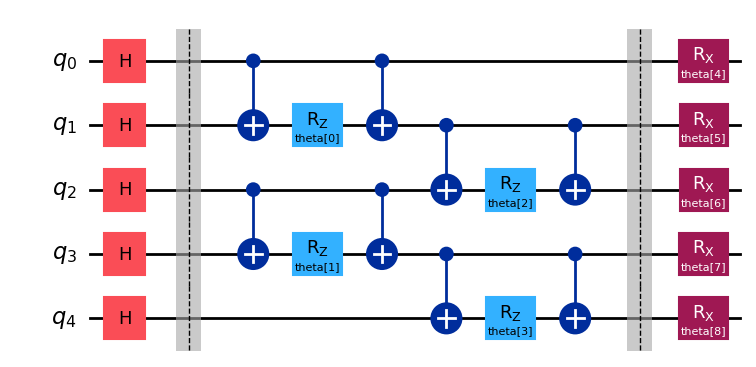

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

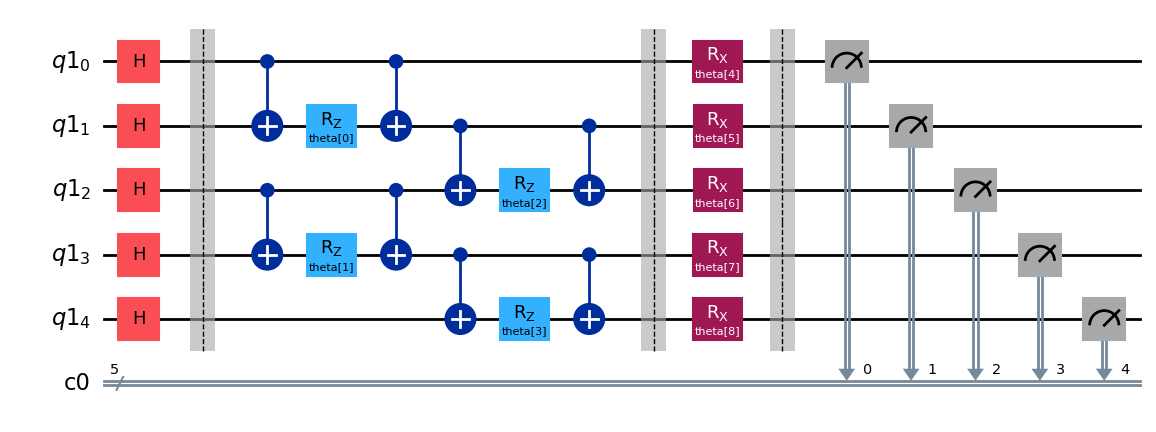

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

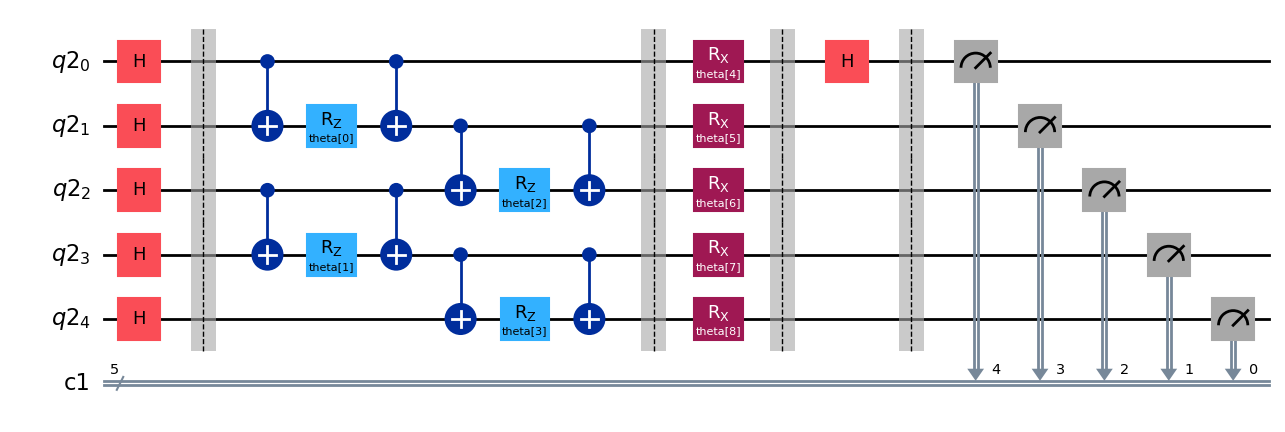

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

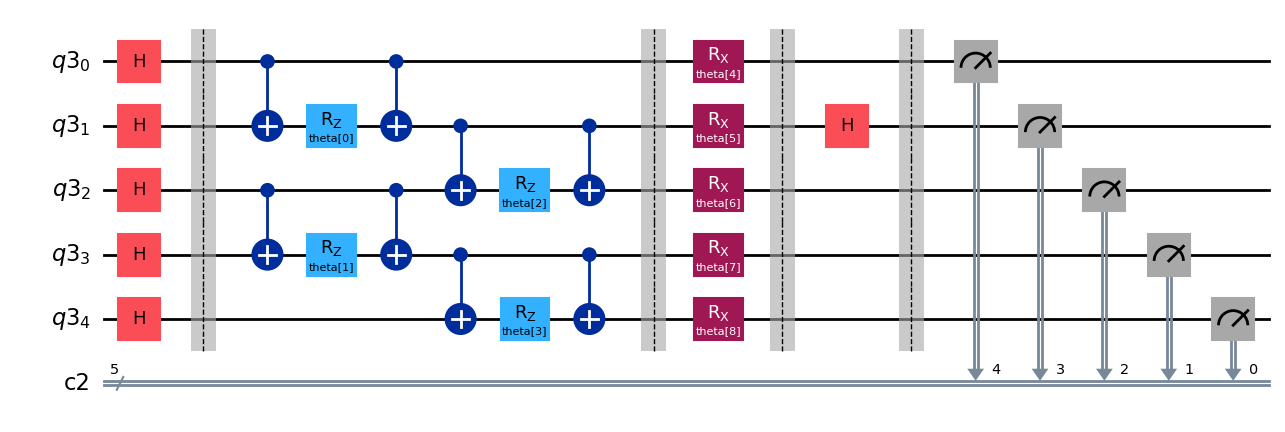

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

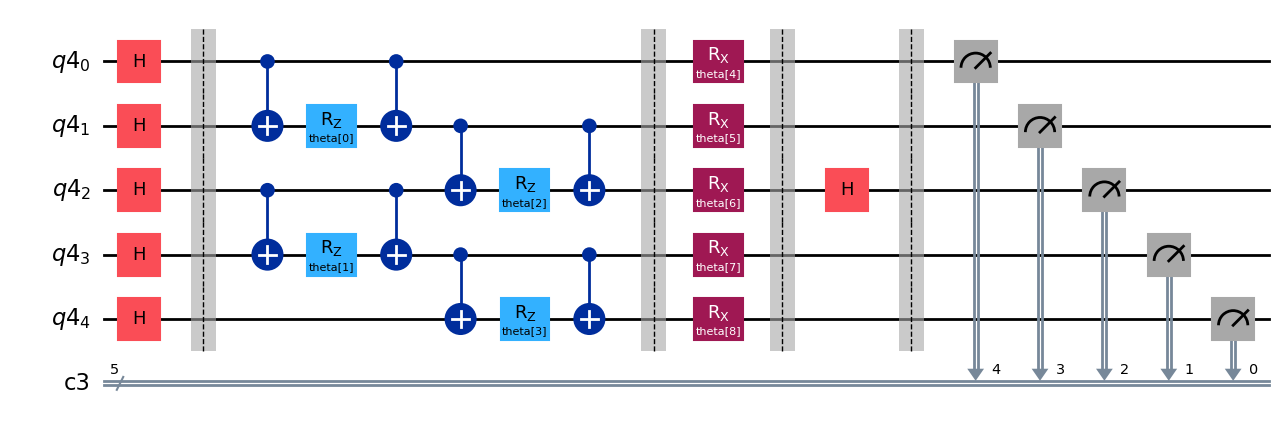

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

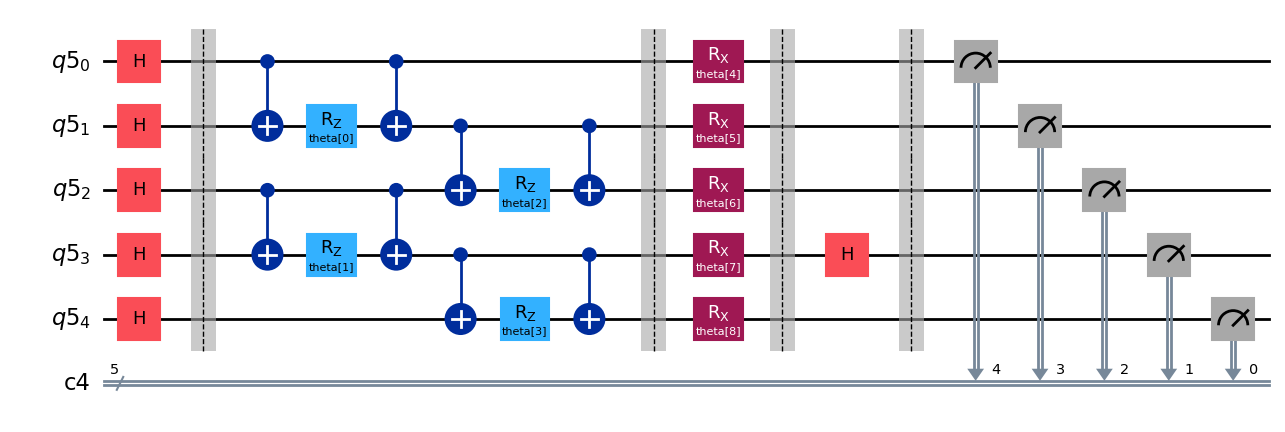

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

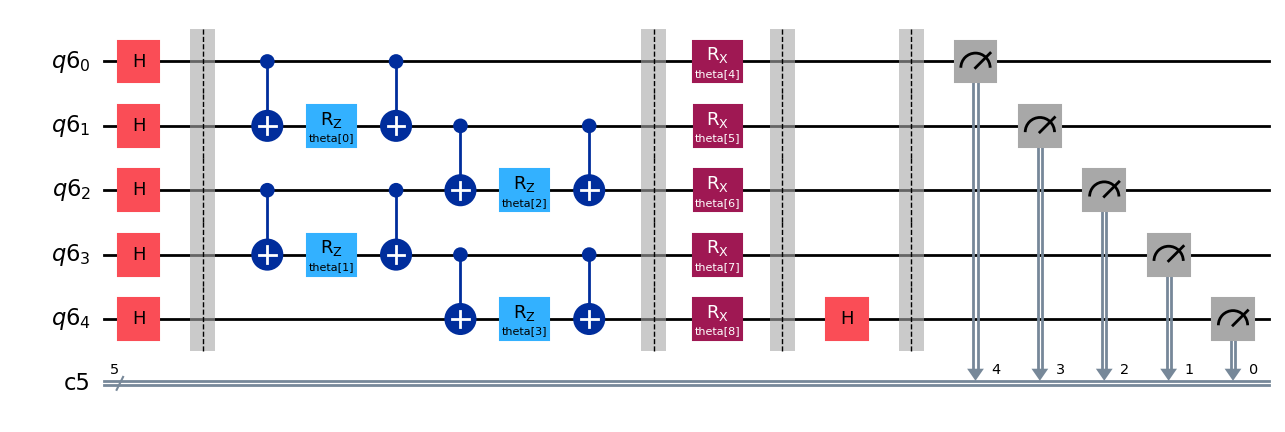

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


def cnn3(vec, x):
  a = vec[0]
  b = vec[1]
  c = vec[2]

  lst = []
  lst.append(c*x[0])
  lst.append(b*x[0]+c*x[1])
  lst.append(a*x[0]+b*x[1]+c*x[2])
  lst.append(a*x[1]+b*x[2]+c*x[3])
  lst.append(a*x[2]+b*x[3]+c*x[4])
  lst.append(a*x[3]+b*x[4])
  lst.append(a*x[4])

  lst = np.array(lst)

  return np.max(lst)


def cnn5(vec, x):
  a = vec[0]
  b = vec[1]
  c = vec[2]
  d = vec[3]
  e = vec[4]

  lst = []
  lst.append(e*x[0])
  lst.append(d*x[0]+e*x[1])
  lst.append(c*x[0]+d*x[1]+e*x[2])
  lst.append(b*x[0]+c*x[1]+d*x[2]+e*x[3])
  lst.append(a*x[0]+b*x[1]+c*x[2]+d*x[3]+e*x[4])
  lst.append(a*x[1]+b*x[2]+c*x[3]+d*x[4])
  lst.append(a*x[2]+b*x[3]+c*x[4])
  lst.append(a*x[3]+b*x[4])
  lst.append(a*x[4])

  lst = np.array(lst)

  return np.max(lst)


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  a1 = np.array([cnn3(parameter[0:3], x), cnn3(parameter[3:6], x), cnn5(parameter[6:11], x), cnn5(parameter[11:16], x)])
  z1 = relu(a1)

  FC1 = parameter[16:36]
  FC2 = parameter[36:41]
  c = parameter[41]

  FC1 = FC1.reshape(5,4)
  FC2 = FC2.reshape(1,5)


  a2 = np.matmul(FC1, z1)
  z2 = relu(a2)

  a3 = np.matmul(FC2, z2)
  y = output_activate(c, a3)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=10000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1]

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=42), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=42), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

error rate : 0.0, lowest energy vqe : -5.831799999999999

error rate : 0.001, lowest energy vqe : -5.8191999999999995

error rate : 0.002, lowest energy vqe : -5.775000000000001

error rate : 0.003, lowest energy vqe : -5.782000000000001

error rate : 0.004, lowest energy vqe : -5.7467999999999995

error rate : 0.005, lowest energy vqe : -5.742000000000001

error rate : 0.006, lowest energy vqe : -5.6944

error rate : 0.007, lowest energy vqe : -5.709399999999999

error rate : 0.008, lowest energy vqe : -5.684400000000002

error rate : 0.009000000000000001, lowest energy vqe : -5.6546

error rate : 0.01, lowest energy vqe : -5.6246

error rate : 0.02, lowest energy vqe : -5.4496

error rate : 0.03, lowest energy vqe : -5.256800000000002

error rate : 0.04, lowest energy vqe : -5.056400000000001

error rate : 0.05, lowest energy vqe : -4.8721999999999985

error rate : 0.06, lowest energy vqe : -4.706800000000002

error rate : 0.07, lowest energy vqe : -4.576600000000001

error rate : 0.

In [ ]:
lowest_energy_vqe_list

[-5.831799999999999,
 -5.8191999999999995,
 -5.775000000000001,
 -5.782000000000001,
 -5.7467999999999995,
 -5.742000000000001,
 -5.6944,
 -5.709399999999999,
 -5.684400000000002,
 -5.6546,
 -5.6246,
 -5.4496,
 -5.256800000000002,
 -5.056400000000001,
 -4.8721999999999985,
 -4.706800000000002,
 -4.576600000000001,
 -4.430999999999998,
 -4.254599999999999,
 -4.114799999999999]

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=42), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=42), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+10, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(42) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 300
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if len(local_minimum_dict) and local_minimum_dict[-1] < lowest_energy_vqnhe :
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

error rate : 0.0, lowest energy vqe : -5.831799999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.925828
         Iterations: 132
         Function evaluations: 9337
         Gradient evaluations: 217


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.874937
         Iterations: 169
         Function evaluations: 9503
         Gradient evaluations: 221
Optimization terminated successfully.
         Current function value: -5.831800
         Iterations: 0
         Function evaluations: 43
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.901730
         Iterations: 44
         Function evaluations: 4435
         Gradient evaluations: 103


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.927053
         Iterations: 75
         Function evaluations: 6672
         Gradient evaluations: 155


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.920446
         Iterations: 71
         Function evaluations: 7019
         Gradient evaluations: 163


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.927376
         Iterations: 98
         Function evaluations: 8572
         Gradient evaluations: 199


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.918814
         Iterations: 108
         Function evaluations: 10632
         Gradient evaluations: 247
Optimization terminated successfully.
         Current function value: -5.831800
         Iterations: 0
         Function evaluations: 43
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.913230
         Iterations: 45
         Function evaluations: 4051
         Gradient evaluations: 94
error rate : 0.0, lowest energy vqnhe : -5.927376181124571



error rate : 0.001, lowest energy vqe : -5.8191999999999995



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.896227
         Iterations: 38
         Function evaluations: 5086
         Gradient evaluations: 118
Optimization terminated successfully.
         Current function value: -5.895744
         Iterations: 81
         Function evaluations: 5762
         Gradient evaluations: 134


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.909314
         Iterations: 187
         Function evaluations: 18623
         Gradient evaluations: 433
Optimization terminated successfully.
         Current function value: -5.874834
         Iterations: 59
         Function evaluations: 2881
         Gradient evaluations: 67


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.904422
         Iterations: 99
         Function evaluations: 9256
         Gradient evaluations: 215
Optimization terminated successfully.
         Current function value: -5.829389
         Iterations: 20
         Function evaluations: 946
         Gradient evaluations: 22


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.897449
         Iterations: 65
         Function evaluations: 7451
         Gradient evaluations: 173


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.892824
         Iterations: 297
         Function evaluations: 20775
         Gradient evaluations: 483
Optimization terminated successfully.
         Current function value: -5.907371
         Iterations: 70
         Function evaluations: 3913
         Gradient evaluations: 91
Optimization terminated successfully.
         Current function value: -5.894395
         Iterations: 85
         Function evaluations: 7138
         Gradient evaluations: 166
error rate : 0.001, lowest energy vqnhe : -5.909313645416584



error rate : 0.002, lowest energy vqe : -5.775000000000001

Optimization terminated successfully.
         Current function value: -5.852118
         Iterations: 87
         Function evaluations: 5590
         Gradient evaluations: 130
Optimization terminated successfully.
         Current function value: -5.799776
         Iterations: 50
         Function evaluations: 2623
         Gradient evaluations: 61
Optimization terminated successful

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.851126
         Iterations: 176
         Function evaluations: 10629
         Gradient evaluations: 247
Optimization terminated successfully.
         Current function value: -5.845470
         Iterations: 74
         Function evaluations: 4558
         Gradient evaluations: 106
Optimization terminated successfully.
         Current function value: -5.865943
         Iterations: 21
         Function evaluations: 1032
         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.891239
         Iterations: 166
         Function evaluations: 11579
         Gradient evaluations: 269
error rate : 0.002, lowest energy vqnhe : -5.902385999343327



error rate : 0.003, lowest energy vqe : -5.782000000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.889417
         Iterations: 58
         Function evaluations: 6460
         Gradient evaluations: 150
Optimization terminated successfully.
         Current function value: -5.896285
         Iterations: 240
         Function evaluations: 15136
         Gradient evaluations: 352


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.874839
         Iterations: 36
         Function evaluations: 4219
         Gradient evaluations: 98
Optimization terminated successfully.
         Current function value: -5.823349
         Iterations: 47
         Function evaluations: 8342
         Gradient evaluations: 194
Optimization terminated successfully.
         Current function value: -5.782005
         Iterations: 9
         Function evaluations: 430
         Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.916677
         Iterations: 55
         Function evaluations: 5945
         Gradient evaluations: 138


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.916829
         Iterations: 54
         Function evaluations: 5514
         Gradient evaluations: 128


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.885500
         Iterations: 72
         Function evaluations: 7148
         Gradient evaluations: 166
Optimization terminated successfully.
         Current function value: -5.882331
         Iterations: 83
         Function evaluations: 4343
         Gradient evaluations: 101


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.860217
         Iterations: 77
         Function evaluations: 7014
         Gradient evaluations: 163
error rate : 0.003, lowest energy vqnhe : -5.91682904103446



error rate : 0.004, lowest energy vqe : -5.7467999999999995

Optimization terminated successfully.
         Current function value: -5.819040
         Iterations: 59
         Function evaluations: 3139
         Gradient evaluations: 73


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.808547
         Iterations: 29
         Function evaluations: 4784
         Gradient evaluations: 111


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.839274
         Iterations: 61
         Function evaluations: 6548
         Gradient evaluations: 152
Optimization terminated successfully.
         Current function value: -5.810566
         Iterations: 66
         Function evaluations: 8729
         Gradient evaluations: 203


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.841899
         Iterations: 126
         Function evaluations: 9380
         Gradient evaluations: 218
Optimization terminated successfully.
         Current function value: -5.840035
         Iterations: 88
         Function evaluations: 7310
         Gradient evaluations: 170


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.846890
         Iterations: 77
         Function evaluations: 7709
         Gradient evaluations: 179
Optimization terminated successfully.
         Current function value: -5.748540
         Iterations: 21
         Function evaluations: 1032
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: -5.831301
         Iterations: 132
         Function evaluations: 8772
         Gradient evaluations: 204
Optimization terminated successfully.
         Current function value: -5.779686
         Iterations: 152
         Function evaluations: 9890
         Gradient evaluations: 230
error rate : 0.004, lowest energy vqnhe : -5.846889572148767



error rate : 0.005, lowest energy vqe : -5.742000000000001

Optimization terminated successfully.
         Current function value: -5.770687
         Iterations: 11
         Function evaluations: 516
         Gradient evaluations: 12
Optimization terminated successfull

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.831094
         Iterations: 91
         Function evaluations: 10461
         Gradient evaluations: 243


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.813334
         Iterations: 94
         Function evaluations: 9945
         Gradient evaluations: 231
Optimization terminated successfully.
         Current function value: -5.857801
         Iterations: 235
         Function evaluations: 14620
         Gradient evaluations: 340
Optimization terminated successfully.
         Current function value: -5.838389
         Iterations: 142
         Function evaluations: 8256
         Gradient evaluations: 192


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.830543
         Iterations: 107
         Function evaluations: 12396
         Gradient evaluations: 288


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.812897
         Iterations: 47
         Function evaluations: 6670
         Gradient evaluations: 155
Optimization terminated successfully.
         Current function value: -5.825882
         Iterations: 128
         Function evaluations: 9761
         Gradient evaluations: 227
Optimization terminated successfully.
         Current function value: -5.823664
         Iterations: 44
         Function evaluations: 2021
         Gradient evaluations: 47
error rate : 0.005, lowest energy vqnhe : -5.857800991752914



error rate : 0.006, lowest energy vqe : -5.6944

Optimization terminated successfully.
         Current function value: -5.805689
         Iterations: 111
         Function evaluations: 5719
         Gradient evaluations: 133
Optimization terminated successfully.
         Current function value: -5.804476
         Iterations: 20
         Function evaluations: 1032
         Gradient evaluations: 24
Optimization terminated successfully.
       

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.786807
         Iterations: 114
         Function evaluations: 11364
         Gradient evaluations: 264


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.822189
         Iterations: 183
         Function evaluations: 11227
         Gradient evaluations: 261
Optimization terminated successfully.
         Current function value: -5.749321
         Iterations: 12
         Function evaluations: 774
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: -5.796856
         Iterations: 94
         Function evaluations: 5504
         Gradient evaluations: 128
Optimization terminated successfully.
         Current function value: -5.786896
         Iterations: 26
         Function evaluations: 1548
         Gradient evaluations: 36


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.814881
         Iterations: 75
         Function evaluations: 8908
         Gradient evaluations: 207
error rate : 0.006, lowest energy vqnhe : -5.85641765298176



error rate : 0.007, lowest energy vqe : -5.709399999999999

Optimization terminated successfully.
         Current function value: -5.827108
         Iterations: 87
         Function evaluations: 4816
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.828790
         Iterations: 84
         Function evaluations: 5031
         Gradient evaluations: 117
Optimization terminated successfully.
         Current function value: -5.821741
         Iterations: 16
         Function evaluations: 774
         Gradient evaluations: 18


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.859509
         Iterations: 102
         Function evaluations: 9168
         Gradient evaluations: 213


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.813205
         Iterations: 26
         Function evaluations: 5043
         Gradient evaluations: 117


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.827330
         Iterations: 82
         Function evaluations: 6622
         Gradient evaluations: 154
Optimization terminated successfully.
         Current function value: -5.797707
         Iterations: 59
         Function evaluations: 3053
         Gradient evaluations: 71


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.780708
         Iterations: 72
         Function evaluations: 8735
         Gradient evaluations: 203


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.860881
         Iterations: 61
         Function evaluations: 7795
         Gradient evaluations: 181


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.719597
         Iterations: 5
         Function evaluations: 1813
         Gradient evaluations: 42
error rate : 0.007, lowest energy vqnhe : -5.860881270799806



error rate : 0.008, lowest energy vqe : -5.684400000000002



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.768890
         Iterations: 52
         Function evaluations: 5766
         Gradient evaluations: 134


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.799650
         Iterations: 300
         Function evaluations: 15179
         Gradient evaluations: 353


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.781915
         Iterations: 21
         Function evaluations: 3274
         Gradient evaluations: 76
Optimization terminated successfully.
         Current function value: -5.769523
         Iterations: 85
         Function evaluations: 7740
         Gradient evaluations: 180


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.791368
         Iterations: 116
         Function evaluations: 12697
         Gradient evaluations: 295


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.770031
         Iterations: 76
         Function evaluations: 8698
         Gradient evaluations: 202
Optimization terminated successfully.
         Current function value: -5.779241
         Iterations: 46
         Function evaluations: 2236
         Gradient evaluations: 52
Optimization terminated successfully.
         Current function value: -5.684400
         Iterations: 1
         Function evaluations: 86
         Gradient evaluations: 2
Optimization terminated successfully.
         Current function value: -5.809443
         Iterations: 81
         Function evaluations: 4214
         Gradient evaluations: 98
Optimization terminated successfully.
         Current function value: -5.715898
         Iterations: 28
         Function evaluations: 1333
         Gradient evaluations: 31
error rate : 0.008, lowest energy vqnhe : -5.8094432284179955



error rate : 0.009000000000000001, lowest energy vqe : -5.6546

Optimization terminated successfully.

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.766952
         Iterations: 130
         Function evaluations: 12740
         Gradient evaluations: 296


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.769323
         Iterations: 300
         Function evaluations: 18877
         Gradient evaluations: 439


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.770035
         Iterations: 124
         Function evaluations: 11316
         Gradient evaluations: 263
Optimization terminated successfully.
         Current function value: -5.752327
         Iterations: 40
         Function evaluations: 2064
         Gradient evaluations: 48


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.778185
         Iterations: 300
         Function evaluations: 19866
         Gradient evaluations: 462
Optimization terminated successfully.
         Current function value: -5.681119
         Iterations: 21
         Function evaluations: 1591
         Gradient evaluations: 37
Optimization terminated successfully.
         Current function value: -5.754851
         Iterations: 126
         Function evaluations: 7009
         Gradient evaluations: 163
Optimization terminated successfully.
         Current function value: -5.654600
         Iterations: 1
         Function evaluations: 86
         Gradient evaluations: 2
error rate : 0.009000000000000001, lowest energy vqnhe : -5.778185369708006



error rate : 0.01, lowest energy vqe : -5.6246



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.692386
         Iterations: 31
         Function evaluations: 4742
         Gradient evaluations: 110


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.692607
         Iterations: 14
         Function evaluations: 3403
         Gradient evaluations: 79


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.707462
         Iterations: 21
         Function evaluations: 4355
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: -5.689243
         Iterations: 67
         Function evaluations: 6063
         Gradient evaluations: 141
Optimization terminated successfully.
         Current function value: -5.726944
         Iterations: 43
         Function evaluations: 2107
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: -5.733459
         Iterations: 131
         Function evaluations: 7353
         Gradient evaluations: 171
Optimization terminated successfully.
         Current function value: -5.625861
         Iterations: 12
         Function evaluations: 645
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: -5.740359
         Iterations: 52
         Function evaluations: 2365
         Gradient e

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.627374
         Iterations: 7
         Function evaluations: 3581
         Gradient evaluations: 83
error rate : 0.01, lowest energy vqnhe : -5.7403594531669775



error rate : 0.02, lowest energy vqe : -5.4496

Optimization terminated successfully.
         Current function value: -5.609131
         Iterations: 38
         Function evaluations: 3698
         Gradient evaluations: 86
Optimization terminated successfully.
         Current function value: -5.610024
         Iterations: 46
         Function evaluations: 2322
         Gradient evaluations: 54


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.610430
         Iterations: 137
         Function evaluations: 12126
         Gradient evaluations: 282


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.591017
         Iterations: 25
         Function evaluations: 3063
         Gradient evaluations: 71
Optimization terminated successfully.
         Current function value: -5.613484
         Iterations: 130
         Function evaluations: 6579
         Gradient evaluations: 153


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.536924
         Iterations: 2
         Function evaluations: 3323
         Gradient evaluations: 77


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.634612
         Iterations: 79
         Function evaluations: 9214
         Gradient evaluations: 214


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.609513
         Iterations: 27
         Function evaluations: 4221
         Gradient evaluations: 98


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.651005
         Iterations: 67
         Function evaluations: 7016
         Gradient evaluations: 163
Optimization terminated successfully.
         Current function value: -5.590586
         Iterations: 57
         Function evaluations: 3440
         Gradient evaluations: 80
error rate : 0.02, lowest energy vqnhe : -5.651004597288175



error rate : 0.03, lowest energy vqe : -5.256800000000002

Optimization terminated successfully.
         Current function value: -5.326594
         Iterations: 15
         Function evaluations: 774
         Gradient evaluations: 18
Optimization terminated successfully.
         Current function value: -5.465820
         Iterations: 41
         Function evaluations: 2021
         Gradient evaluations: 47
Optimization terminated successfully.
         Current function value: -5.446661
         Iterations: 68
         Function evaluations: 4128
         Gradient evaluations: 96
Optimization terminated successfully.
   

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.421395
         Iterations: 80
         Function evaluations: 6669
         Gradient evaluations: 155


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.465830
         Iterations: 52
         Function evaluations: 6288
         Gradient evaluations: 146
Optimization terminated successfully.
         Current function value: -5.337025
         Iterations: 20
         Function evaluations: 903
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -5.367001
         Iterations: 74
         Function evaluations: 3913
         Gradient evaluations: 91


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.271929
         Iterations: 6
         Function evaluations: 4140
         Gradient evaluations: 96


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.376624
         Iterations: 77
         Function evaluations: 7317
         Gradient evaluations: 170
error rate : 0.03, lowest energy vqnhe : -5.4658300835226665



error rate : 0.04, lowest energy vqe : -5.056400000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.301917
         Iterations: 59
         Function evaluations: 5078
         Gradient evaluations: 118
Optimization terminated successfully.
         Current function value: -5.316754
         Iterations: 81
         Function evaluations: 4472
         Gradient evaluations: 104


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.187242
         Iterations: 41
         Function evaluations: 10541
         Gradient evaluations: 245
Optimization terminated successfully.
         Current function value: -5.379662
         Iterations: 231
         Function evaluations: 14018
         Gradient evaluations: 326
Optimization terminated successfully.
         Current function value: -5.241420
         Iterations: 18
         Function evaluations: 817
         Gradient evaluations: 19


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.102795
         Iterations: 43
         Function evaluations: 3569
         Gradient evaluations: 83
Optimization terminated successfully.
         Current function value: -5.190040
         Iterations: 26
         Function evaluations: 2494
         Gradient evaluations: 58


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.310119
         Iterations: 55
         Function evaluations: 5515
         Gradient evaluations: 128


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.323776
         Iterations: 60
         Function evaluations: 6976
         Gradient evaluations: 162


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.309251
         Iterations: 240
         Function evaluations: 14675
         Gradient evaluations: 341
error rate : 0.04, lowest energy vqnhe : -5.379661950184275



error rate : 0.05, lowest energy vqe : -4.8721999999999985

Optimization terminated successfully.
         Current function value: -5.040681
         Iterations: 17
         Function evaluations: 1075
         Gradient evaluations: 25


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.222466
         Iterations: 26
         Function evaluations: 3273
         Gradient evaluations: 76


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.246262
         Iterations: 46
         Function evaluations: 5688
         Gradient evaluations: 132
Optimization terminated successfully.
         Current function value: -5.230603
         Iterations: 144
         Function evaluations: 7396
         Gradient evaluations: 172


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.218831
         Iterations: 85
         Function evaluations: 10115
         Gradient evaluations: 235


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.221739
         Iterations: 101
         Function evaluations: 7833
         Gradient evaluations: 182
Optimization terminated successfully.
         Current function value: -5.227092
         Iterations: 77
         Function evaluations: 4300
         Gradient evaluations: 100
Optimization terminated successfully.
         Current function value: -5.207616
         Iterations: 49
         Function evaluations: 2537
         Gradient evaluations: 59
Optimization terminated successfully.
         Current function value: -5.083748
         Iterations: 39
         Function evaluations: 2064
         Gradient evaluations: 48


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.222247
         Iterations: 84
         Function evaluations: 7059
         Gradient evaluations: 164
error rate : 0.05, lowest energy vqnhe : -5.246262340515494



error rate : 0.06, lowest energy vqe : -4.706800000000002

Optimization terminated successfully.
         Current function value: -4.706800
         Iterations: 1
         Function evaluations: 86
         Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.894278
         Iterations: 26
         Function evaluations: 3448
         Gradient evaluations: 80


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.875606
         Iterations: 73
         Function evaluations: 7489
         Gradient evaluations: 174


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.112583
         Iterations: 37
         Function evaluations: 5215
         Gradient evaluations: 121


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.125317
         Iterations: 46
         Function evaluations: 5038
         Gradient evaluations: 117


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.056869
         Iterations: 45
         Function evaluations: 7494
         Gradient evaluations: 174


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.126271
         Iterations: 99
         Function evaluations: 8223
         Gradient evaluations: 191
Optimization terminated successfully.
         Current function value: -5.119500
         Iterations: 94
         Function evaluations: 7224
         Gradient evaluations: 168


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.006233
         Iterations: 56
         Function evaluations: 5985
         Gradient evaluations: 139


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.113561
         Iterations: 26
         Function evaluations: 4613
         Gradient evaluations: 107
error rate : 0.06, lowest energy vqnhe : -5.126271426075541



error rate : 0.07, lowest energy vqe : -4.576600000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.021982
         Iterations: 58
         Function evaluations: 5258
         Gradient evaluations: 122


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.041068
         Iterations: 178
         Function evaluations: 11449
         Gradient evaluations: 266
Optimization terminated successfully.
         Current function value: -5.036514
         Iterations: 51
         Function evaluations: 2967
         Gradient evaluations: 69


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.030439
         Iterations: 34
         Function evaluations: 3839
         Gradient evaluations: 89
Optimization terminated successfully.
         Current function value: -5.037539
         Iterations: 17
         Function evaluations: 946
         Gradient evaluations: 22


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.103500
         Iterations: 122
         Function evaluations: 13811
         Gradient evaluations: 321


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.962236
         Iterations: 64
         Function evaluations: 4214
         Gradient evaluations: 98
Optimization terminated successfully.
         Current function value: -5.028215
         Iterations: 83
         Function evaluations: 4257
         Gradient evaluations: 99


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.124703
         Iterations: 156
         Function evaluations: 9202
         Gradient evaluations: 214


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.733920
         Iterations: 28
         Function evaluations: 4183
         Gradient evaluations: 97
error rate : 0.07, lowest energy vqnhe : -5.1247028227317



error rate : 0.08, lowest energy vqe : -4.430999999999998

Optimization terminated successfully.
         Current function value: -4.990586
         Iterations: 189
         Function evaluations: 10148
         Gradient evaluations: 236
Optimization terminated successfully.
         Current function value: -4.914421
         Iterations: 33
         Function evaluations: 1935
         Gradient evaluations: 45


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.840476
         Iterations: 61
         Function evaluations: 5124
         Gradient evaluations: 119


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.539589
         Iterations: 12
         Function evaluations: 3366
         Gradient evaluations: 78


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.976043
         Iterations: 58
         Function evaluations: 7064
         Gradient evaluations: 164
Optimization terminated successfully.
         Current function value: -4.643557
         Iterations: 14
         Function evaluations: 731
         Gradient evaluations: 17


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.969754
         Iterations: 39
         Function evaluations: 5209
         Gradient evaluations: 121
Optimization terminated successfully.
         Current function value: -4.652961
         Iterations: 83
         Function evaluations: 4257
         Gradient evaluations: 99


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.983484
         Iterations: 232
         Function evaluations: 15358
         Gradient evaluations: 357
Optimization terminated successfully.
         Current function value: -4.441542
         Iterations: 13
         Function evaluations: 731
         Gradient evaluations: 17
error rate : 0.08, lowest energy vqnhe : -4.990586151182147



error rate : 0.09, lowest energy vqe : -4.254599999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.670672
         Iterations: 31
         Function evaluations: 3752
         Gradient evaluations: 87


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.489111
         Iterations: 18
         Function evaluations: 4133
         Gradient evaluations: 96
Optimization terminated successfully.
         Current function value: -4.585880
         Iterations: 19
         Function evaluations: 1032
         Gradient evaluations: 24


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.850726
         Iterations: 126
         Function evaluations: 10418
         Gradient evaluations: 242


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.983503
         Iterations: 300
         Function evaluations: 16555
         Gradient evaluations: 385


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.796752
         Iterations: 42
         Function evaluations: 3882
         Gradient evaluations: 90
Optimization terminated successfully.
         Current function value: -4.254600
         Iterations: 2
         Function evaluations: 129
         Gradient evaluations: 3


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.722034
         Iterations: 64
         Function evaluations: 6161
         Gradient evaluations: 143
Optimization terminated successfully.
         Current function value: -4.391334
         Iterations: 20
         Function evaluations: 1333
         Gradient evaluations: 31
Optimization terminated successfully.
         Current function value: -4.859187
         Iterations: 51
         Function evaluations: 3010
         Gradient evaluations: 70
error rate : 0.09, lowest energy vqnhe : -4.983503127684555



error rate : 0.1, lowest energy vqe : -4.114799999999999



<ipython-input-14-56b1b23ee43d>:8: RuntimeWarning: overflow encountered in exp
  return np.exp(c*np.tanh(x))
<ipython-input-17-942dbc8389c9>:11: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-17-942dbc8389c9>:26: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-17-942dbc8389c9>:41: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-17-942dbc8389c9>:54: RuntimeWarning: invalid value encountered in scalar add
  expval = expval + prob_string[k]*nnval[k]
<ipython-input-14-56b1b23ee43d>:8: RuntimeWarning: overflow encountered in exp
  return np.exp(c*np.tanh(x))
<ipython-input-17-942dbc8389c9>:11: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-17-942dbc8389c9>:26: RuntimeWarning: invalid value encountered in s

         Current function value: nan
         Iterations: 35
         Function evaluations: 7052
         Gradient evaluations: 164


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.390463
         Iterations: 34
         Function evaluations: 6978
         Gradient evaluations: 162


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.655157
         Iterations: 186
         Function evaluations: 11481
         Gradient evaluations: 267
Optimization terminated successfully.
         Current function value: -4.498859
         Iterations: 15
         Function evaluations: 989
         Gradient evaluations: 23


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.775682
         Iterations: 56
         Function evaluations: 6500
         Gradient evaluations: 151
Optimization terminated successfully.
         Current function value: -4.114800
         Iterations: 0
         Function evaluations: 43
         Gradient evaluations: 1
Optimization terminated successfully.
         Current function value: -4.114800
         Iterations: 0
         Function evaluations: 43
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.746390
         Iterations: 56
         Function evaluations: 4871
         Gradient evaluations: 113
Optimization terminated successfully.
         Current function value: -4.928375
         Iterations: 116
         Function evaluations: 7525
         Gradient evaluations: 175
Optimization terminated successfully.
         Current function value: -4.840523
         Iterations: 17
         Function evaluations: 1161
         Gradient evaluations: 27
error rate : 0.1, lowest energy vqnhe : -4.9283753267255745





In [ ]:
lowest_energy_vqnhe_list

[-5.927376181124571,
 -5.909313645416584,
 -5.902385999343327,
 -5.91682904103446,
 -5.846889572148767,
 -5.857800991752914,
 -5.85641765298176,
 -5.860881270799806,
 -5.8094432284179955,
 -5.778185369708006,
 -5.7403594531669775,
 -5.651004597288175,
 -5.4658300835226665,
 -5.379661950184275,
 -5.246262340515494,
 -5.126271426075541,
 -5.1247028227317,
 -4.990586151182147,
 -4.983503127684555,
 -4.9283753267255745]

## Depolarization Channel, Error 0.001~0.1, Shots = 10000, CNN ver 3

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

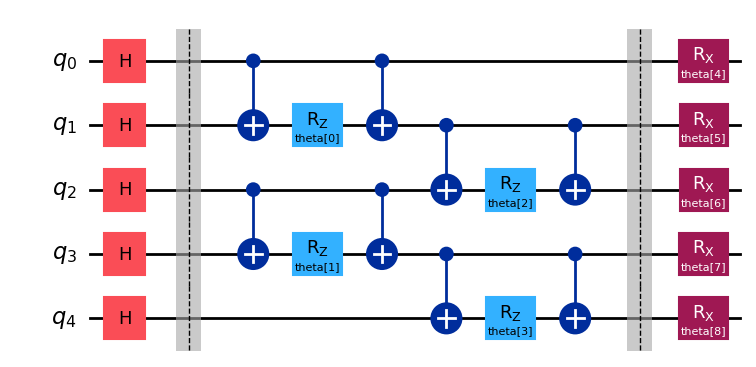

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

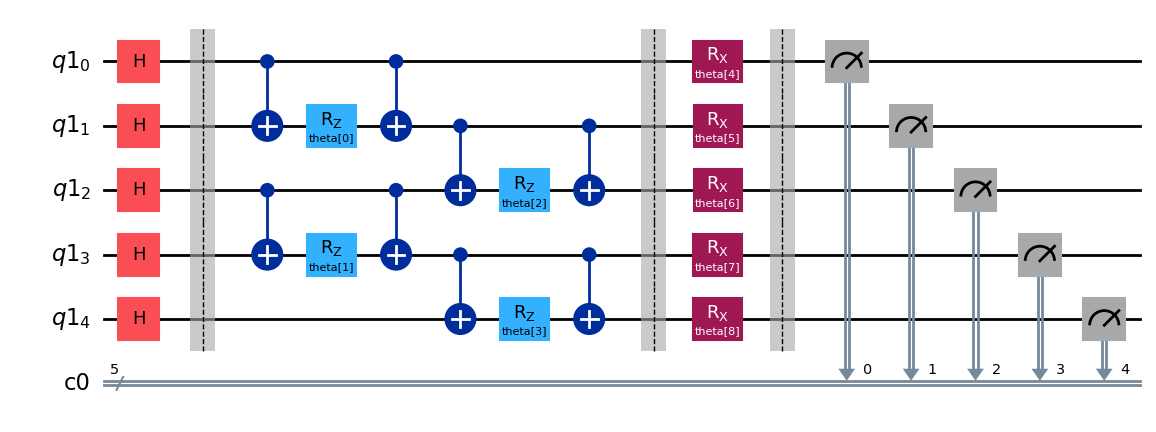

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

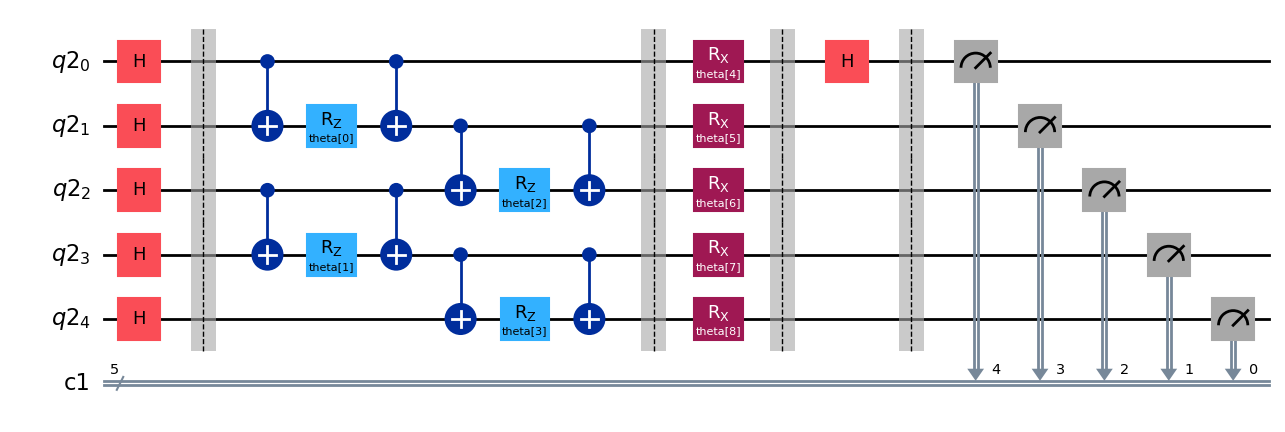

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

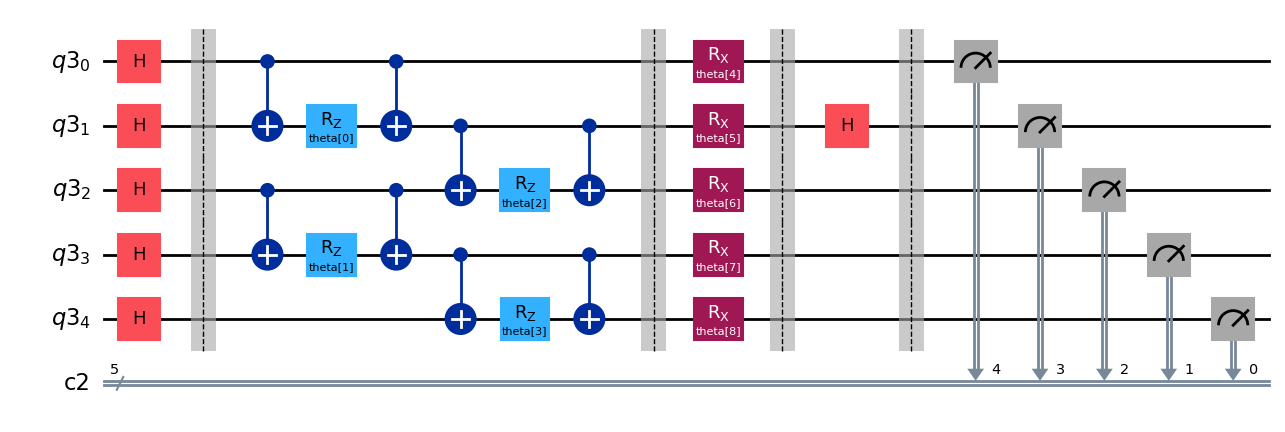

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

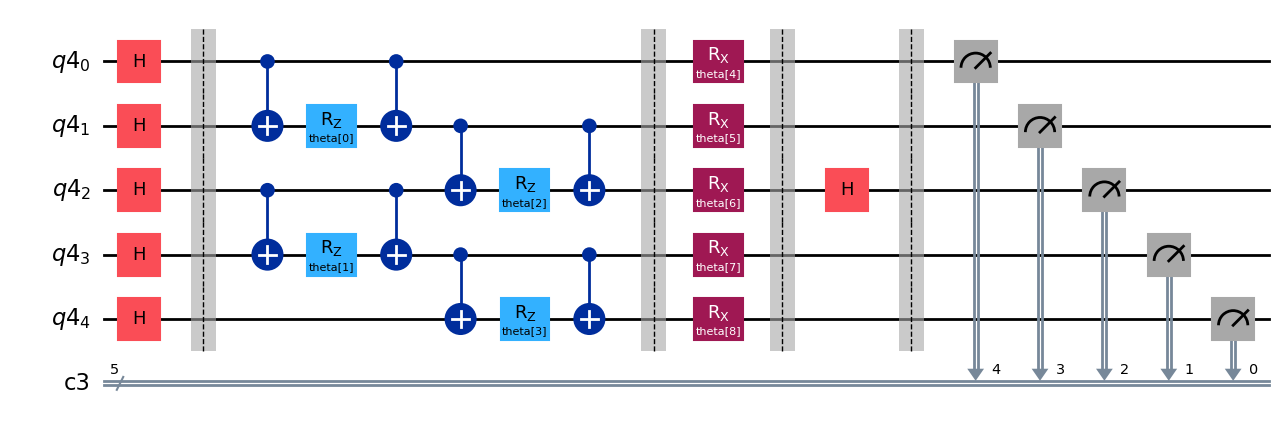

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

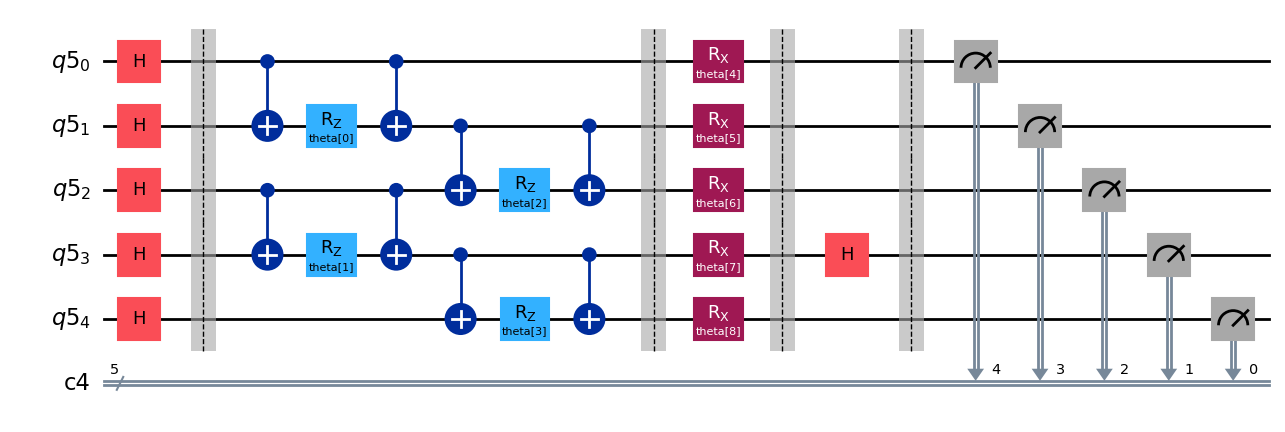

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

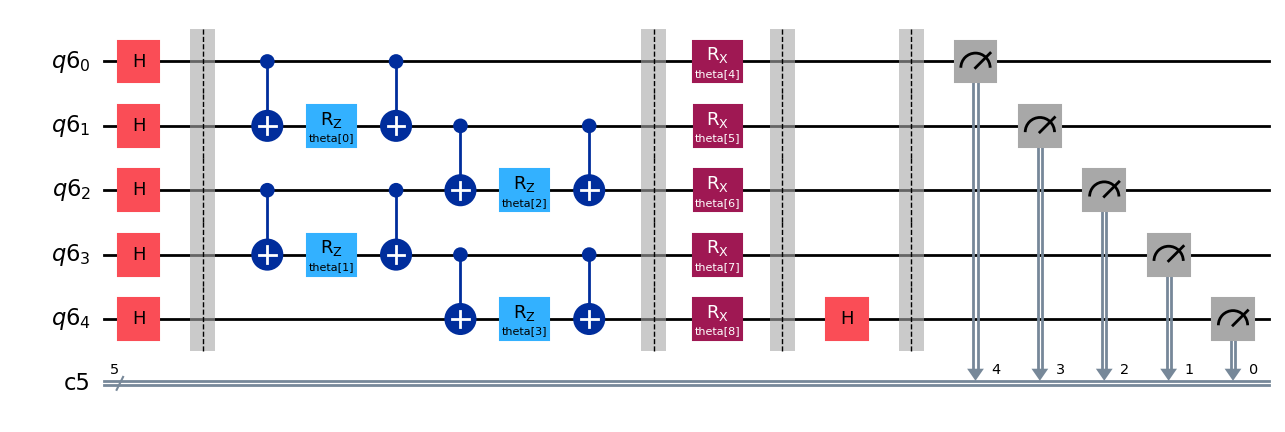

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


def cnn3(vec, x):
  a = vec[0]
  b = vec[1]
  c = vec[2]

  lst = []
  lst.append(c*x[0])
  lst.append(b*x[0]+c*x[1])
  lst.append(a*x[0]+b*x[1]+c*x[2])
  lst.append(a*x[1]+b*x[2]+c*x[3])
  lst.append(a*x[2]+b*x[3]+c*x[4])
  lst.append(a*x[3]+b*x[4])
  lst.append(a*x[4])

  lst = np.array(lst)

  return np.max(lst)


def cnn5(vec, x):
  a = vec[0]
  b = vec[1]
  c = vec[2]
  d = vec[3]
  e = vec[4]

  lst = []
  lst.append(e*x[0])
  lst.append(d*x[0]+e*x[1])
  lst.append(c*x[0]+d*x[1]+e*x[2])
  lst.append(b*x[0]+c*x[1]+d*x[2]+e*x[3])
  lst.append(a*x[0]+b*x[1]+c*x[2]+d*x[3]+e*x[4])
  lst.append(a*x[1]+b*x[2]+c*x[3]+d*x[4])
  lst.append(a*x[2]+b*x[3]+c*x[4])
  lst.append(a*x[3]+b*x[4])
  lst.append(a*x[4])

  lst = np.array(lst)

  return np.max(lst)


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  a1 = np.array([cnn3(parameter[0:3], x), cnn3(parameter[3:6], x), cnn3(parameter[6:9], x), cnn3(parameter[9:12], x), cnn5(parameter[12:17], x), cnn5(parameter[17:22], x)])
  z1 = relu(a1)

  FC1 = parameter[22:52]
  FC2 = parameter[52:57]
  c = parameter[57]

  FC1 = FC1.reshape(5,6)
  FC2 = FC2.reshape(1,5)


  a2 = np.matmul(FC1, z1)
  z2 = relu(a2)

  a3 = np.matmul(FC2, z2)
  y = output_activate(c, a3)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=10000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1]

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=58), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=58), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

error rate : 0.0, lowest energy vqe : -5.831799999999999

error rate : 0.001, lowest energy vqe : -5.8191999999999995

error rate : 0.002, lowest energy vqe : -5.775000000000001

error rate : 0.003, lowest energy vqe : -5.782000000000001

error rate : 0.004, lowest energy vqe : -5.7467999999999995

error rate : 0.005, lowest energy vqe : -5.742000000000001

error rate : 0.006, lowest energy vqe : -5.6944

error rate : 0.007, lowest energy vqe : -5.709399999999999

error rate : 0.008, lowest energy vqe : -5.684400000000002

error rate : 0.009000000000000001, lowest energy vqe : -5.6546

error rate : 0.01, lowest energy vqe : -5.6246

error rate : 0.02, lowest energy vqe : -5.4496

error rate : 0.03, lowest energy vqe : -5.256800000000002

error rate : 0.04, lowest energy vqe : -5.056400000000001

error rate : 0.05, lowest energy vqe : -4.8721999999999985

error rate : 0.06, lowest energy vqe : -4.706800000000002

error rate : 0.07, lowest energy vqe : -4.576600000000001

error rate : 0.

In [ ]:
lowest_energy_vqe_list

[-5.831799999999999,
 -5.8191999999999995,
 -5.775000000000001,
 -5.782000000000001,
 -5.7467999999999995,
 -5.742000000000001,
 -5.6944,
 -5.709399999999999,
 -5.684400000000002,
 -5.6546,
 -5.6246,
 -5.4496,
 -5.256800000000002,
 -5.056400000000001,
 -4.8721999999999985,
 -4.706800000000002,
 -4.576600000000001,
 -4.430999999999998,
 -4.254599999999999,
 -4.114799999999999]

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=58), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=58), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+10, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(58) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 300
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if len(local_minimum_dict) and local_minimum_dict[-1] < lowest_energy_vqnhe :
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

error rate : 0.0, lowest energy vqe : -5.831799999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.921291
         Iterations: 22
         Function evaluations: 5320
         Gradient evaluations: 90


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.907273
         Iterations: 57
         Function evaluations: 7505
         Gradient evaluations: 127


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.901289
         Iterations: 14
         Function evaluations: 6264
         Gradient evaluations: 106
Optimization terminated successfully.
         Current function value: -5.923765
         Iterations: 138
         Function evaluations: 12036
         Gradient evaluations: 204
Optimization terminated successfully.
         Current function value: -5.907844
         Iterations: 156
         Function evaluations: 11446
         Gradient evaluations: 194
Optimization terminated successfully.
         Current function value: -5.902890
         Iterations: 89
         Function evaluations: 6136
         Gradient evaluations: 104


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.928667
         Iterations: 162
         Function evaluations: 23788
         Gradient evaluations: 403
Optimization terminated successfully.
         Current function value: -5.909981
         Iterations: 64
         Function evaluations: 4425
         Gradient evaluations: 75


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.918999
         Iterations: 115
         Function evaluations: 15169
         Gradient evaluations: 257
Optimization terminated successfully.
         Current function value: -5.934762
         Iterations: 89
         Function evaluations: 6490
         Gradient evaluations: 110
error rate : 0.0, lowest energy vqnhe : -5.934762386206508



error rate : 0.001, lowest energy vqe : -5.8191999999999995

Optimization terminated successfully.
         Current function value: -5.902199
         Iterations: 40
         Function evaluations: 3717
         Gradient evaluations: 63


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.910365
         Iterations: 145
         Function evaluations: 13760
         Gradient evaluations: 233


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.877647
         Iterations: 74
         Function evaluations: 8331
         Gradient evaluations: 141
Optimization terminated successfully.
         Current function value: -5.866492
         Iterations: 9
         Function evaluations: 885
         Gradient evaluations: 15


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.886566
         Iterations: 128
         Function evaluations: 15052
         Gradient evaluations: 255


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.900446
         Iterations: 105
         Function evaluations: 13994
         Gradient evaluations: 237


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.875124
         Iterations: 270
         Function evaluations: 21488
         Gradient evaluations: 364


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.906568
         Iterations: 102
         Function evaluations: 10155
         Gradient evaluations: 172


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.907030
         Iterations: 167
         Function evaluations: 14045
         Gradient evaluations: 238
Optimization terminated successfully.
         Current function value: -5.901115
         Iterations: 74
         Function evaluations: 9558
         Gradient evaluations: 162
error rate : 0.001, lowest energy vqnhe : -5.910364574282638



error rate : 0.002, lowest energy vqe : -5.775000000000001

Optimization terminated successfully.
         Current function value: -5.776678
         Iterations: 19
         Function evaluations: 1357
         Gradient evaluations: 23


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.889693
         Iterations: 64
         Function evaluations: 10274
         Gradient evaluations: 174


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.875088
         Iterations: 39
         Function evaluations: 8270
         Gradient evaluations: 140


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.896962
         Iterations: 120
         Function evaluations: 13755
         Gradient evaluations: 233
Optimization terminated successfully.
         Current function value: -5.776678
         Iterations: 11
         Function evaluations: 708
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: -5.776678
         Iterations: 22
         Function evaluations: 1475
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: -5.832054
         Iterations: 27
         Function evaluations: 2006
         Gradient evaluations: 34


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.898335
         Iterations: 90
         Function evaluations: 10982
         Gradient evaluations: 186


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.907800
         Iterations: 41
         Function evaluations: 6317
         Gradient evaluations: 107
Optimization terminated successfully.
         Current function value: -5.776677
         Iterations: 14
         Function evaluations: 1239
         Gradient evaluations: 21
error rate : 0.002, lowest energy vqnhe : -5.9077996320235755



error rate : 0.003, lowest energy vqe : -5.782000000000001

Optimization terminated successfully.
         Current function value: -5.911664
         Iterations: 43
         Function evaluations: 2891
         Gradient evaluations: 49


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.894281
         Iterations: 44
         Function evaluations: 6561
         Gradient evaluations: 111
Optimization terminated successfully.
         Current function value: -5.882036
         Iterations: 34
         Function evaluations: 2124
         Gradient evaluations: 36


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.880098
         Iterations: 38
         Function evaluations: 6973
         Gradient evaluations: 118
Optimization terminated successfully.
         Current function value: -5.893630
         Iterations: 69
         Function evaluations: 5015
         Gradient evaluations: 85
Optimization terminated successfully.
         Current function value: -5.894711
         Iterations: 73
         Function evaluations: 5133
         Gradient evaluations: 87
Optimization terminated successfully.
         Current function value: -5.887433
         Iterations: 97
         Function evaluations: 11151
         Gradient evaluations: 189


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.894093
         Iterations: 77
         Function evaluations: 11281
         Gradient evaluations: 191


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.858477
         Iterations: 140
         Function evaluations: 13577
         Gradient evaluations: 230


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.912631
         Iterations: 33
         Function evaluations: 6029
         Gradient evaluations: 102
error rate : 0.003, lowest energy vqnhe : -5.9126311375680665



error rate : 0.004, lowest energy vqe : -5.7467999999999995

Optimization terminated successfully.
         Current function value: -5.812362
         Iterations: 63
         Function evaluations: 4366
         Gradient evaluations: 74
Optimization terminated successfully.
         Current function value: -5.746800
         Iterations: 0
         Function evaluations: 59
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.839014
         Iterations: 31
         Function evaluations: 5732
         Gradient evaluations: 97


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.812800
         Iterations: 116
         Function evaluations: 17122
         Gradient evaluations: 290


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.835715
         Iterations: 42
         Function evaluations: 7498
         Gradient evaluations: 127
Optimization terminated successfully.
         Current function value: -5.763663
         Iterations: 48
         Function evaluations: 4484
         Gradient evaluations: 76


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.811553
         Iterations: 46
         Function evaluations: 9865
         Gradient evaluations: 167
Optimization terminated successfully.
         Current function value: -5.838526
         Iterations: 108
         Function evaluations: 7729
         Gradient evaluations: 131


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.837295
         Iterations: 77
         Function evaluations: 10809
         Gradient evaluations: 183
Optimization terminated successfully.
         Current function value: -5.771713
         Iterations: 62
         Function evaluations: 6667
         Gradient evaluations: 113
error rate : 0.004, lowest energy vqnhe : -5.839014355137



error rate : 0.005, lowest energy vqe : -5.742000000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.812529
         Iterations: 22
         Function evaluations: 5434
         Gradient evaluations: 92


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.850424
         Iterations: 68
         Function evaluations: 8681
         Gradient evaluations: 147
Optimization terminated successfully.
         Current function value: -5.742000
         Iterations: 3
         Function evaluations: 236
         Gradient evaluations: 4


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.830062
         Iterations: 59
         Function evaluations: 6789
         Gradient evaluations: 115


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.851150
         Iterations: 115
         Function evaluations: 16116
         Gradient evaluations: 273
Optimization terminated successfully.
         Current function value: -5.788139
         Iterations: 24
         Function evaluations: 1711
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: -5.820488
         Iterations: 25
         Function evaluations: 1770
         Gradient evaluations: 30


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.833598
         Iterations: 84
         Function evaluations: 11332
         Gradient evaluations: 192


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.850058
         Iterations: 65
         Function evaluations: 10691
         Gradient evaluations: 181


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.850638
         Iterations: 158
         Function evaluations: 16532
         Gradient evaluations: 280
error rate : 0.005, lowest energy vqnhe : -5.851149824677052



error rate : 0.006, lowest energy vqe : -5.6944

Optimization terminated successfully.
         Current function value: -5.793980
         Iterations: 49
         Function evaluations: 3245
         Gradient evaluations: 55


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.809258
         Iterations: 148
         Function evaluations: 16118
         Gradient evaluations: 273
Optimization terminated successfully.
         Current function value: -5.839283
         Iterations: 96
         Function evaluations: 6608
         Gradient evaluations: 112


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.803404
         Iterations: 22
         Function evaluations: 7207
         Gradient evaluations: 122


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.797243
         Iterations: 39
         Function evaluations: 8567
         Gradient evaluations: 145
Optimization terminated successfully.
         Current function value: -5.795508
         Iterations: 124
         Function evaluations: 11328
         Gradient evaluations: 192
Optimization terminated successfully.
         Current function value: -5.735935
         Iterations: 20
         Function evaluations: 1534
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.847963
         Iterations: 23
         Function evaluations: 5027
         Gradient evaluations: 85


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.805502
         Iterations: 37
         Function evaluations: 5967
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: -5.811619
         Iterations: 90
         Function evaluations: 6608
         Gradient evaluations: 112
error rate : 0.006, lowest energy vqnhe : -5.847962652917124



error rate : 0.007, lowest energy vqe : -5.709399999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.834249
         Iterations: 27
         Function evaluations: 6089
         Gradient evaluations: 103
Optimization terminated successfully.
         Current function value: -5.832046
         Iterations: 60
         Function evaluations: 3953
         Gradient evaluations: 67
Optimization terminated successfully.
         Current function value: -5.832047
         Iterations: 93
         Function evaluations: 7257
         Gradient evaluations: 123
Optimization terminated successfully.
         Current function value: -5.863555
         Iterations: 59
         Function evaluations: 4897
         Gradient evaluations: 83


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.848710
         Iterations: 49
         Function evaluations: 7558
         Gradient evaluations: 128
Optimization terminated successfully.
         Current function value: -5.797707
         Iterations: 46
         Function evaluations: 3953
         Gradient evaluations: 67


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.810065
         Iterations: 12
         Function evaluations: 4555
         Gradient evaluations: 77
Optimization terminated successfully.
         Current function value: -5.836710
         Iterations: 121
         Function evaluations: 8496
         Gradient evaluations: 144


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.804589
         Iterations: 54
         Function evaluations: 10332
         Gradient evaluations: 175


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.805082
         Iterations: 24
         Function evaluations: 6443
         Gradient evaluations: 109
error rate : 0.007, lowest energy vqnhe : -5.863555390109498



error rate : 0.008, lowest energy vqe : -5.684400000000002

Optimization terminated successfully.
         Current function value: -5.775648
         Iterations: 42
         Function evaluations: 2950
         Gradient evaluations: 50


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.726023
         Iterations: 20
         Function evaluations: 6022
         Gradient evaluations: 102


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.787364
         Iterations: 99
         Function evaluations: 13757
         Gradient evaluations: 233


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.796416
         Iterations: 33
         Function evaluations: 5381
         Gradient evaluations: 91
Optimization terminated successfully.
         Current function value: -5.684400
         Iterations: 1
         Function evaluations: 118
         Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.713457
         Iterations: 48
         Function evaluations: 9919
         Gradient evaluations: 168


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.789410
         Iterations: 160
         Function evaluations: 17413
         Gradient evaluations: 295
Optimization terminated successfully.
         Current function value: -5.777083
         Iterations: 73
         Function evaluations: 5074
         Gradient evaluations: 86


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.767961
         Iterations: 52
         Function evaluations: 6971
         Gradient evaluations: 118
Optimization terminated successfully.
         Current function value: -5.756223
         Iterations: 209
         Function evaluations: 18526
         Gradient evaluations: 314
error rate : 0.008, lowest energy vqnhe : -5.79641625818793



error rate : 0.009000000000000001, lowest energy vqe : -5.6546

Optimization terminated successfully.
         Current function value: -5.751818
         Iterations: 68
         Function evaluations: 5841
         Gradient evaluations: 99


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.772321
         Iterations: 70
         Function evaluations: 8861
         Gradient evaluations: 150
Optimization terminated successfully.
         Current function value: -5.654600
         Iterations: 1
         Function evaluations: 118
         Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.742835
         Iterations: 32
         Function evaluations: 6030
         Gradient evaluations: 102
Optimization terminated successfully.
         Current function value: -5.774020
         Iterations: 178
         Function evaluations: 12803
         Gradient evaluations: 217


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.754655
         Iterations: 95
         Function evaluations: 12101
         Gradient evaluations: 205
Optimization terminated successfully.
         Current function value: -5.756995
         Iterations: 174
         Function evaluations: 13747
         Gradient evaluations: 233
Optimization terminated successfully.
         Current function value: -5.731580
         Iterations: 28
         Function evaluations: 2065
         Gradient evaluations: 35


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.766764
         Iterations: 70
         Function evaluations: 8685
         Gradient evaluations: 147


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.748362
         Iterations: 63
         Function evaluations: 9268
         Gradient evaluations: 157
error rate : 0.009000000000000001, lowest energy vqnhe : -5.774020466405544



error rate : 0.01, lowest energy vqe : -5.6246



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.739498
         Iterations: 163
         Function evaluations: 18597
         Gradient evaluations: 315


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.682875
         Iterations: 13
         Function evaluations: 5853
         Gradient evaluations: 99
Optimization terminated successfully.
         Current function value: -5.667183
         Iterations: 92
         Function evaluations: 6490
         Gradient evaluations: 110


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.700832
         Iterations: 43
         Function evaluations: 9978
         Gradient evaluations: 169
Optimization terminated successfully.
         Current function value: -5.734562
         Iterations: 115
         Function evaluations: 12862
         Gradient evaluations: 218
Optimization terminated successfully.
         Current function value: -5.707906
         Iterations: 33
         Function evaluations: 4602
         Gradient evaluations: 78


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.687691
         Iterations: 16
         Function evaluations: 6148
         Gradient evaluations: 104


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.731469
         Iterations: 246
         Function evaluations: 24494
         Gradient evaluations: 415
Optimization terminated successfully.
         Current function value: -5.747105
         Iterations: 63
         Function evaluations: 4130
         Gradient evaluations: 70
Optimization terminated successfully.
         Current function value: -5.720767
         Iterations: 70
         Function evaluations: 4543
         Gradient evaluations: 77
error rate : 0.01, lowest energy vqnhe : -5.7471048825318505



error rate : 0.02, lowest energy vqe : -5.4496

Optimization terminated successfully.
         Current function value: -5.601099
         Iterations: 51
         Function evaluations: 3776
         Gradient evaluations: 64
Optimization terminated successfully.
         Current function value: -5.449792
         Iterations: 9
         Function evaluations: 885
         Gradient evaluations: 15


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.503429
         Iterations: 76
         Function evaluations: 10399
         Gradient evaluations: 176
Optimization terminated successfully.
         Current function value: -5.647613
         Iterations: 107
         Function evaluations: 7670
         Gradient evaluations: 130
Optimization terminated successfully.
         Current function value: -5.612227
         Iterations: 59
         Function evaluations: 4189
         Gradient evaluations: 71


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.521830
         Iterations: 17
         Function evaluations: 8916
         Gradient evaluations: 151


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.615919
         Iterations: 58
         Function evaluations: 7387
         Gradient evaluations: 125


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.645753
         Iterations: 61
         Function evaluations: 9268
         Gradient evaluations: 157
Optimization terminated successfully.
         Current function value: -5.598766
         Iterations: 41
         Function evaluations: 3481
         Gradient evaluations: 59
Optimization terminated successfully.
         Current function value: -5.449793
         Iterations: 19
         Function evaluations: 1180
         Gradient evaluations: 20
error rate : 0.02, lowest energy vqnhe : -5.647612827534936



error rate : 0.03, lowest energy vqe : -5.256800000000002



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.468389
         Iterations: 56
         Function evaluations: 6384
         Gradient evaluations: 108


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.463207
         Iterations: 57
         Function evaluations: 6970
         Gradient evaluations: 118


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.500939
         Iterations: 63
         Function evaluations: 10040
         Gradient evaluations: 170


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.468362
         Iterations: 178
         Function evaluations: 26445
         Gradient evaluations: 448
Optimization terminated successfully.
         Current function value: -5.449245
         Iterations: 45
         Function evaluations: 2950
         Gradient evaluations: 50
Optimization terminated successfully.
         Current function value: -5.458254
         Iterations: 74
         Function evaluations: 5428
         Gradient evaluations: 92
Optimization terminated successfully.
         Current function value: -5.332739
         Iterations: 35
         Function evaluations: 2242
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: -5.313455
         Iterations: 14
         Function evaluations: 1593
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.469217
         Iterations: 83
         Function evaluations: 13757
         Gradient evaluations: 233


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.459632
         Iterations: 20
         Function evaluations: 5616
         Gradient evaluations: 95
error rate : 0.03, lowest energy vqnhe : -5.500938544650709



error rate : 0.04, lowest energy vqe : -5.056400000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.370238
         Iterations: 134
         Function evaluations: 11800
         Gradient evaluations: 200


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.321191
         Iterations: 111
         Function evaluations: 10750
         Gradient evaluations: 182


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.238903
         Iterations: 23
         Function evaluations: 5433
         Gradient evaluations: 92


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.320678
         Iterations: 286
         Function evaluations: 28685
         Gradient evaluations: 486
Optimization terminated successfully.
         Current function value: -5.317233
         Iterations: 73
         Function evaluations: 9912
         Gradient evaluations: 168
Optimization terminated successfully.
         Current function value: -5.224413
         Iterations: 25
         Function evaluations: 2124
         Gradient evaluations: 36


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.320132
         Iterations: 171
         Function evaluations: 19718
         Gradient evaluations: 334


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.359094
         Iterations: 37
         Function evaluations: 6383
         Gradient evaluations: 108


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.165435
         Iterations: 68
         Function evaluations: 16886
         Gradient evaluations: 286


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.319797
         Iterations: 133
         Function evaluations: 15881
         Gradient evaluations: 269
error rate : 0.04, lowest energy vqnhe : -5.370238094921813



error rate : 0.05, lowest energy vqe : -4.8721999999999985



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.932129
         Iterations: 39
         Function evaluations: 11927
         Gradient evaluations: 202


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.024193
         Iterations: 10
         Function evaluations: 4732
         Gradient evaluations: 80


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.221453
         Iterations: 218
         Function evaluations: 21665
         Gradient evaluations: 367
Optimization terminated successfully.
         Current function value: -5.230233
         Iterations: 90
         Function evaluations: 9204
         Gradient evaluations: 156


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.184416
         Iterations: 87
         Function evaluations: 10391
         Gradient evaluations: 176
Optimization terminated successfully.
         Current function value: -5.198086
         Iterations: 43
         Function evaluations: 3363
         Gradient evaluations: 57


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.280873
         Iterations: 102
         Function evaluations: 11042
         Gradient evaluations: 187
Optimization terminated successfully.
         Current function value: -5.077373
         Iterations: 28
         Function evaluations: 2006
         Gradient evaluations: 34


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.168147
         Iterations: 18
         Function evaluations: 7382
         Gradient evaluations: 125
Optimization terminated successfully.
         Current function value: -5.220982
         Iterations: 235
         Function evaluations: 23010
         Gradient evaluations: 390
error rate : 0.05, lowest energy vqnhe : -5.28087262591312



error rate : 0.06, lowest energy vqe : -4.706800000000002



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.112681
         Iterations: 112
         Function evaluations: 13041
         Gradient evaluations: 221
Optimization terminated successfully.
         Current function value: -4.873475
         Iterations: 30
         Function evaluations: 2006
         Gradient evaluations: 34
Optimization terminated successfully.
         Current function value: -5.127377
         Iterations: 93
         Function evaluations: 6490
         Gradient evaluations: 110


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.110445
         Iterations: 51
         Function evaluations: 6318
         Gradient evaluations: 107
Optimization terminated successfully.
         Current function value: -4.714612
         Iterations: 9
         Function evaluations: 708
         Gradient evaluations: 12


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.185074
         Iterations: 112
         Function evaluations: 12991
         Gradient evaluations: 220


<ipython-input-13-c012253b3d3e>:8: RuntimeWarning: overflow encountered in exp
  return np.exp(c*np.tanh(x))
<ipython-input-16-942dbc8389c9>:11: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-16-942dbc8389c9>:26: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-16-942dbc8389c9>:41: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-16-942dbc8389c9>:54: RuntimeWarning: invalid value encountered in scalar add
  expval = expval + prob_string[k]*nnval[k]
<ipython-input-13-c012253b3d3e>:8: RuntimeWarning: overflow encountered in exp
  return np.exp(c*np.tanh(x))
<ipython-input-16-942dbc8389c9>:11: RuntimeWarning: invalid value encountered in scalar subtract
  expval = expval - prob_string[k]*nnval[k]
<ipython-input-16-942dbc8389c9>:26: RuntimeWarning: invalid value encountered in s

         Current function value: nan
         Iterations: 187
         Function evaluations: 22597
         Gradient evaluations: 383
Optimization terminated successfully.
         Current function value: -5.103196
         Iterations: 76
         Function evaluations: 5487
         Gradient evaluations: 93
Optimization terminated successfully.
         Current function value: -5.105794
         Iterations: 49
         Function evaluations: 4484
         Gradient evaluations: 76


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.931485
         Iterations: 15
         Function evaluations: 7210
         Gradient evaluations: 122
error rate : 0.06, lowest energy vqnhe : -5.1850744865337095



error rate : 0.07, lowest energy vqe : -4.576600000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.040524
         Iterations: 35
         Function evaluations: 5321
         Gradient evaluations: 90
Optimization terminated successfully.
         Current function value: -5.023852
         Iterations: 85
         Function evaluations: 6313
         Gradient evaluations: 107


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.963012
         Iterations: 103
         Function evaluations: 11398
         Gradient evaluations: 193
Optimization terminated successfully.
         Current function value: -5.010025
         Iterations: 12
         Function evaluations: 1711
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: -4.962647
         Iterations: 20
         Function evaluations: 1534
         Gradient evaluations: 26


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.124235
         Iterations: 131
         Function evaluations: 15529
         Gradient evaluations: 263


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.041345
         Iterations: 94
         Function evaluations: 16768
         Gradient evaluations: 284


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.103155
         Iterations: 23
         Function evaluations: 6794
         Gradient evaluations: 115


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.930207
         Iterations: 20
         Function evaluations: 6738
         Gradient evaluations: 114


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.045894
         Iterations: 164
         Function evaluations: 18418
         Gradient evaluations: 312
error rate : 0.07, lowest energy vqnhe : -5.124235237504264



error rate : 0.08, lowest energy vqe : -4.430999999999998



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.973191
         Iterations: 279
         Function evaluations: 23669
         Gradient evaluations: 401


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.077314
         Iterations: 82
         Function evaluations: 11334
         Gradient evaluations: 192
Optimization terminated successfully.
         Current function value: -4.927131
         Iterations: 42
         Function evaluations: 3363
         Gradient evaluations: 57
Optimization terminated successfully.
         Current function value: -5.020700
         Iterations: 19
         Function evaluations: 1593
         Gradient evaluations: 27


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.077036
         Iterations: 123
         Function evaluations: 16060
         Gradient evaluations: 272
Optimization terminated successfully.
         Current function value: -4.431000
         Iterations: 2
         Function evaluations: 236
         Gradient evaluations: 4


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.968494
         Iterations: 48
         Function evaluations: 7564
         Gradient evaluations: 128


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.859363
         Iterations: 31
         Function evaluations: 11038
         Gradient evaluations: 187
Optimization terminated successfully.
         Current function value: -4.973138
         Iterations: 54
         Function evaluations: 4189
         Gradient evaluations: 71
Optimization terminated successfully.
         Current function value: -4.960030
         Iterations: 40
         Function evaluations: 2714
         Gradient evaluations: 46
error rate : 0.08, lowest energy vqnhe : -5.0773144215044415



error rate : 0.09, lowest energy vqe : -4.254599999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.850977
         Iterations: 173
         Function evaluations: 25614
         Gradient evaluations: 434
Optimization terminated successfully.
         Current function value: -4.254600
         Iterations: 1
         Function evaluations: 118
         Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.842819
         Iterations: 41
         Function evaluations: 9039
         Gradient evaluations: 153


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.844959
         Iterations: 114
         Function evaluations: 16352
         Gradient evaluations: 277
Optimization terminated successfully.
         Current function value: -4.859946
         Iterations: 83
         Function evaluations: 5841
         Gradient evaluations: 99
Optimization terminated successfully.
         Current function value: -4.717769
         Iterations: 14
         Function evaluations: 1003
         Gradient evaluations: 17


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.864412
         Iterations: 76
         Function evaluations: 10749
         Gradient evaluations: 182
Optimization terminated successfully.
         Current function value: -4.642042
         Iterations: 34
         Function evaluations: 2832
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: -4.824416
         Iterations: 34
         Function evaluations: 2714
         Gradient evaluations: 46


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.947640
         Iterations: 48
         Function evaluations: 6435
         Gradient evaluations: 109
error rate : 0.09, lowest energy vqnhe : -4.947640136028408



error rate : 0.1, lowest energy vqe : -4.114799999999999

Optimization terminated successfully.
         Current function value: -4.662587
         Iterations: 12
         Function evaluations: 1121
         Gradient evaluations: 19


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.779008
         Iterations: 74
         Function evaluations: 7975
         Gradient evaluations: 135


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.771335
         Iterations: 49
         Function evaluations: 8031
         Gradient evaluations: 136
Optimization terminated successfully.
         Current function value: -4.668054
         Iterations: 26
         Function evaluations: 2006
         Gradient evaluations: 34


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.381506
         Iterations: 26
         Function evaluations: 5020
         Gradient evaluations: 85


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -4.780108
         Iterations: 80
         Function evaluations: 9805
         Gradient evaluations: 166
Optimization terminated successfully.
         Current function value: -4.794418
         Iterations: 79
         Function evaluations: 5310
         Gradient evaluations: 90
Optimization terminated successfully.
         Current function value: -4.925074
         Iterations: 113
         Function evaluations: 7493
         Gradient evaluations: 127
Optimization terminated successfully.
         Current function value: -4.188139
         Iterations: 13
         Function evaluations: 1121
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: -4.630100
         Iterations: 178
         Function evaluations: 13334
         Gradient evaluations: 226
error rate : 0.1, lowest energy vqnhe : -4.925073659192205





In [ ]:
lowest_energy_vqnhe_list

[-5.934762386206508,
 -5.910364574282638,
 -5.9077996320235755,
 -5.9126311375680665,
 -5.839014355137,
 -5.851149824677052,
 -5.847962652917124,
 -5.863555390109498,
 -5.79641625818793,
 -5.774020466405544,
 -5.7471048825318505,
 -5.647612827534936,
 -5.500938544650709,
 -5.370238094921813,
 -5.28087262591312,
 -5.1850744865337095,
 -5.124235237504264,
 -5.0773144215044415,
 -4.947640136028408,
 -4.925073659192205]

## Depolarization Channel, Error 0.001~0.1, Shots = 10000, CNN ver 4

1. Optimize Parameters in PQC

2. Fix Parameters in PQC and Connect Neural Net Layer, Optimize Parameters in Neural Net

### Ansatz, Hamiltonian, Sampler & Estimator Setting

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit_aer.primitives import Estimator, Sampler

import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

In [ ]:
# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(9):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

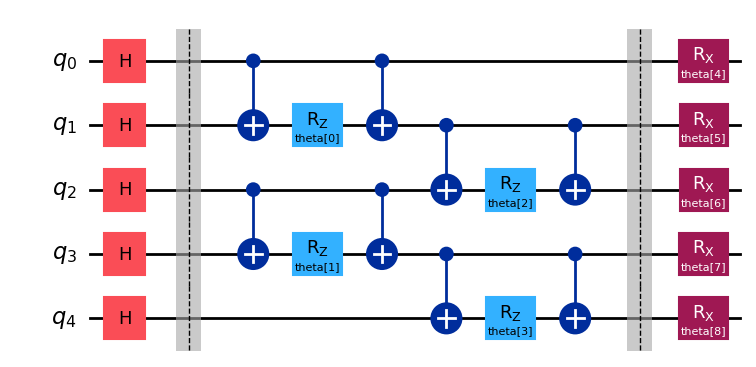

In [ ]:
# Ansatz for VQE

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

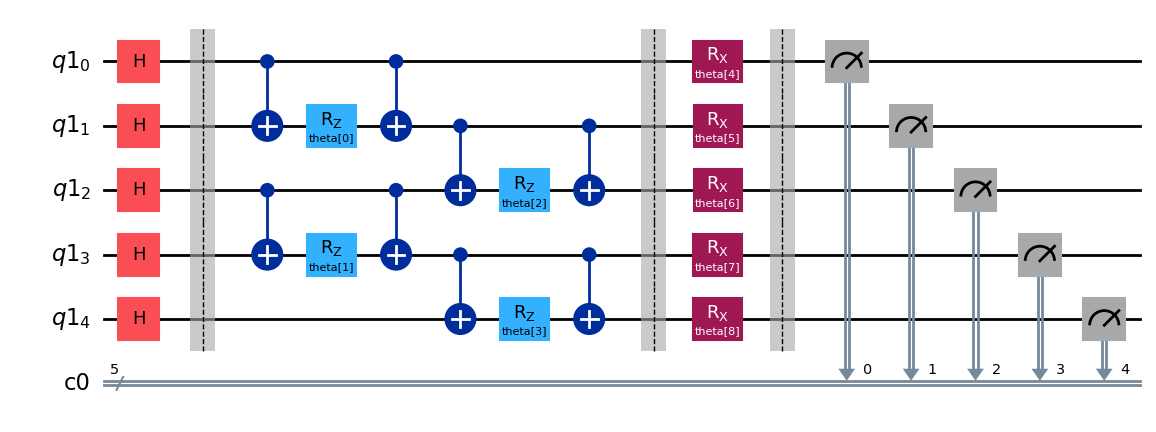

In [ ]:
# Ansatz for VQNHE ZZ Measurement

qbit = QuantumRegister(5)
cbit = ClassicalRegister(5)

ansatz_zz = QuantumCircuit(qbit, cbit)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_zz.h(range(0,5))

ansatz_zz.barrier()

ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.rz(next(it), 1)
ansatz_zz.rz(next(it), 3)
ansatz_zz.cx(0, 1)
ansatz_zz.cx(2, 3)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)
ansatz_zz.rz(next(it), 2)
ansatz_zz.rz(next(it), 4)
ansatz_zz.cx(1, 2)
ansatz_zz.cx(3, 4)

ansatz_zz.barrier()

ansatz_zz.rx(next(it), 0)
ansatz_zz.rx(next(it), 1)
ansatz_zz.rx(next(it), 2)
ansatz_zz.rx(next(it), 3)
ansatz_zz.rx(next(it), 4)

ansatz_zz.barrier()

ansatz_zz.measure([0,1,2,3,4], [0,1,2,3,4])

ansatz_zz.draw("mpl")

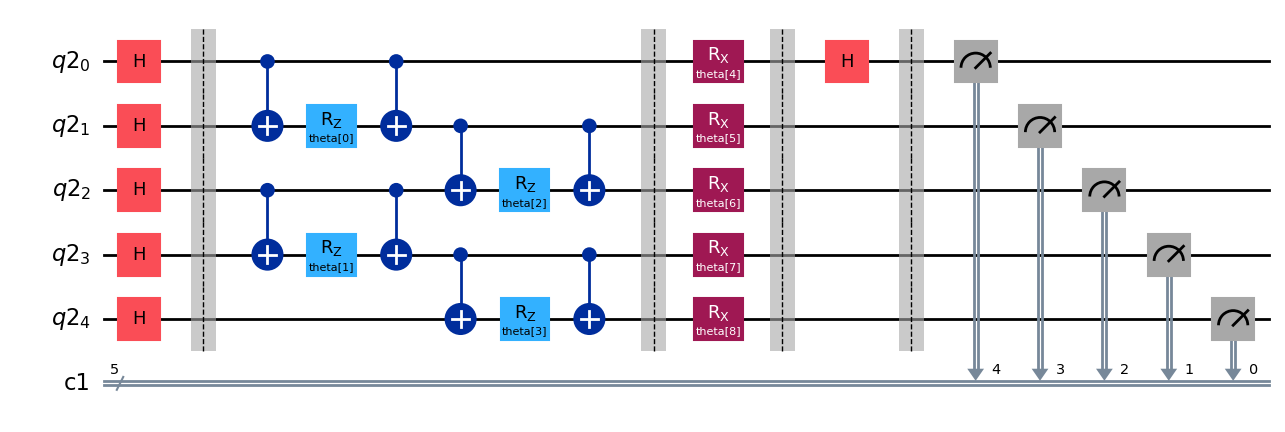

In [ ]:
# Ansatz for VQNHE X0 Measurement

qbit0 = QuantumRegister(5)
cbit0 = ClassicalRegister(5)

ansatz_x0 = QuantumCircuit(qbit0, cbit0)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x0.h(range(0,5))

ansatz_x0.barrier()

ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.rz(next(it), 1)
ansatz_x0.rz(next(it), 3)
ansatz_x0.cx(0, 1)
ansatz_x0.cx(2, 3)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)
ansatz_x0.rz(next(it), 2)
ansatz_x0.rz(next(it), 4)
ansatz_x0.cx(1, 2)
ansatz_x0.cx(3, 4)

ansatz_x0.barrier()

ansatz_x0.rx(next(it), 0)
ansatz_x0.rx(next(it), 1)
ansatz_x0.rx(next(it), 2)
ansatz_x0.rx(next(it), 3)
ansatz_x0.rx(next(it), 4)

ansatz_x0.barrier()

ansatz_x0.h(0)

ansatz_x0.barrier()

ansatz_x0.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x0.draw("mpl")

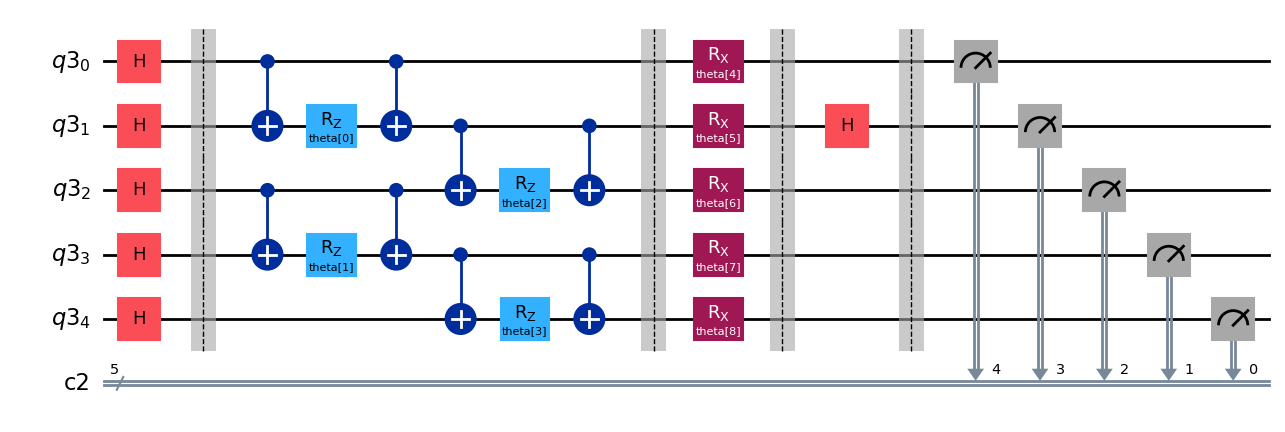

In [ ]:
# Ansatz for VQNHE X1 Measurement

qbit1 = QuantumRegister(5)
cbit1 = ClassicalRegister(5)

ansatz_x1 = QuantumCircuit(qbit1, cbit1)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x1.h(range(0,5))

ansatz_x1.barrier()

ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.rz(next(it), 1)
ansatz_x1.rz(next(it), 3)
ansatz_x1.cx(0, 1)
ansatz_x1.cx(2, 3)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)
ansatz_x1.rz(next(it), 2)
ansatz_x1.rz(next(it), 4)
ansatz_x1.cx(1, 2)
ansatz_x1.cx(3, 4)

ansatz_x1.barrier()

ansatz_x1.rx(next(it), 0)
ansatz_x1.rx(next(it), 1)
ansatz_x1.rx(next(it), 2)
ansatz_x1.rx(next(it), 3)
ansatz_x1.rx(next(it), 4)

ansatz_x1.barrier()

ansatz_x1.h(1)

ansatz_x1.barrier()

ansatz_x1.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x1.draw("mpl")

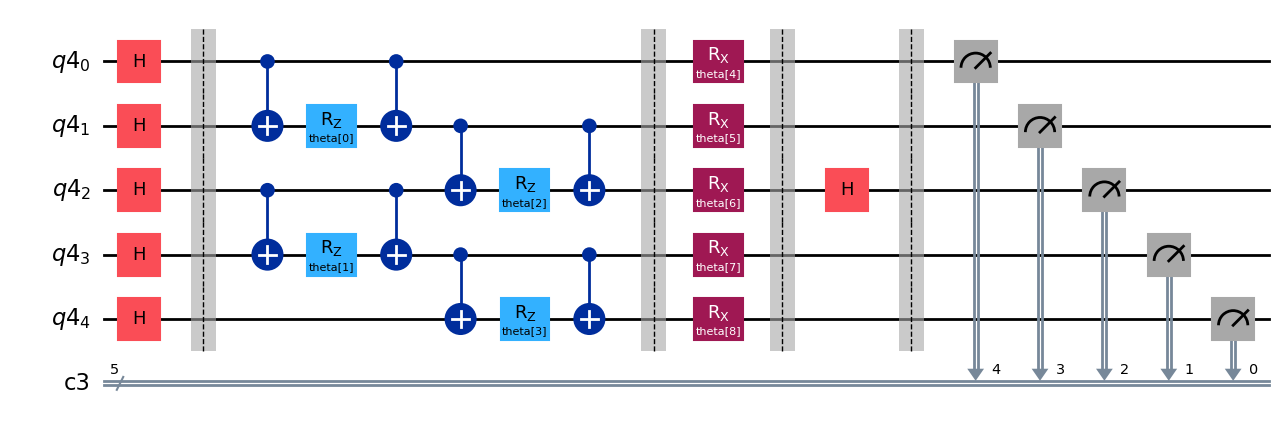

In [ ]:
# Ansatz for VQNHE X2 Measurement

qbit2 = QuantumRegister(5)
cbit2 = ClassicalRegister(5)

ansatz_x2 = QuantumCircuit(qbit2, cbit2)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x2.h(range(0,5))

ansatz_x2.barrier()

ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.rz(next(it), 1)
ansatz_x2.rz(next(it), 3)
ansatz_x2.cx(0, 1)
ansatz_x2.cx(2, 3)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)
ansatz_x2.rz(next(it), 2)
ansatz_x2.rz(next(it), 4)
ansatz_x2.cx(1, 2)
ansatz_x2.cx(3, 4)

ansatz_x2.barrier()

ansatz_x2.rx(next(it), 0)
ansatz_x2.rx(next(it), 1)
ansatz_x2.rx(next(it), 2)
ansatz_x2.rx(next(it), 3)
ansatz_x2.rx(next(it), 4)

ansatz_x2.barrier()

ansatz_x2.h(2)

ansatz_x2.barrier()

ansatz_x2.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x2.draw("mpl")

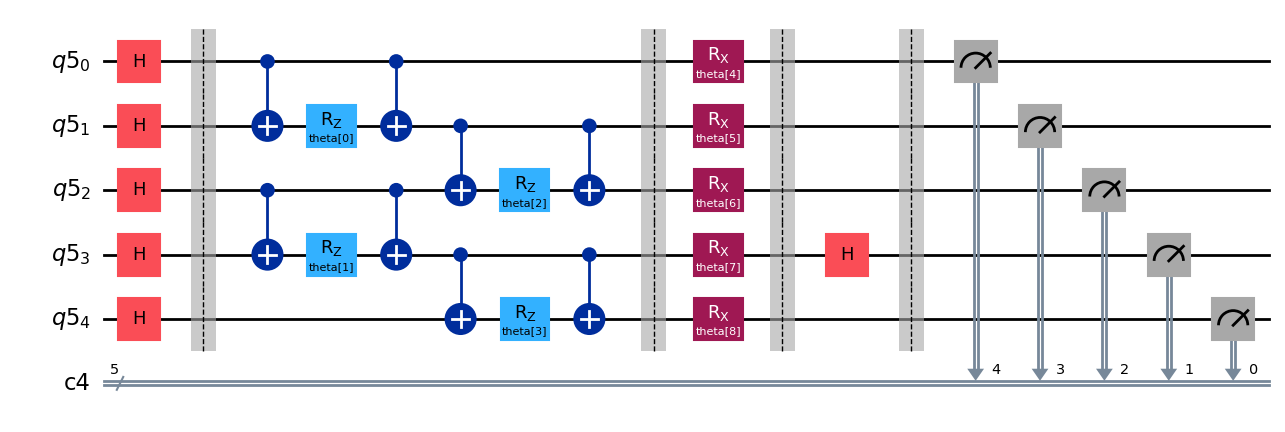

In [ ]:
# Ansatz for VQNHE X3 Measurement

qbit3 = QuantumRegister(5)
cbit3 = ClassicalRegister(5)

ansatz_x3 = QuantumCircuit(qbit3, cbit3)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x3.h(range(0,5))

ansatz_x3.barrier()

ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.rz(next(it), 1)
ansatz_x3.rz(next(it), 3)
ansatz_x3.cx(0, 1)
ansatz_x3.cx(2, 3)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)
ansatz_x3.rz(next(it), 2)
ansatz_x3.rz(next(it), 4)
ansatz_x3.cx(1, 2)
ansatz_x3.cx(3, 4)

ansatz_x3.barrier()

ansatz_x3.rx(next(it), 0)
ansatz_x3.rx(next(it), 1)
ansatz_x3.rx(next(it), 2)
ansatz_x3.rx(next(it), 3)
ansatz_x3.rx(next(it), 4)

ansatz_x3.barrier()

ansatz_x3.h(3)

ansatz_x3.barrier()

ansatz_x3.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x3.draw("mpl")

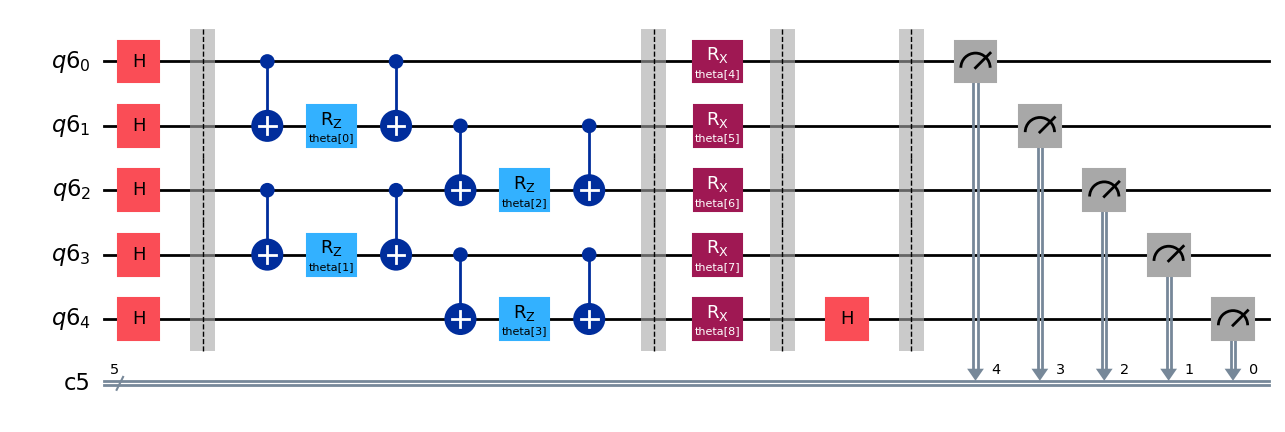

In [ ]:
# Ansatz for VQNHE X4 Measurement

qbit4 = QuantumRegister(5)
cbit4 = ClassicalRegister(5)

ansatz_x4 = QuantumCircuit(qbit4, cbit4)

params = ParameterVector("theta", length=9)
it = iter(params)

ansatz_x4.h(range(0,5))

ansatz_x4.barrier()

ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.rz(next(it), 1)
ansatz_x4.rz(next(it), 3)
ansatz_x4.cx(0, 1)
ansatz_x4.cx(2, 3)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)
ansatz_x4.rz(next(it), 2)
ansatz_x4.rz(next(it), 4)
ansatz_x4.cx(1, 2)
ansatz_x4.cx(3, 4)

ansatz_x4.barrier()

ansatz_x4.rx(next(it), 0)
ansatz_x4.rx(next(it), 1)
ansatz_x4.rx(next(it), 2)
ansatz_x4.rx(next(it), 3)
ansatz_x4.rx(next(it), 4)

ansatz_x4.barrier()

ansatz_x4.h(4)

ansatz_x4.barrier()

ansatz_x4.measure([0,1,2,3,4], [4,3,2,1,0])

ansatz_x4.draw("mpl")

### Cost Function for VQE & VQNHE

In [ ]:
# Activation Function for Neural Network

def relu(x):
  return np.maximum(0, x)


def output_activate(c, x):
  return np.exp(c*np.tanh(x))


def cnn3(vec, x):
  a = vec[0]
  b = vec[1]
  c = vec[2]

  lst = []
  lst.append(b*x[0]+c*x[1])
  lst.append(a*x[0]+b*x[1]+c*x[2])
  lst.append(a*x[1]+b*x[2]+c*x[3])
  lst.append(a*x[2]+b*x[3]+c*x[4])
  lst.append(a*x[3]+b*x[4])

  lst = np.array(lst)

  return lst


def cnn5(vec, x):
  a = vec[0]
  b = vec[1]
  c = vec[2]
  d = vec[3]
  e = vec[4]

  lst = []
  lst.append(c*x[0]+d*x[1]+e*x[2])
  lst.append(b*x[0]+c*x[1]+d*x[2]+e*x[3])
  lst.append(a*x[0]+b*x[1]+c*x[2]+d*x[3]+e*x[4])
  lst.append(a*x[1]+b*x[2]+c*x[3]+d*x[4])
  lst.append(a*x[2]+b*x[3]+c*x[4])

  lst = np.array(lst)

  return lst


def new_cnn(params, x): # x : [6, 5], params : 36 elements (6 * (5 + 1))
  res = np.zeros(6)
  for i in range(6):
    res[i] = np.dot(params[6*i : 6*i+5], x[i]) + params[6*i+5]
  return res


# Neural Network
# Output : f(s)

def neural_net(parameter, x):

  a1 = np.array([cnn3(parameter[0:3], x), cnn3(parameter[3:6], x), cnn3(parameter[6:9], x), cnn3(parameter[9:12], x), cnn5(parameter[12:17], x), cnn5(parameter[17:22], x)])
  z1 = relu(a1)

  a2 = new_cnn(parameter[22:58], z1)
  z2 = relu(a2)

  FC1 = parameter[58:88]
  FC2 = parameter[88:93]
  c = parameter[93]

  FC1 = FC1.reshape(5,6)
  FC2 = FC2.reshape(1,5)


  a3 = np.matmul(FC1, z2)
  z3 = relu(a3)

  a4 = np.matmul(FC2, z3)
  y = output_activate(c, a4)

  return y[0]


# Convert Decimal Number to Binary Number

def d2b(x):

  binary = []

  for _ in range(5):
    binary.append(x % 2)
    x = x // 2

  binary.reverse()

  return np.array(binary)

In [ ]:
@cache
def pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8):

  def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params, shots=10000, seed=1).result()
    return cost.values[0]


  def build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict):
    def callback(current_vector):
      callback_dict_vqe["iters"] += 1
      callback_dict_vqe["prev_vector"] = current_vector
      current_cost_vqe = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

      callback_dict_vqe["cost_history"].append(current_cost_vqe)

      print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict_vqe["iters"], current_cost_vqe),
        end="\r",
        flush=True,
      )

    return callback


  x_pqc_0 = np.array([x0,x1,x2,x3,x4,x5,x6,x7,x8])

  callback_dict_vqe = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  options = dict()
  options["maxiter"] = 50000
  options["disp"] = True

  callback_vqe = build_callback_vqe(ansatz, hamiltonian, estimator, callback_dict_vqe)
  res = minimize(
    cost_func_vqe,
    x_pqc_0,
    args=(ansatz, hamiltonian, estimator),
    method="cobyla",
    callback=callback_vqe,
    options=options
  )

  params_pqc = res.x

  return params_pqc

In [ ]:
@cache
def prob_string_zz(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_zz, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x0(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x0, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x1(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x1, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x2(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x2, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x3(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x3, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string


@cache
def prob_string_x4(x0,x1,x2,x3,x4,x5,x6,x7,x8):
  params_pqc = pqc_params(x0,x1,x2,x3,x4,x5,x6,x7,x8)
  job = sampler.run(ansatz_x4, params_pqc, shots=10000, seed=1).result()
  prob_string = job.quasi_dists[0]

  for i in range(32):
   if not (i in prob_string):  prob_string[i] = 0

  return prob_string

In [ ]:
def Z0Z1(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 8 == 0 or k // 8 == 3:
      expval = expval + prob_string[k]*nnval[k]
    if k // 8 == 1 or k // 8 == 2:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z1Z2(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k // 4 == 0 or k // 4 == 3 or k // 4 == 4 or k // 4 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k // 4 == 1 or k // 4 == 2 or k // 4 == 5 or k // 4 == 6:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z2Z3(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 8 == 0 or k % 8 == 1 or k % 8 == 6 or k % 8 == 7:
      expval = expval + prob_string[k]*nnval[k]
    if k % 8 == 2 or k % 8 == 3 or k % 8 == 4 or k % 8 == 5:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def Z3Z4(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    if k % 4 == 0 or k % 4 == 3:
      expval = expval + prob_string[k]*nnval[k]
    else:
      expval = expval - prob_string[k]*nnval[k]

  return expval


def X0(params_nn, x_pqc_0):
  prob_string = prob_string_x0(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(16):
    delt = prob_string[k] - prob_string[k+16]
    expval = expval + delt*nnval[k]*nnval[k+16]

  return expval


def X1(params_nn, x_pqc_0):
  prob_string = prob_string_x1(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(8):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  for k in range(16,24,1):
    delt = prob_string[k] - prob_string[k+8]
    expval = expval + delt*nnval[k]*nnval[k+8]

  return expval


def X2(params_nn, x_pqc_0):
  prob_string = prob_string_x2(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(4):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(8,12,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(16,20,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  for k in range(24,28,1):
    delt = prob_string[k] - prob_string[k+4]
    expval = expval + delt*nnval[k]*nnval[k+4]

  return expval


def X3(params_nn, x_pqc_0):
  prob_string = prob_string_x3(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,4):
    expval = expval + (prob_string[k] - prob_string[k+2])*nnval[k]*nnval[k+2]
    expval = expval + (prob_string[k+1] - prob_string[k+3])*nnval[k+1]*nnval[k+3]

  return expval


def X4(params_nn, x_pqc_0):
  prob_string = prob_string_x4(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([neural_net(params_nn, d2b(j)) for j in range(32)])

  expval = 0

  for k in range(0,32,2):
    expval = expval + (prob_string[k] - prob_string[k+1])*nnval[k]*nnval[k+1]

  return expval


def norm(params_nn, x_pqc_0):
  prob_string = prob_string_zz(x_pqc_0[0],x_pqc_0[1],x_pqc_0[2],x_pqc_0[3],x_pqc_0[4],x_pqc_0[5],x_pqc_0[6],x_pqc_0[7],x_pqc_0[8])
  nnval = np.array([(neural_net(params_nn, d2b(j)))**2 for j in range(32)])

  expval = 0

  for k in range(32):
    expval = expval + prob_string[k]*nnval[k]

  return expval

In [ ]:
def cost_func_vqnhe(params_nn, x_pqc_0):
  expval = 0
  expval = expval + Z0Z1(params_nn, x_pqc_0)
  expval = expval + Z1Z2(params_nn, x_pqc_0)
  expval = expval + Z2Z3(params_nn, x_pqc_0)
  expval = expval + Z3Z4(params_nn, x_pqc_0)

  expval = expval - X0(params_nn, x_pqc_0)
  expval = expval - X1(params_nn, x_pqc_0)
  expval = expval - X2(params_nn, x_pqc_0)
  expval = expval - X3(params_nn, x_pqc_0)
  expval = expval - X4(params_nn, x_pqc_0)

  expval = expval / norm(params_nn, x_pqc_0)

  return expval

In [ ]:
def build_callback_vqnhe(x_pqc_0, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqnhe(current_vector, x_pqc_0)
    callback_dict["cost_history"].append(current_cost)

  return callback

### VQE & VQNHE

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

In [ ]:
error_list

[0.0,
 0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1]

In [ ]:
lowest_energy_vqe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=94), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=94), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()

  lowest_energy_vqe_list.append(lowest_energy_vqe)

error rate : 0.0, lowest energy vqe : -5.831799999999999

error rate : 0.001, lowest energy vqe : -5.8191999999999995

error rate : 0.002, lowest energy vqe : -5.775000000000001

error rate : 0.003, lowest energy vqe : -5.782000000000001

error rate : 0.004, lowest energy vqe : -5.7467999999999995

error rate : 0.005, lowest energy vqe : -5.742000000000001

error rate : 0.006, lowest energy vqe : -5.6944

error rate : 0.007, lowest energy vqe : -5.709399999999999

error rate : 0.008, lowest energy vqe : -5.684400000000002

error rate : 0.009000000000000001, lowest energy vqe : -5.6546

error rate : 0.01, lowest energy vqe : -5.6246

error rate : 0.02, lowest energy vqe : -5.4496

error rate : 0.03, lowest energy vqe : -5.256800000000002

error rate : 0.04, lowest energy vqe : -5.056400000000001

error rate : 0.05, lowest energy vqe : -4.8721999999999985

error rate : 0.06, lowest energy vqe : -4.706800000000002

error rate : 0.07, lowest energy vqe : -4.576600000000001

error rate : 0.

In [ ]:
lowest_energy_vqe_list

[-5.831799999999999,
 -5.8191999999999995,
 -5.775000000000001,
 -5.782000000000001,
 -5.7467999999999995,
 -5.742000000000001,
 -5.6944,
 -5.709399999999999,
 -5.684400000000002,
 -5.6546,
 -5.6246,
 -5.4496,
 -5.256800000000002,
 -5.056400000000001,
 -4.8721999999999985,
 -4.706800000000002,
 -4.576600000000001,
 -4.430999999999998,
 -4.254599999999999,
 -4.114799999999999]

In [ ]:
lowest_energy_vqnhe_list = []

for num in range(20):

  noise_model = NoiseModel()
  depolar_prob = error_list[num]

  # QuantumError objects
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 1), ['u1', 'u2', 'u3'])
  noise_model.add_all_qubit_quantum_error(depolarizing_error(depolar_prob, 2), ["cx"])


  estimator = Estimator(backend_options={"noise_model": noise_model}, skip_transpilation=True)
  sampler = Sampler(backend_options={"noise_model": noise_model}, skip_transpilation=True)


  lowest_energy_vqe = 0
  lowest_energy_vqnhe = 0

  for k in range(num*100+40, num*100+50, 1):
    np.random.seed(k)
    x_pqc_0 = 2*np.pi*np.random.random(9)

    pqc = pqc_params(x_pqc_0[0], x_pqc_0[1], x_pqc_0[2], x_pqc_0[3], x_pqc_0[4], x_pqc_0[5], x_pqc_0[6], x_pqc_0[7], x_pqc_0[8])
    if cost_func_vqnhe(np.zeros(shape=94), pqc) < lowest_energy_vqe:
      lowest_energy_vqe = cost_func_vqnhe(np.zeros(shape=94), pqc)
      optimized_pqc = pqc

  print("error rate : {0}, lowest energy vqe : {1}".format(depolar_prob, lowest_energy_vqe))
  print()


  for k in range(num*100, num*100+20, 1):

    callback_dict = {
      "prev_vector": None,
      "iters": 0,
      "cost_history": [],
    }

    np.random.seed(k)
    x0 = 2 * np.random.random(94) - 1

    callback = build_callback_vqnhe(optimized_pqc, callback_dict)

    options = dict()
    options["maxiter"] = 1000
    options["disp"] = True

    res = minimize(
      cost_func_vqnhe,
      x0,
      args=(optimized_pqc),
      method="bfgs",
      callback=callback,
      options=options
    )

    local_minimum_dict = callback_dict["cost_history"]

    if len(local_minimum_dict) and local_minimum_dict[-1] < lowest_energy_vqnhe :
      lowest_energy_vqnhe = local_minimum_dict[-1]

  print("error rate : {0}, lowest energy vqnhe : {1}".format(depolar_prob, lowest_energy_vqnhe))
  print()
  print()
  print()

  lowest_energy_vqnhe_list.append(lowest_energy_vqnhe)

error rate : 0.0, lowest energy vqe : -5.831799999999999



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.017901
         Iterations: 547
         Function evaluations: 68877
         Gradient evaluations: 725


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.947531
         Iterations: 161
         Function evaluations: 34020
         Gradient evaluations: 358


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.996704
         Iterations: 344
         Function evaluations: 51307
         Gradient evaluations: 540
Optimization terminated successfully.
         Current function value: -5.887679
         Iterations: 71
         Function evaluations: 12350
         Gradient evaluations: 130


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.011456
         Iterations: 251
         Function evaluations: 43237
         Gradient evaluations: 455


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.018028
         Iterations: 283
         Function evaluations: 34401
         Gradient evaluations: 362


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.978454
         Iterations: 147
         Function evaluations: 23191
         Gradient evaluations: 244
Optimization terminated successfully.
         Current function value: -6.018029
         Iterations: 424
         Function evaluations: 44365
         Gradient evaluations: 467


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.017605
         Iterations: 418
         Function evaluations: 58431
         Gradient evaluations: 615


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.885898
         Iterations: 25
         Function evaluations: 8462
         Gradient evaluations: 89
Optimization terminated successfully.
         Current function value: -6.018029
         Iterations: 254
         Function evaluations: 26410
         Gradient evaluations: 278


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.015305
         Iterations: 179
         Function evaluations: 28032
         Gradient evaluations: 295
Optimization terminated successfully.
         Current function value: -6.014676
         Iterations: 101
         Function evaluations: 10165
         Gradient evaluations: 107
Optimization terminated successfully.
         Current function value: -5.950428
         Iterations: 126
         Function evaluations: 13015
         Gradient evaluations: 137


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.005989
         Iterations: 135
         Function evaluations: 30316
         Gradient evaluations: 319


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.924745
         Iterations: 32
         Function evaluations: 11594
         Gradient evaluations: 122


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.976776
         Iterations: 61
         Function evaluations: 19007
         Gradient evaluations: 200


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.009043
         Iterations: 212
         Function evaluations: 26611
         Gradient evaluations: 280


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.017439
         Iterations: 157
         Function evaluations: 22052
         Gradient evaluations: 232


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.012672
         Iterations: 445
         Function evaluations: 70687
         Gradient evaluations: 744
error rate : 0.0, lowest energy vqnhe : -6.018029203305556



error rate : 0.001, lowest energy vqe : -5.8191999999999995



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.963381
         Iterations: 192
         Function evaluations: 31359
         Gradient evaluations: 330


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.985398
         Iterations: 362
         Function evaluations: 49222
         Gradient evaluations: 518


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.989859
         Iterations: 211
         Function evaluations: 28222
         Gradient evaluations: 297


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.956697
         Iterations: 239
         Function evaluations: 28416
         Gradient evaluations: 299
Optimization terminated successfully.
         Current function value: -5.906314
         Iterations: 72
         Function evaluations: 8455
         Gradient evaluations: 89


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.901359
         Iterations: 44
         Function evaluations: 9607
         Gradient evaluations: 101
Optimization terminated successfully.
         Current function value: -5.956848
         Iterations: 289
         Function evaluations: 42560
         Gradient evaluations: 448


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.887298
         Iterations: 112
         Function evaluations: 25660
         Gradient evaluations: 270
Optimization terminated successfully.
         Current function value: -5.888122
         Iterations: 129
         Function evaluations: 16055
         Gradient evaluations: 169
Optimization terminated successfully.
         Current function value: -5.923287
         Iterations: 147
         Function evaluations: 15770
         Gradient evaluations: 166
Optimization terminated successfully.
         Current function value: -5.994083
         Iterations: 554
         Function evaluations: 56810
         Gradient evaluations: 598


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.968992
         Iterations: 85
         Function evaluations: 15685
         Gradient evaluations: 165
Optimization terminated successfully.
         Current function value: -5.819200
         Iterations: 0
         Function evaluations: 95
         Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.984271
         Iterations: 104
         Function evaluations: 20722
         Gradient evaluations: 218


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.992308
         Iterations: 588
         Function evaluations: 65455
         Gradient evaluations: 689


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.901534
         Iterations: 91
         Function evaluations: 16915
         Gradient evaluations: 178


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.992088
         Iterations: 382
         Function evaluations: 45137
         Gradient evaluations: 475


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.961719
         Iterations: 82
         Function evaluations: 16822
         Gradient evaluations: 177


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.984744
         Iterations: 200
         Function evaluations: 32407
         Gradient evaluations: 341


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.930768
         Iterations: 452
         Function evaluations: 72686
         Gradient evaluations: 765
error rate : 0.001, lowest energy vqnhe : -5.994083204032597



error rate : 0.002, lowest energy vqe : -5.775000000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.014863
         Iterations: 1000
         Function evaluations: 118465
         Gradient evaluations: 1247
Optimization terminated successfully.
         Current function value: -6.014646
         Iterations: 202
         Function evaluations: 20330
         Gradient evaluations: 214


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.982440
         Iterations: 222
         Function evaluations: 32971
         Gradient evaluations: 347


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.989785
         Iterations: 362
         Function evaluations: 49125
         Gradient evaluations: 517
Optimization terminated successfully.
         Current function value: -6.014863
         Iterations: 105
         Function evaluations: 10830
         Gradient evaluations: 114
Optimization terminated successfully.
         Current function value: -6.014863
         Iterations: 221
         Function evaluations: 22800
         Gradient evaluations: 240


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.931287
         Iterations: 52
         Function evaluations: 11314
         Gradient evaluations: 119


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.007093
         Iterations: 216
         Function evaluations: 34022
         Gradient evaluations: 358


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.000131
         Iterations: 173
         Function evaluations: 24706
         Gradient evaluations: 260
Optimization terminated successfully.
         Current function value: -6.014863
         Iterations: 367
         Function evaluations: 41040
         Gradient evaluations: 432


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.924191
         Iterations: 98
         Function evaluations: 13591
         Gradient evaluations: 143
Optimization terminated successfully.
         Current function value: -5.934050
         Iterations: 196
         Function evaluations: 22610
         Gradient evaluations: 238


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.949444
         Iterations: 355
         Function evaluations: 52926
         Gradient evaluations: 557


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -6.012985
         Iterations: 322
         Function evaluations: 44282
         Gradient evaluations: 466


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.976783
         Iterations: 307
         Function evaluations: 49126
         Gradient evaluations: 517


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.965569
         Iterations: 84
         Function evaluations: 17682
         Gradient evaluations: 186
Optimization terminated successfully.
         Current function value: -6.014863
         Iterations: 213
         Function evaluations: 23275
         Gradient evaluations: 245


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.994536
         Iterations: 211
         Function evaluations: 39152
         Gradient evaluations: 412


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.978417
         Iterations: 379
         Function evaluations: 56148
         Gradient evaluations: 591


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.997768
         Iterations: 141
         Function evaluations: 20334
         Gradient evaluations: 214
error rate : 0.002, lowest energy vqnhe : -6.0148634877892135



error rate : 0.003, lowest energy vqe : -5.782000000000001



/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.955470
         Iterations: 252
         Function evaluations: 33356
         Gradient evaluations: 351
Optimization terminated successfully.
         Current function value: -5.959751
         Iterations: 249
         Function evaluations: 26220
         Gradient evaluations: 276


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.901918
         Iterations: 141
         Function evaluations: 29367
         Gradient evaluations: 309


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.930433
         Iterations: 66
         Function evaluations: 17587
         Gradient evaluations: 185


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.959430
         Iterations: 277
         Function evaluations: 37246
         Gradient evaluations: 392


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.959573
         Iterations: 717
         Function evaluations: 93111
         Gradient evaluations: 980


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.874045
         Iterations: 133
         Function evaluations: 20052
         Gradient evaluations: 211
Optimization terminated successfully.
         Current function value: -5.959751
         Iterations: 178
         Function evaluations: 20235
         Gradient evaluations: 213
Optimization terminated successfully.
         Current function value: -5.836726
         Iterations: 116
         Function evaluations: 16910
         Gradient evaluations: 178


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.944707
         Iterations: 277
         Function evaluations: 35447
         Gradient evaluations: 373


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.957823
         Iterations: 144
         Function evaluations: 24334
         Gradient evaluations: 256


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.868827
         Iterations: 202
         Function evaluations: 31350
         Gradient evaluations: 330
Optimization terminated successfully.
         Current function value: -5.959726
         Iterations: 471
         Function evaluations: 52345
         Gradient evaluations: 551


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.959718
         Iterations: 333
         Function evaluations: 40767
         Gradient evaluations: 429
Optimization terminated successfully.
         Current function value: -5.913413
         Iterations: 144
         Function evaluations: 15105
         Gradient evaluations: 159


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.958341
         Iterations: 325
         Function evaluations: 44187
         Gradient evaluations: 465
Optimization terminated successfully.
         Current function value: -5.959552
         Iterations: 339
         Function evaluations: 37240
         Gradient evaluations: 392


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -5.959452
         Iterations: 553
         Function evaluations: 77341
         Gradient evaluations: 814


In [ ]:
lowest_energy_vqnhe_list

# CNN QEM Plot

## 5. CNN Estimation - Depolarizing Channel

vqe

[-5.831799999999999,
 -5.8191999999999995,
 -5.775000000000001,
 -5.782000000000001,
 -5.7467999999999995,
 -5.742000000000001,
 -5.6944,
 -5.709399999999999,
 -5.684400000000002,
 -5.6546,
 -5.6246,
 -5.4496,
 -5.256800000000002,
 -5.056400000000001,
 -4.8721999999999985,
 -4.706800000000002,
 -4.576600000000001,
 -4.430999999999998,
 -4.254599999999999,
 -4.114799999999999]

vqnhe FC Hidden Layer 1개

[-6.016810277150228,
 -5.993445929692607,
 -6.012591815389597,
 -5.959095768598058,
 -5.909027999679842,
 -5.987107360376306,
 -5.917036036455259,
 -5.922397274809012,
 -5.857229761262304,
 -5.841494889534196,
 -5.8105821583220525,
 -5.692370916403381,
 -5.569565571660491,
 -5.406280078842187,
 -5.396340270045532,
 -5.245672828163454,
 -5.192263034610052,
 -5.16313359541295,
 -5.032879195310073,
 -4.978091901266644]

vqnhe FC Hidden Layer 2개

[-6.0189520440435835, -6.033933976459512, -6.015939855858921, -5.981398538394226, -5.971035006177397, -5.937147888028424, -5.921916205729822, -5.915723425109382, -5.896390190020607, -5.884099549362669, -5.858966473582975, -5.768171830036203, -5.632245711882939, -5.488642324996632, -5.393136248291399, -5.282811913275707, -5.218354733066544, -5.089269, -5.012300, -4.968633]

vqnhe CNN ver 1

[-5.9215692209688084,
 -5.9051113716317625,
 -5.882038846182267,
 -5.88662268294751,
 -5.839374372609238,
 -5.836689658429629,
 -5.808483999142415,
 -5.8287110002385445,
 -5.787439979698193,
 -5.768134065885558,
 -5.727824786531487,
 -5.613545399129404,
 -5.460960445529198,
 -5.318625460239696,
 -5.2174201256509285,
 -5.1133637963997245,
 -5.031851065964,
 -4.981779980345924,
 -4.863445336486164,
 -4.774758869722714]

vqnhe CNN ver 2

[-5.927376181124571,
 -5.909313645416584,
 -5.902385999343327,
 -5.91682904103446,
 -5.846889572148767,
 -5.857800991752914,
 -5.85641765298176,
 -5.860881270799806,
 -5.8094432284179955,
 -5.778185369708006,
 -5.7403594531669775,
 -5.651004597288175,
 -5.4658300835226665,
 -5.379661950184275,
 -5.246262340515494,
 -5.126271426075541,
 -5.1247028227317,
 -4.990586151182147,
 -4.983503127684555,
 -4.9283753267255745]

vqnhe CNN ver 3

[-5.934762386206508,
 -5.910364574282638,
 -5.9077996320235755,
 -5.9126311375680665,
 -5.839014355137,
 -5.851149824677052,
 -5.847962652917124,
 -5.863555390109498,
 -5.79641625818793,
 -5.774020466405544,
 -5.7471048825318505,
 -5.647612827534936,
 -5.500938544650709,
 -5.370238094921813,
 -5.28087262591312,
 -5.1850744865337095,
 -5.124235237504264,
 -5.0773144215044415,
 -4.947640136028408,
 -4.925073659192205]

Text(0.5, 1.0, 'CNN Estimation at Depolarizing Error Channel (shot 10000)')

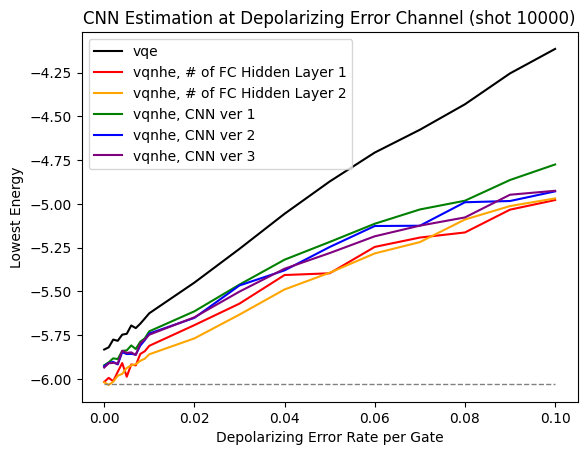

In [ ]:
error_list = [0.001*i for i in range(10)]+[0.01*i for i in range(1,11,1)]

vqe = [-5.831799999999999, -5.8191999999999995, -5.775000000000001, -5.782000000000001, -5.7467999999999995, -5.742000000000001, -5.6944, -5.709399999999999, -5.684400000000002, -5.6546, -5.6246, -5.4496, -5.256800000000002, -5.056400000000001, -4.8721999999999985, -4.706800000000002, -4.576600000000001, -4.430999999999998, -4.254599999999999, -4.114799999999999]
vqnheFC1 = [-6.016810277150228, -5.993445929692607, -6.012591815389597, -5.959095768598058, -5.909027999679842, -5.987107360376306, -5.917036036455259, -5.922397274809012, -5.857229761262304, -5.841494889534196, -5.8105821583220525, -5.692370916403381, -5.569565571660491, -5.406280078842187, -5.396340270045532, -5.245672828163454, -5.192263034610052, -5.16313359541295, -5.032879195310073, -4.978091901266644]
vqnheFC2 = [-6.0189520440435835, -6.033933976459512, -6.015939855858921, -5.981398538394226, -5.971035006177397, -5.937147888028424, -5.921916205729822, -5.915723425109382, -5.896390190020607, -5.884099549362669, -5.858966473582975, -5.768171830036203, -5.632245711882939, -5.488642324996632, -5.393136248291399, -5.282811913275707, -5.218354733066544, -5.089269, -5.012300, -4.968633]
vqnheCNN1 = [-5.9215692209688084, -5.9051113716317625, -5.882038846182267, -5.88662268294751, -5.839374372609238, -5.836689658429629, -5.808483999142415, -5.8287110002385445, -5.787439979698193, -5.768134065885558, -5.727824786531487, -5.613545399129404, -5.460960445529198, -5.318625460239696, -5.2174201256509285, -5.1133637963997245, -5.031851065964, -4.981779980345924, -4.863445336486164, -4.774758869722714]
vqnheCNN2 = [-5.927376181124571, -5.909313645416584, -5.902385999343327, -5.91682904103446, -5.846889572148767, -5.857800991752914, -5.85641765298176, -5.860881270799806, -5.8094432284179955, -5.778185369708006, -5.7403594531669775, -5.651004597288175, -5.4658300835226665, -5.379661950184275, -5.246262340515494, -5.126271426075541, -5.1247028227317, -4.990586151182147, -4.983503127684555, -4.9283753267255745]
vqnheCNN3 = [-5.934762386206508, -5.910364574282638, -5.9077996320235755, -5.9126311375680665, -5.839014355137, -5.851149824677052, -5.847962652917124, -5.863555390109498, -5.79641625818793, -5.774020466405544, -5.7471048825318505, -5.647612827534936, -5.500938544650709, -5.370238094921813, -5.28087262591312, -5.1850744865337095, -5.124235237504264, -5.0773144215044415, -4.947640136028408, -4.925073659192205]

plt.plot(error_list, vqe, label="vqe", color="black")
plt.plot(error_list, vqnheFC1, label="vqnhe, # of FC Hidden Layer 1", color="red")
plt.plot(error_list, vqnheFC2, label="vqnhe, # of FC Hidden Layer 2", color="orange")
plt.plot(error_list, vqnheCNN1, label="vqnhe, CNN ver 1", color="green")
plt.plot(error_list, vqnheCNN2, label="vqnhe, CNN ver 2", color="blue")
plt.plot(error_list, vqnheCNN3, label="vqnhe, CNN ver 3", color="purple")

plt.hlines(-6.026674, 0, 0.1,  color='gray', linestyle='--', linewidth=1)
plt.legend()
plt.xlabel("Depolarizing Error Rate per Gate")
plt.ylabel("Lowest Energy")
plt.title("CNN Estimation at Depolarizing Error Channel (shot 10000)")

Text(0.5, 1.0, 'CNN Estimation at Depolarizing Error Channel (shot 10000)')

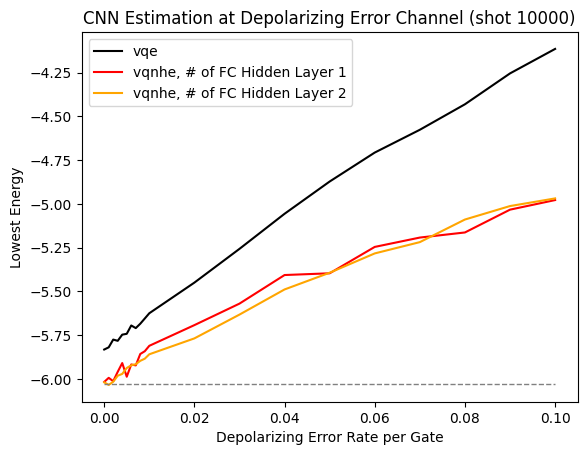

In [ ]:
plt.plot(error_list, vqe, label="vqe", color="black")
plt.plot(error_list, vqnheFC1, label="vqnhe, # of FC Hidden Layer 1", color="red")
plt.plot(error_list, vqnheFC2, label="vqnhe, # of FC Hidden Layer 2", color="orange")

plt.hlines(-6.026674, 0, 0.1,  color='gray', linestyle='--', linewidth=1)
plt.legend()
plt.xlabel("Depolarizing Error Rate per Gate")
plt.ylabel("Lowest Energy")
plt.title("CNN Estimation at Depolarizing Error Channel (shot 10000)")

Text(0.5, 1.0, 'CNN Estimation at Depolarizing Error Channel (shot 10000)')

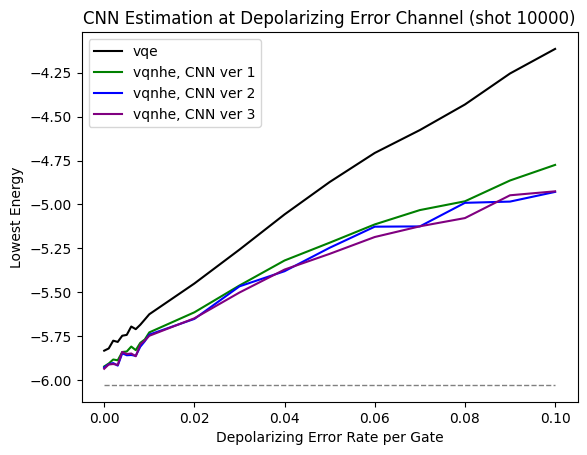

In [ ]:
plt.plot(error_list, vqe, label="vqe", color="black")
plt.plot(error_list, vqnheCNN1, label="vqnhe, CNN ver 1", color="green")
plt.plot(error_list, vqnheCNN2, label="vqnhe, CNN ver 2", color="blue")
plt.plot(error_list, vqnheCNN3, label="vqnhe, CNN ver 3", color="purple")

plt.hlines(-6.026674, 0, 0.1,  color='gray', linestyle='--', linewidth=1)
plt.legend()
plt.xlabel("Depolarizing Error Rate per Gate")
plt.ylabel("Lowest Energy")
plt.title("CNN Estimation at Depolarizing Error Channel (shot 10000)")

Text(0.5, 1.0, 'CNN Estimation at Depolarizing Error Channel (shot 10000)')

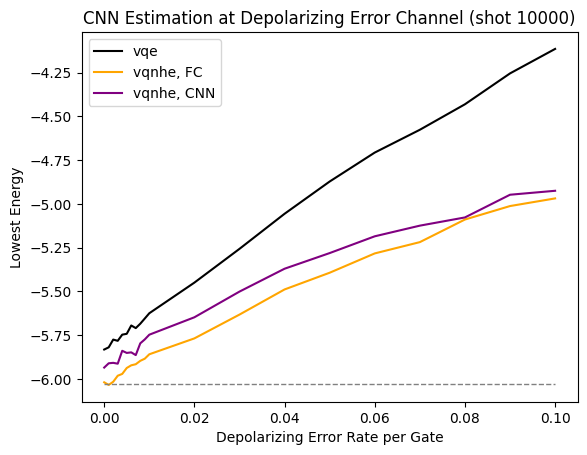

In [ ]:
plt.plot(error_list, vqe, label="vqe", color="black")
plt.plot(error_list, vqnheFC2, label="vqnhe, FC", color="orange")
plt.plot(error_list, vqnheCNN3, label="vqnhe, CNN", color="purple")

plt.hlines(-6.026674, 0, 0.1,  color='gray', linestyle='--', linewidth=1)
plt.legend()
plt.xlabel("Depolarizing Error Rate per Gate")
plt.ylabel("Lowest Energy")
plt.title("CNN Estimation at Depolarizing Error Channel (shot 10000)")